In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import io
import pandas as pd
from jax import grad
import jax.numpy as jnp
import seaborn as sns

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      
from tensorflow.keras.layers import Dense           
from tensorflow.keras import optimizers            
from tensorflow.keras import regularizers           
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.random import set_seed

In [12]:
class neural_network:
    np.random.seed(1)
    def __init__(self, layers, activ_funcs, problem_type, lmbda=0):
        """layers = list of the number of neurons in each layer of the network.
        The first and last entries are the input and output layers. So [1, 20, 1]
        gives a neural net with input layer of 1, hidden layer of 20, and output
        layer of 1.
        
        activ_funcs = list of the activation functions to use for each layer.
        options are identity, sigmoid, relu, and leaky_relu.
        
        problem_type = string 'classification' or 'regression'
        
        lmbda = optional l2 regularization parameter."""
        
        self.layers = layers
        self.n_layers = len(layers)
        self.activ_funcs = activ_funcs
        self.problem_type = problem_type
        self.lmbda = lmbda
        #initialize biases and weights randomly
        self.biases = [0.1*np.random.randn(y, 1) for y in layers[1:]]
        self.weights = [0.1*np.random.randn(y, x) for x, y in zip(layers[:-1], layers[1:])]


    def feedforward(self, a):
        "feedforward the weighted and biased input into the activation function for each layer."
        for b, w, activ_func in zip(self.biases, self.weights, self.activ_funcs):

            if activ_func == 'identity':
                a = identity(np.dot(w, a) + b)

            elif activ_func == 'sigmoid':
                a = sigmoid(np.dot(w, a) + b)

            elif activ_func == 'relu':
                a = relu(np.dot(w, a) + b)

            elif activ_func == 'leaky_relu':
                a = leaky_relu(np.dot(w, a) + b)            

        return a

    def SGD(self, training_data, testing_data, n_epochs, mini_batch_size, eta):
        """Minimize the cost function for the given problem using stochastic gradient descent
        
        training_data = list of tuples (x,y) for training data
        testing_data = list of tuples (x,y) for testing data
        n_epochs = number of epochs
        mini_batch_size = mini batch size
        eta = learning rate"""

        n_test = len(testing_data)
        n_train = len(training_data)
        
        #initialize emtpy list to store testing results
        test_results = []
        
        for i in range(n_epochs):
            # randomly select minibatches from data
            np.random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n_train, mini_batch_size)]
            
            for mini_batch in mini_batches:
                # apply the function (see update_mini_batch) that calculates the gradients, weights and biases
                self.update_mini_batch(mini_batch, eta)
            
            # evaluate the testing results at each epoch. 
            #If problem_type is regression then it will calculate MSE. If classification then accuracy.
            if self.problem_type == 'regression':
                    print("Epoch {0}: {1}".format(i, self.evaluate_reg(testing_data)))
                    test_results.append(self.evaluate_reg(testing_data))
            
            elif self.problem_type == 'classification':
                    print("Epoch {0}: {1}".format(i, self.evaluate_class(testing_data) / len(testing_data)))
                    test_results.append(self.evaluate_class(testing_data) / len(testing_data))
                    
        return test_results
                    
    def update_mini_batch(self, mini_batch, eta):
        """For a given minibatch: Calculate the gradients using backprop, and then update the weights and biases. 
        mini_batch = list of tuples (x,y)
        eta = learning rate"""
        
        # intialize gradients of the biases and weights
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]

        # prepare minibatch data in array
        x = np.column_stack([i[0] for i in mini_batch])
        y = np.column_stack([i[1] for i in mini_batch])

        # calculate gradient of the bias and weights using the backprop algorithm (see that function)
        grad_b, grad_w = self.backprop(x, y)

        # calculate update to weights and biases using the gradient, also has optional L2 regualrization parameter lmbda
        self.weights = [w * (1-self.lmbda) - (eta/len(mini_batch)) * nw  for  w, nw in zip(self.weights, grad_w)]

        self.biases = [b * (1-self.lmbda) - (eta/len(mini_batch)) * nb  for  b, nb in zip(self.biases, grad_b)]


    def backprop(self, x, y):
        """calculate the gradient of the biases and weights (grad_b,grad_w) from the minibatch data (x,y)"""
        
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]

        # feedforward
        activation = x
        # initialize list to store activations
        activations = [x]
        # initialize list to store (weight * activation + bias) values (called z)
        zs = [] 
        
        for b, w, activ_func in zip(self.biases, self.weights, self.activ_funcs):
            
            # calculate z value to feed into the activation function
            z = w @ activation + b
            zs.append(z)
            
            # input into the specified activation function for the given layer
            if activ_func == 'identity':
                activation = identity(z)
                activations.append(activation)

            elif activ_func == 'sigmoid':
                activation = sigmoid(z)
                activations.append(activation)

            elif activ_func == 'relu':
                activation = relu(z)
                activations.append(activation)

            elif activ_func == 'leaky_relu':
                activation = leaky_relu(z)
                activations.append(activation)
        
        # for the final layer:
        # calculate the cost function derivative and multiply it by the derivative of the given activation function
        # we calculate derivatives of the cost functions using jax grad
        if self.activ_funcs[-1] == 'identity':
            if self.problem_type == 'regression':
                cost_deriv = grad(self.reg_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_identity(zs[-1])    
            elif self.problem_type == 'classification':
                cost_deriv = grad(self.class_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_identity(zs[-1])   

        elif self.activ_funcs[-1] == 'sigmoid':
            if self.problem_type == 'regression':
                cost_deriv = grad(self.reg_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_sigmoid(zs[-1])    
            elif self.problem_type == 'classification':
                cost_deriv = grad(self.class_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_sigmoid(zs[-1])   

        elif self.activ_funcs[-1] == 'relu':
            if self.problem_type == 'regression':
                cost_deriv = grad(self.reg_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_relu(zs[-1])    
            elif self.problem_type == 'classification':
                cost_deriv = grad(self.class_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_relu(zs[-1])   

        elif self.activ_funcs[-1] == 'leaky_relu':
            if self.problem_type == 'regression':
                cost_deriv = grad(self.reg_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_leaky_relu(zs[-1])    
            elif self.problem_type == 'classification':
                cost_deriv = grad(self.class_cost_func)
                deltas = cost_deriv(activations[-1], y) * d_leaky_relu(zs[-1])   

        # calculate the gradient of the biases and the weights 
        grad_b[-1] = deltas.sum(axis=1).reshape((len(deltas), 1))
        grad_w[-1] = deltas @ activations[-2].transpose()

        # for the hidden layers:
        # apply the given activation functions
        for layer, activ_func in zip(range(2, self.n_layers), self.activ_funcs):
            z = zs[-layer]

            if activ_func == 'identity':
                sp = d_identity(z)

            elif activ_func == 'sigmoid':
                sp = d_sigmoid(z)

            elif activ_func == 'relu':
                sp = d_relu(z)

            elif activ_func == 'leaky_relu':
                sp = d_leaky_relu(z)
            
            # calculate the gradients of the biases and weights for the hidden layers
            deltas = (self.weights[-layer+1].transpose() @ deltas) * sp
            grad_b[-layer] = deltas.sum(axis=1).reshape((len(deltas), 1))
            grad_w[-layer] = deltas @ activations[-layer-1].transpose()

        return (grad_b, grad_w)

    def evaluate_reg(self, testing_data):
        """This function calculates the testing MSE for regression"""

        sum_sq_errs = 0
        for (x, y) in testing_data:
            sum_sq_errs += (self.feedforward(x)-y)**2

        return (sum_sq_errs / len(testing_data))[0][0]


    def evaluate_class(self, testing_data):
        """This function returns the number of correct classifications in testing"""
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in testing_data]

        return sum(int(x == y) for (x, y) in test_results)

    
    def reg_cost_func(self, ypred, y):
        """This is the cost function for regression (mean squared error)
        we calculate its derivative elsewhere using jax so we use jnp for numpy."""

        return jnp.sum((y-ypred)**2)/len(y)     

    def class_cost_func(self, ypred, y):
        """This is the cost function for classification (binary cross entropy)
        we calculate its derivative elsewhere using jax so we use jnp for numpy."""

        return  -jnp.sum( jnp.multiply(jnp.log(ypred), y) + jnp.multiply(jnp.log(1-ypred), (1-y))) / len(y)

# ALL THE ACTIVATION FUNCTIONS AND THEIR DERIVATIVES
def identity(z):
    return z

def d_identity(z):
    return np.ones(z.shape)

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1-sigmoid(z))

def relu(z):
    return np.maximum(z, 0)

def d_relu(z):
    return (z > 0)

def leaky_relu(z):
    if z.all() < 0:
        out = z*0.1
    else:
        out = z
    return out    

def d_leaky_relu(z):
    if z.all() < 0:
        out = 0.1
    else:
        out = 1
    return out


#####################################################################################################################

# Regression

#####################################################################################################################

### From Scratch

### ReLU hidden, 50 nodes test

In [13]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['relu', 'relu']
net_relu = neural_network([1, 50, 1], activ_funcs, 'regression', lmbda=0)

data_size = len(train)
n_epochs = 1000
eta = 0.01
test_mse_scratch_relu = net_relu.SGD(train, test, n_epochs, data_size, eta)

Epoch 0: 254.6492156982422
Epoch 1: 209.46975708007812
Epoch 2: 133.62057495117188
Epoch 3: 43.589012145996094
Epoch 4: 3.688178539276123
Epoch 5: 3.400451183319092
Epoch 6: 3.063838481903076
Epoch 7: 3.0293829441070557
Epoch 8: 2.95098614692688
Epoch 9: 2.8857040405273438
Epoch 10: 2.8231329917907715
Epoch 11: 2.764752149581909
Epoch 12: 2.710012912750244
Epoch 13: 2.6584696769714355
Epoch 14: 2.6100540161132812
Epoch 15: 2.5646908283233643
Epoch 16: 2.5221028327941895
Epoch 17: 2.482112169265747
Epoch 18: 2.444549083709717
Epoch 19: 2.4092602729797363
Epoch 20: 2.376042127609253
Epoch 21: 2.3442394733428955
Epoch 22: 2.3146936893463135
Epoch 23: 2.286858081817627
Epoch 24: 2.260662078857422
Epoch 25: 2.235705852508545
Epoch 26: 2.212430238723755
Epoch 27: 2.1904470920562744
Epoch 28: 2.1697304248809814
Epoch 29: 2.1501975059509277
Epoch 30: 2.1317760944366455
Epoch 31: 2.1143035888671875
Epoch 32: 2.0975122451782227
Epoch 33: 2.08182430267334
Epoch 34: 2.066991090774536
Epoch 35: 2.0

Epoch 301: 0.7834754586219788
Epoch 302: 0.7795218825340271
Epoch 303: 0.7755785584449768
Epoch 304: 0.7716488242149353
Epoch 305: 0.7677397131919861
Epoch 306: 0.7638401985168457
Epoch 307: 0.7599521279335022
Epoch 308: 0.7565818428993225
Epoch 309: 0.7521666884422302
Epoch 310: 0.7487325668334961
Epoch 311: 0.7448228597640991
Epoch 312: 0.741083025932312
Epoch 313: 0.7372969388961792
Epoch 314: 0.7335579991340637
Epoch 315: 0.729576826095581
Epoch 316: 0.7263565063476562
Epoch 317: 0.7220789194107056
Epoch 318: 0.7189664840698242
Epoch 319: 0.7147084474563599
Epoch 320: 0.7123441696166992
Epoch 321: 0.7080051898956299
Epoch 322: 0.705093502998352
Epoch 323: 0.7009586095809937
Epoch 324: 0.698015034198761
Epoch 325: 0.6946335434913635
Epoch 326: 0.6902264356613159
Epoch 327: 0.6881788969039917
Epoch 328: 0.6837332844734192
Epoch 329: 0.6806577444076538
Epoch 330: 0.6773372888565063
Epoch 331: 0.6743834018707275
Epoch 332: 0.670304536819458
Epoch 333: 0.6671263575553894
Epoch 334: 0.66

Epoch 598: 0.19022242724895477
Epoch 599: 0.1894420087337494
Epoch 600: 0.1886673867702484
Epoch 601: 0.18790052831172943
Epoch 602: 0.1871388852596283
Epoch 603: 0.1863851249217987
Epoch 604: 0.1856360137462616
Epoch 605: 0.1848936527967453
Epoch 606: 0.18415871262550354
Epoch 607: 0.18342871963977814
Epoch 608: 0.1827060878276825
Epoch 609: 0.18198904395103455
Epoch 610: 0.18127913773059845
Epoch 611: 0.18018987774848938
Epoch 612: 0.17946191132068634
Epoch 613: 0.1786934733390808
Epoch 614: 0.17795081436634064
Epoch 615: 0.1772073656320572
Epoch 616: 0.17647412419319153
Epoch 617: 0.1757461130619049
Epoch 618: 0.17502041161060333
Epoch 619: 0.17425063252449036
Epoch 620: 0.1734779179096222
Epoch 621: 0.17270919680595398
Epoch 622: 0.17194734513759613
Epoch 623: 0.17119070887565613
Epoch 624: 0.17044073343276978
Epoch 625: 0.1696949154138565
Epoch 626: 0.16895702481269836
Epoch 627: 0.16822244226932526
Epoch 628: 0.1674952656030655
Epoch 629: 0.16677184402942657
Epoch 630: 0.16605603

Epoch 866: 0.09255217760801315
Epoch 867: 0.09251264482736588
Epoch 868: 0.09247463941574097
Epoch 869: 0.09243789315223694
Epoch 870: 0.09240196645259857
Epoch 871: 0.09236674755811691
Epoch 872: 0.09233291447162628
Epoch 873: 0.09229946881532669
Epoch 874: 0.09226609766483307
Epoch 875: 0.09223292022943497
Epoch 876: 0.09220151603221893
Epoch 877: 0.09217070788145065
Epoch 878: 0.09214015305042267
Epoch 879: 0.09211152791976929
Epoch 880: 0.09208311140537262
Epoch 881: 0.09205619990825653
Epoch 882: 0.09202945977449417
Epoch 883: 0.09200398623943329
Epoch 884: 0.09197846800088882
Epoch 885: 0.091952845454216
Epoch 886: 0.09192859381437302
Epoch 887: 0.0919046476483345
Epoch 888: 0.09188170731067657
Epoch 889: 0.09185953438282013
Epoch 890: 0.09183825552463531
Epoch 891: 0.09181773662567139
Epoch 892: 0.0917978510260582
Epoch 893: 0.09177857637405396
Epoch 894: 0.09176043421030045
Epoch 895: 0.09174180775880814
Epoch 896: 0.0917227640748024
Epoch 897: 0.09170467406511307
Epoch 898: 0.

In [14]:
print(min(test_mse_scratch_relu))

0.09056041


### sigmoid hidden, 50 nodes test

In [15]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['sigmoid', 'relu']
net_relu = neural_network([1, 50, 1], activ_funcs, 'regression', lmbda=0)

data_size = len(train)
n_epochs = 1000
eta = 0.01
test_mse_scratch_sig = net_relu.SGD(train, test, n_epochs, data_size, eta)

Epoch 0: 167.79238891601562
Epoch 1: 108.92845153808594
Epoch 2: 74.48369598388672
Epoch 3: 54.590232849121094
Epoch 4: 43.32456588745117
Epoch 5: 36.978275299072266
Epoch 6: 33.33260726928711
Epoch 7: 31.139022827148438
Epoch 8: 29.726871490478516
Epoch 9: 28.744125366210938
Epoch 10: 28.006032943725586
Epoch 11: 27.413904190063477
Epoch 12: 26.9134464263916
Epoch 13: 26.473745346069336
Epoch 14: 26.076589584350586
Epoch 15: 25.710865020751953
Epoch 16: 25.369539260864258
Epoch 17: 25.048046112060547
Epoch 18: 24.743270874023438
Epoch 19: 24.453006744384766
Epoch 20: 24.17560577392578
Epoch 21: 23.9097900390625
Epoch 22: 23.654521942138672
Epoch 23: 23.408939361572266
Epoch 24: 23.172290802001953
Epoch 25: 22.943893432617188
Epoch 26: 22.723169326782227
Epoch 27: 22.509584426879883
Epoch 28: 22.3026180267334
Epoch 29: 22.101839065551758
Epoch 30: 21.906822204589844
Epoch 31: 21.717182159423828
Epoch 32: 21.532567977905273
Epoch 33: 21.352638244628906
Epoch 34: 21.177095413208008
Epoch

Epoch 309: 2.6300017833709717
Epoch 310: 2.620288372039795
Epoch 311: 2.610659599304199
Epoch 312: 2.6011064052581787
Epoch 313: 2.591632843017578
Epoch 314: 2.5822386741638184
Epoch 315: 2.5729191303253174
Epoch 316: 2.5636754035949707
Epoch 317: 2.5545074939727783
Epoch 318: 2.5454115867614746
Epoch 319: 2.5363924503326416
Epoch 320: 2.5274434089660645
Epoch 321: 2.5185635089874268
Epoch 322: 2.5097570419311523
Epoch 323: 2.501016139984131
Epoch 324: 2.492347240447998
Epoch 325: 2.4837429523468018
Epoch 326: 2.4752073287963867
Epoch 327: 2.4667367935180664
Epoch 328: 2.4583306312561035
Epoch 329: 2.4499893188476562
Epoch 330: 2.44171142578125
Epoch 331: 2.433495044708252
Epoch 332: 2.4253432750701904
Epoch 333: 2.4172489643096924
Epoch 334: 2.40921950340271
Epoch 335: 2.401245594024658
Epoch 336: 2.3933329582214355
Epoch 337: 2.3854804039001465
Epoch 338: 2.3776817321777344
Epoch 339: 2.369943141937256
Epoch 340: 2.3622584342956543
Epoch 341: 2.3546321392059326
Epoch 342: 2.347058534

Epoch 597: 1.309528112411499
Epoch 598: 1.3072025775909424
Epoch 599: 1.3048843145370483
Epoch 600: 1.3025720119476318
Epoch 601: 1.3002684116363525
Epoch 602: 1.297969102859497
Epoch 603: 1.2956774234771729
Epoch 604: 1.293392300605774
Epoch 605: 1.2911142110824585
Epoch 606: 1.2888433933258057
Epoch 607: 1.2865784168243408
Epoch 608: 1.284320592880249
Epoch 609: 1.2820699214935303
Epoch 610: 1.2798235416412354
Epoch 611: 1.2775852680206299
Epoch 612: 1.275352954864502
Epoch 613: 1.2731280326843262
Epoch 614: 1.2709068059921265
Epoch 615: 1.2686946392059326
Epoch 616: 1.2664874792099
Epoch 617: 1.2642878293991089
Epoch 618: 1.262094259262085
Epoch 619: 1.2599050998687744
Epoch 620: 1.2577239274978638
Epoch 621: 1.2555477619171143
Epoch 622: 1.253380298614502
Epoch 623: 1.2512142658233643
Epoch 624: 1.2490559816360474
Epoch 625: 1.2469072341918945
Epoch 626: 1.2447596788406372
Epoch 627: 1.2426211833953857
Epoch 628: 1.2404882907867432
Epoch 629: 1.2383607625961304
Epoch 630: 1.2362381

Epoch 884: 0.8313472867012024
Epoch 885: 0.8301308751106262
Epoch 886: 0.8289183378219604
Epoch 887: 0.8277076482772827
Epoch 888: 0.8264986276626587
Epoch 889: 0.8252907991409302
Epoch 890: 0.8240850567817688
Epoch 891: 0.8228821754455566
Epoch 892: 0.8216825723648071
Epoch 893: 0.8204832077026367
Epoch 894: 0.8192867040634155
Epoch 895: 0.818092942237854
Epoch 896: 0.8169000744819641
Epoch 897: 0.8157092332839966
Epoch 898: 0.8145216703414917
Epoch 899: 0.813336193561554
Epoch 900: 0.812152087688446
Epoch 901: 0.8109711408615112
Epoch 902: 0.8097912073135376
Epoch 903: 0.8086131811141968
Epoch 904: 0.8074373006820679
Epoch 905: 0.8062631487846375
Epoch 906: 0.8050922155380249
Epoch 907: 0.8039228320121765
Epoch 908: 0.8027552366256714
Epoch 909: 0.8015897870063782
Epoch 910: 0.8004266619682312
Epoch 911: 0.7992652654647827
Epoch 912: 0.798105776309967
Epoch 913: 0.7969474792480469
Epoch 914: 0.7957928776741028
Epoch 915: 0.7946400046348572
Epoch 916: 0.7934898138046265
Epoch 917: 0.7

In [16]:
print(min(test_mse_scratch_sig))

0.70436347


### leaky relu hidden, 50 nodes test

In [17]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['leaky_relu', 'relu']
net_relu = neural_network([1, 50, 1], activ_funcs, 'regression', lmbda=0)

data_size = len(train)
n_epochs = 1000
eta = 0.01
test_mse_scratch_leaky = net_relu.SGD(train, test, n_epochs, data_size, eta)

Epoch 0: 248.3289337158203
Epoch 1: 189.657470703125
Epoch 2: 101.66966247558594
Epoch 3: 20.930810928344727
Epoch 4: 2.8556056022644043
Epoch 5: 3.270803928375244
Epoch 6: 3.071892261505127
Epoch 7: 3.0152268409729004
Epoch 8: 2.9394545555114746
Epoch 9: 2.8727939128875732
Epoch 10: 2.809699058532715
Epoch 11: 2.7508206367492676
Epoch 12: 2.6957147121429443
Epoch 13: 2.644150972366333
Epoch 14: 2.5958876609802246
Epoch 15: 2.5507051944732666
Epoch 16: 2.508395195007324
Epoch 17: 2.4687702655792236
Epoch 18: 2.4316487312316895
Epoch 19: 2.3968663215637207
Epoch 20: 2.364267587661743
Epoch 21: 2.333707571029663
Epoch 22: 2.3050577640533447
Epoch 23: 2.2781858444213867
Epoch 24: 2.2529778480529785
Epoch 25: 2.229325771331787
Epoch 26: 2.2071292400360107
Epoch 27: 2.186286449432373
Epoch 28: 2.1667213439941406
Epoch 29: 2.1483447551727295
Epoch 30: 2.13108229637146
Epoch 31: 2.114856481552124
Epoch 32: 2.099608898162842
Epoch 33: 2.085273265838623
Epoch 34: 2.071793556213379
Epoch 35: 2.0

Epoch 286: 1.8468393087387085
Epoch 287: 1.8468393087387085
Epoch 288: 1.8468393087387085
Epoch 289: 1.8468389511108398
Epoch 290: 1.8468389511108398
Epoch 291: 1.8468389511108398
Epoch 292: 1.846839189529419
Epoch 293: 1.846839189529419
Epoch 294: 1.846839189529419
Epoch 295: 1.846839189529419
Epoch 296: 1.846839189529419
Epoch 297: 1.8468387126922607
Epoch 298: 1.8468387126922607
Epoch 299: 1.8468387126922607
Epoch 300: 1.8468387126922607
Epoch 301: 1.8468387126922607
Epoch 302: 1.8468387126922607
Epoch 303: 1.8468387126922607
Epoch 304: 1.8468387126922607
Epoch 305: 1.8468387126922607
Epoch 306: 1.8468387126922607
Epoch 307: 1.8468387126922607
Epoch 308: 1.8468387126922607
Epoch 309: 1.8468387126922607
Epoch 310: 1.8468387126922607
Epoch 311: 1.8468387126922607
Epoch 312: 1.8468387126922607
Epoch 313: 1.8468387126922607
Epoch 314: 1.8468387126922607
Epoch 315: 1.8468387126922607
Epoch 316: 1.8468387126922607
Epoch 317: 1.8468387126922607
Epoch 318: 1.8468395471572876
Epoch 319: 1.84

Epoch 572: 1.8468387126922607
Epoch 573: 1.8468387126922607
Epoch 574: 1.8468387126922607
Epoch 575: 1.8468387126922607
Epoch 576: 1.8468387126922607
Epoch 577: 1.8468387126922607
Epoch 578: 1.8468387126922607
Epoch 579: 1.8468387126922607
Epoch 580: 1.8468387126922607
Epoch 581: 1.8468387126922607
Epoch 582: 1.8468387126922607
Epoch 583: 1.8468387126922607
Epoch 584: 1.8468387126922607
Epoch 585: 1.8468387126922607
Epoch 586: 1.8468387126922607
Epoch 587: 1.8468387126922607
Epoch 588: 1.8468387126922607
Epoch 589: 1.8468387126922607
Epoch 590: 1.8468387126922607
Epoch 591: 1.8468387126922607
Epoch 592: 1.8468387126922607
Epoch 593: 1.8468387126922607
Epoch 594: 1.8468387126922607
Epoch 595: 1.8468387126922607
Epoch 596: 1.8468387126922607
Epoch 597: 1.8468387126922607
Epoch 598: 1.8468387126922607
Epoch 599: 1.8468387126922607
Epoch 600: 1.8468387126922607
Epoch 601: 1.8468387126922607
Epoch 602: 1.8468387126922607
Epoch 603: 1.8468387126922607
Epoch 604: 1.8468387126922607
Epoch 605:

Epoch 852: 1.8468387126922607
Epoch 853: 1.8468385934829712
Epoch 854: 1.8468385934829712
Epoch 855: 1.8468387126922607
Epoch 856: 1.8468385934829712
Epoch 857: 1.8468387126922607
Epoch 858: 1.8468385934829712
Epoch 859: 1.8468387126922607
Epoch 860: 1.8468385934829712
Epoch 861: 1.8468387126922607
Epoch 862: 1.8468385934829712
Epoch 863: 1.8468385934829712
Epoch 864: 1.8468385934829712
Epoch 865: 1.8468385934829712
Epoch 866: 1.8468387126922607
Epoch 867: 1.8468385934829712
Epoch 868: 1.8468385934829712
Epoch 869: 1.8468385934829712
Epoch 870: 1.8468385934829712
Epoch 871: 1.8468385934829712
Epoch 872: 1.8468385934829712
Epoch 873: 1.8468385934829712
Epoch 874: 1.8468385934829712
Epoch 875: 1.8468385934829712
Epoch 876: 1.8468385934829712
Epoch 877: 1.8468385934829712
Epoch 878: 1.8468385934829712
Epoch 879: 1.8468385934829712
Epoch 880: 1.8468385934829712
Epoch 881: 1.8468385934829712
Epoch 882: 1.8468385934829712
Epoch 883: 1.8468385934829712
Epoch 884: 1.8468385934829712
Epoch 885:

In [18]:
print(min(test_mse_scratch_leaky))

1.8468384


### two ReLU hidden, 50 nodes test

In [19]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['relu', 'relu', 'relu']
net_relu = neural_network([1, 50, 50, 1], activ_funcs, 'regression', lmbda=0)

data_size = len(train)
n_epochs = 1000
eta = 0.01
test_mse_scratch_relu_2 = net_relu.SGD(train, test, n_epochs, data_size, eta)

Epoch 0: 253.362548828125
Epoch 1: 214.7176971435547
Epoch 2: 125.54963684082031
Epoch 3: 5.44949197769165
Epoch 4: 4.680280685424805
Epoch 5: 4.905068874359131
Epoch 6: 3.5731072425842285
Epoch 7: 8.510296821594238
Epoch 8: 12.709806442260742
Epoch 9: 68.04649353027344
Epoch 10: 194.07809448242188
Epoch 11: 85.11307525634766
Epoch 12: 31.504430770874023
Epoch 13: 90.22164154052734
Epoch 14: 22.20140266418457
Epoch 15: 58.04814910888672
Epoch 16: 59.89467239379883
Epoch 17: 162.4153289794922
Epoch 18: 43.338863372802734
Epoch 19: 62.07593536376953
Epoch 20: 158.5102081298828
Epoch 21: 48.15509033203125
Epoch 22: 46.566707611083984
Epoch 23: 117.16630554199219
Epoch 24: 5.937400817871094
Epoch 25: 26.6639347076416
Epoch 26: 62.24238204956055
Epoch 27: 25.976613998413086
Epoch 28: 59.9026985168457
Epoch 29: 26.368423461914062
Epoch 30: 60.64665603637695
Epoch 31: 23.719667434692383
Epoch 32: 52.7187385559082
Epoch 33: 29.5472412109375
Epoch 34: 68.58790588378906
Epoch 35: 13.607261657714

Epoch 292: 7.565419673919678
Epoch 293: 7.492514133453369
Epoch 294: 7.423606872558594
Epoch 295: 7.356478691101074
Epoch 296: 7.248879909515381
Epoch 297: 7.250101566314697
Epoch 298: 7.122418403625488
Epoch 299: 7.1126556396484375
Epoch 300: 6.950976371765137
Epoch 301: 6.992678642272949
Epoch 302: 6.810225486755371
Epoch 303: 6.880653381347656
Epoch 304: 6.680035591125488
Epoch 305: 6.783027648925781
Epoch 306: 6.5695481300354
Epoch 307: 6.668017387390137
Epoch 308: 6.432852745056152
Epoch 309: 6.5625433921813965
Epoch 310: 6.312525749206543
Epoch 311: 6.466082572937012
Epoch 312: 6.196630001068115
Epoch 313: 6.371245384216309
Epoch 314: 6.089629173278809
Epoch 315: 6.276957988739014
Epoch 316: 5.983654022216797
Epoch 317: 6.187039375305176
Epoch 318: 5.883490085601807
Epoch 319: 6.103213310241699
Epoch 320: 5.784054279327393
Epoch 321: 6.024819374084473
Epoch 322: 5.68562650680542
Epoch 323: 5.945193767547607
Epoch 324: 5.589366436004639
Epoch 325: 5.850178241729736
Epoch 326: 5.47

Epoch 586: 1.2984708547592163
Epoch 587: 1.4353699684143066
Epoch 588: 1.2910494804382324
Epoch 589: 1.4252221584320068
Epoch 590: 1.2836717367172241
Epoch 591: 1.4154831171035767
Epoch 592: 1.2768290042877197
Epoch 593: 1.4062354564666748
Epoch 594: 1.270469307899475
Epoch 595: 1.3967005014419556
Epoch 596: 1.2636970281600952
Epoch 597: 1.3876363039016724
Epoch 598: 1.2573633193969727
Epoch 599: 1.37873113155365
Epoch 600: 1.2512670755386353
Epoch 601: 1.370108723640442
Epoch 602: 1.2452809810638428
Epoch 603: 1.36159348487854
Epoch 604: 1.2392737865447998
Epoch 605: 1.3530720472335815
Epoch 606: 1.2331819534301758
Epoch 607: 1.3444870710372925
Epoch 608: 1.2268959283828735
Epoch 609: 1.3358087539672852
Epoch 610: 1.220467209815979
Epoch 611: 1.3273510932922363
Epoch 612: 1.214117169380188
Epoch 613: 1.3188040256500244
Epoch 614: 1.207392692565918
Epoch 615: 1.3102082014083862
Epoch 616: 1.2006399631500244
Epoch 617: 1.3016431331634521
Epoch 618: 1.1938556432724
Epoch 619: 1.292939782

Epoch 880: 0.6821888089179993
Epoch 881: 0.6428470015525818
Epoch 882: 0.6799659132957458
Epoch 883: 0.639783501625061
Epoch 884: 0.6764853000640869
Epoch 885: 0.6356280446052551
Epoch 886: 0.6718213558197021
Epoch 887: 0.6320170164108276
Epoch 888: 0.6677408814430237
Epoch 889: 0.6288226842880249
Epoch 890: 0.6640934944152832
Epoch 891: 0.6259053945541382
Epoch 892: 0.6609154939651489
Epoch 893: 0.6233494877815247
Epoch 894: 0.6580976247787476
Epoch 895: 0.6211457848548889
Epoch 896: 0.655739426612854
Epoch 897: 0.6193596124649048
Epoch 898: 0.6537619233131409
Epoch 899: 0.6178382635116577
Epoch 900: 0.6519709229469299
Epoch 901: 0.6165608763694763
Epoch 902: 0.6498757600784302
Epoch 903: 0.6149333119392395
Epoch 904: 0.6480783224105835
Epoch 905: 0.6135910153388977
Epoch 906: 0.6466084718704224
Epoch 907: 0.6126331090927124
Epoch 908: 0.645608127117157
Epoch 909: 0.6118466854095459
Epoch 910: 0.6445764303207397
Epoch 911: 0.6112699508666992
Epoch 912: 0.643821656703949
Epoch 913: 0.6

In [20]:
print(min(test_mse_scratch_relu_2))

0.571013


### relu hidden, 100 nodes test (more nodes)

In [21]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['relu', 'relu']
net_relu = neural_network([1, 100, 1], activ_funcs, 'regression', lmbda=0)

data_size = len(train)
n_epochs = 1000
eta = 0.01
test_mse_scratch_relu_100 = net_relu.SGD(train, test, n_epochs, data_size, eta)

Epoch 0: 280.45526123046875
Epoch 1: 280.45526123046875
Epoch 2: 280.45526123046875
Epoch 3: 280.45526123046875
Epoch 4: 280.45526123046875
Epoch 5: 280.45526123046875
Epoch 6: 280.45526123046875
Epoch 7: 280.45526123046875
Epoch 8: 280.45526123046875
Epoch 9: 280.45526123046875
Epoch 10: 280.45526123046875
Epoch 11: 280.45526123046875
Epoch 12: 280.45526123046875
Epoch 13: 280.45526123046875
Epoch 14: 280.45526123046875
Epoch 15: 280.45526123046875
Epoch 16: 280.45526123046875
Epoch 17: 280.45526123046875
Epoch 18: 280.45526123046875
Epoch 19: 280.45526123046875
Epoch 20: 280.45526123046875
Epoch 21: 280.45526123046875
Epoch 22: 280.45526123046875
Epoch 23: 280.45526123046875
Epoch 24: 280.45526123046875
Epoch 25: 280.45526123046875
Epoch 26: 280.45526123046875
Epoch 27: 280.45526123046875
Epoch 28: 280.45526123046875
Epoch 29: 280.45526123046875
Epoch 30: 280.45526123046875
Epoch 31: 280.45526123046875
Epoch 32: 280.45526123046875
Epoch 33: 280.45526123046875
Epoch 34: 280.4552612304

Epoch 280: 280.45526123046875
Epoch 281: 280.45526123046875
Epoch 282: 280.45526123046875
Epoch 283: 280.45526123046875
Epoch 284: 280.45526123046875
Epoch 285: 280.45526123046875
Epoch 286: 280.45526123046875
Epoch 287: 280.45526123046875
Epoch 288: 280.45526123046875
Epoch 289: 280.45526123046875
Epoch 290: 280.45526123046875
Epoch 291: 280.45526123046875
Epoch 292: 280.45526123046875
Epoch 293: 280.45526123046875
Epoch 294: 280.45526123046875
Epoch 295: 280.45526123046875
Epoch 296: 280.45526123046875
Epoch 297: 280.45526123046875
Epoch 298: 280.45526123046875
Epoch 299: 280.45526123046875
Epoch 300: 280.45526123046875
Epoch 301: 280.45526123046875
Epoch 302: 280.45526123046875
Epoch 303: 280.45526123046875
Epoch 304: 280.45526123046875
Epoch 305: 280.45526123046875
Epoch 306: 280.45526123046875
Epoch 307: 280.45526123046875
Epoch 308: 280.45526123046875
Epoch 309: 280.45526123046875
Epoch 310: 280.45526123046875
Epoch 311: 280.45526123046875
Epoch 312: 280.45526123046875
Epoch 313:

Epoch 573: 280.45526123046875
Epoch 574: 280.45526123046875
Epoch 575: 280.45526123046875
Epoch 576: 280.45526123046875
Epoch 577: 280.45526123046875
Epoch 578: 280.45526123046875
Epoch 579: 280.45526123046875
Epoch 580: 280.45526123046875
Epoch 581: 280.45526123046875
Epoch 582: 280.45526123046875
Epoch 583: 280.45526123046875
Epoch 584: 280.45526123046875
Epoch 585: 280.45526123046875
Epoch 586: 280.45526123046875
Epoch 587: 280.45526123046875
Epoch 588: 280.45526123046875
Epoch 589: 280.45526123046875
Epoch 590: 280.45526123046875
Epoch 591: 280.45526123046875
Epoch 592: 280.45526123046875
Epoch 593: 280.45526123046875
Epoch 594: 280.45526123046875
Epoch 595: 280.45526123046875
Epoch 596: 280.45526123046875
Epoch 597: 280.45526123046875
Epoch 598: 280.45526123046875
Epoch 599: 280.45526123046875
Epoch 600: 280.45526123046875
Epoch 601: 280.45526123046875
Epoch 602: 280.45526123046875
Epoch 603: 280.45526123046875
Epoch 604: 280.45526123046875
Epoch 605: 280.45526123046875
Epoch 606:

Epoch 869: 280.45526123046875
Epoch 870: 280.45526123046875
Epoch 871: 280.45526123046875
Epoch 872: 280.45526123046875
Epoch 873: 280.45526123046875
Epoch 874: 280.45526123046875
Epoch 875: 280.45526123046875
Epoch 876: 280.45526123046875
Epoch 877: 280.45526123046875
Epoch 878: 280.45526123046875
Epoch 879: 280.45526123046875
Epoch 880: 280.45526123046875
Epoch 881: 280.45526123046875
Epoch 882: 280.45526123046875
Epoch 883: 280.45526123046875
Epoch 884: 280.45526123046875
Epoch 885: 280.45526123046875
Epoch 886: 280.45526123046875
Epoch 887: 280.45526123046875
Epoch 888: 280.45526123046875
Epoch 889: 280.45526123046875
Epoch 890: 280.45526123046875
Epoch 891: 280.45526123046875
Epoch 892: 280.45526123046875
Epoch 893: 280.45526123046875
Epoch 894: 280.45526123046875
Epoch 895: 280.45526123046875
Epoch 896: 280.45526123046875
Epoch 897: 280.45526123046875
Epoch 898: 280.45526123046875
Epoch 899: 280.45526123046875
Epoch 900: 280.45526123046875
Epoch 901: 280.45526123046875
Epoch 902:

In [22]:
print(min(test_mse_scratch_relu_100))

280.45526


## Grid search using the best model (1 hidden relu, 50 nodes). Takes a few minutes to run...

In [23]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['relu', 'relu']
etas = np.array([1e-3, 1e-2, 1e-1])
lmbdas = np.array([0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
n_epochs = 1000
data_size = len(train)
nn_reg_grid = np.zeros((len(etas), len(lmbdas)))
                        
for eta,i in zip(etas, range(len(etas))):
    for lmbd,j in zip(lmbdas, range(len(lmbdas))):
        
        net_reg = neural_network([1, 50, 1], activ_funcs, 'regression', lmbda=lmbd)
        test_mses = net_reg.SGD(train, test, n_epochs, data_size, eta)
                        
        final_mse = test_mses[-1]
        nn_reg_grid[i,j] = final_mse
        
    print(i)

Epoch 0: 276.2923583984375
Epoch 1: 273.8116149902344
Epoch 2: 271.02032470703125
Epoch 3: 267.9805603027344
Epoch 4: 264.77984619140625
Epoch 5: 261.2898864746094
Epoch 6: 257.5592956542969
Epoch 7: 253.57620239257812
Epoch 8: 249.3333282470703
Epoch 9: 244.8235321044922
Epoch 10: 240.02197265625
Epoch 11: 234.8832244873047
Epoch 12: 229.3868865966797
Epoch 13: 223.516357421875
Epoch 14: 217.25048828125
Epoch 15: 210.57498168945312
Epoch 16: 203.48338317871094
Epoch 17: 195.97348022460938
Epoch 18: 188.05227661132812
Epoch 19: 179.73338317871094
Epoch 20: 171.04153442382812
Epoch 21: 162.01092529296875
Epoch 22: 152.68719482421875
Epoch 23: 143.1259002685547
Epoch 24: 133.39451599121094
Epoch 25: 123.56941986083984
Epoch 26: 113.73335266113281
Epoch 27: 103.97615051269531
Epoch 28: 94.38929748535156
Epoch 29: 85.0647964477539
Epoch 30: 76.08985900878906
Epoch 31: 67.54483032226562
Epoch 32: 59.49918746948242
Epoch 33: 52.009681701660156
Epoch 34: 45.11785125732422
Epoch 35: 38.8495941

Epoch 302: 2.1143224239349365
Epoch 303: 2.112652063369751
Epoch 304: 2.110990285873413
Epoch 305: 2.109342336654663
Epoch 306: 2.1077046394348145
Epoch 307: 2.1060757637023926
Epoch 308: 2.10445237159729
Epoch 309: 2.1028358936309814
Epoch 310: 2.1012320518493652
Epoch 311: 2.099630117416382
Epoch 312: 2.098043918609619
Epoch 313: 2.0964581966400146
Epoch 314: 2.0948917865753174
Epoch 315: 2.0933327674865723
Epoch 316: 2.091783046722412
Epoch 317: 2.0902373790740967
Epoch 318: 2.0887062549591064
Epoch 319: 2.087148904800415
Epoch 320: 2.085603713989258
Epoch 321: 2.084070920944214
Epoch 322: 2.082545042037964
Epoch 323: 2.081026792526245
Epoch 324: 2.0795247554779053
Epoch 325: 2.078022003173828
Epoch 326: 2.0765302181243896
Epoch 327: 2.075058698654175
Epoch 328: 2.073596239089966
Epoch 329: 2.0721356868743896
Epoch 330: 2.0706849098205566
Epoch 331: 2.0692365169525146
Epoch 332: 2.0678038597106934
Epoch 333: 2.0663809776306152
Epoch 334: 2.0649685859680176
Epoch 335: 2.0635623931884

Epoch 596: 1.8572670221328735
Epoch 597: 1.8568611145019531
Epoch 598: 1.8564555644989014
Epoch 599: 1.8560539484024048
Epoch 600: 1.8556480407714844
Epoch 601: 1.8552520275115967
Epoch 602: 1.8548552989959717
Epoch 603: 1.8544607162475586
Epoch 604: 1.8540645837783813
Epoch 605: 1.8536732196807861
Epoch 606: 1.8532819747924805
Epoch 607: 1.8528940677642822
Epoch 608: 1.8525054454803467
Epoch 609: 1.852120041847229
Epoch 610: 1.8517287969589233
Epoch 611: 1.851346731185913
Epoch 612: 1.8509677648544312
Epoch 613: 1.8505876064300537
Epoch 614: 1.8501981496810913
Epoch 615: 1.849782943725586
Epoch 616: 1.8493640422821045
Epoch 617: 1.8489621877670288
Epoch 618: 1.848562240600586
Epoch 619: 1.8481683731079102
Epoch 620: 1.847774863243103
Epoch 621: 1.8473860025405884
Epoch 622: 1.8469969034194946
Epoch 623: 1.8466155529022217
Epoch 624: 1.846234917640686
Epoch 625: 1.845859169960022
Epoch 626: 1.8454850912094116
Epoch 627: 1.8451131582260132
Epoch 628: 1.8447420597076416
Epoch 629: 1.8443

Epoch 890: 1.7624800205230713
Epoch 891: 1.7621965408325195
Epoch 892: 1.7619140148162842
Epoch 893: 1.7616249322891235
Epoch 894: 1.7613446712493896
Epoch 895: 1.7610582113265991
Epoch 896: 1.7607696056365967
Epoch 897: 1.7604846954345703
Epoch 898: 1.760202169418335
Epoch 899: 1.7599174976348877
Epoch 900: 1.7596323490142822
Epoch 901: 1.7593532800674438
Epoch 902: 1.7590744495391846
Epoch 903: 1.7587969303131104
Epoch 904: 1.758518934249878
Epoch 905: 1.7582420110702515
Epoch 906: 1.7579576969146729
Epoch 907: 1.7576824426651
Epoch 908: 1.757407784461975
Epoch 909: 1.757126808166504
Epoch 910: 1.7568448781967163
Epoch 911: 1.7565720081329346
Epoch 912: 1.756299376487732
Epoch 913: 1.7560268640518188
Epoch 914: 1.7557528018951416
Epoch 915: 1.7554813623428345
Epoch 916: 1.7552121877670288
Epoch 917: 1.7549413442611694
Epoch 918: 1.7546718120574951
Epoch 919: 1.7543954849243164
Epoch 920: 1.754126787185669
Epoch 921: 1.7538573741912842
Epoch 922: 1.7535808086395264
Epoch 923: 1.753281

Epoch 185: 2.6498498916625977
Epoch 186: 2.6448936462402344
Epoch 187: 2.6399707794189453
Epoch 188: 2.635082483291626
Epoch 189: 2.6302237510681152
Epoch 190: 2.625396490097046
Epoch 191: 2.6205973625183105
Epoch 192: 2.615828275680542
Epoch 193: 2.6110899448394775
Epoch 194: 2.6063809394836426
Epoch 195: 2.601701498031616
Epoch 196: 2.597050189971924
Epoch 197: 2.5924301147460938
Epoch 198: 2.5878376960754395
Epoch 199: 2.583273410797119
Epoch 200: 2.5787160396575928
Epoch 201: 2.574191093444824
Epoch 202: 2.5696935653686523
Epoch 203: 2.56522536277771
Epoch 204: 2.5607848167419434
Epoch 205: 2.556372880935669
Epoch 206: 2.5519890785217285
Epoch 207: 2.547631025314331
Epoch 208: 2.5433027744293213
Epoch 209: 2.539000988006592
Epoch 210: 2.5347278118133545
Epoch 211: 2.530477523803711
Epoch 212: 2.526256799697876
Epoch 213: 2.5220611095428467
Epoch 214: 2.517892360687256
Epoch 215: 2.513749599456787
Epoch 216: 2.5096354484558105
Epoch 217: 2.505542039871216
Epoch 218: 2.50147604942321

Epoch 477: 1.9421310424804688
Epoch 478: 1.9410934448242188
Epoch 479: 1.9400618076324463
Epoch 480: 1.939030408859253
Epoch 481: 1.9380111694335938
Epoch 482: 1.936995506286621
Epoch 483: 1.9359842538833618
Epoch 484: 1.9349807500839233
Epoch 485: 1.9339818954467773
Epoch 486: 1.9329887628555298
Epoch 487: 1.9320011138916016
Epoch 488: 1.9310166835784912
Epoch 489: 1.9300323724746704
Epoch 490: 1.9290573596954346
Epoch 491: 1.9280897378921509
Epoch 492: 1.9271249771118164
Epoch 493: 1.9261661767959595
Epoch 494: 1.9252102375030518
Epoch 495: 1.924260139465332
Epoch 496: 1.9233160018920898
Epoch 497: 1.922374963760376
Epoch 498: 1.9214372634887695
Epoch 499: 1.920501470565796
Epoch 500: 1.919573426246643
Epoch 501: 1.9186489582061768
Epoch 502: 1.9177312850952148
Epoch 503: 1.9168176651000977
Epoch 504: 1.9158861637115479
Epoch 505: 1.9149268865585327
Epoch 506: 1.9139782190322876
Epoch 507: 1.913034200668335
Epoch 508: 1.9120956659317017
Epoch 509: 1.911171317100525
Epoch 510: 1.91025

Epoch 770: 1.7440096139907837
Epoch 771: 1.743566870689392
Epoch 772: 1.7431246042251587
Epoch 773: 1.7426824569702148
Epoch 774: 1.7422430515289307
Epoch 775: 1.741786241531372
Epoch 776: 1.7413326501846313
Epoch 777: 1.7408905029296875
Epoch 778: 1.740420937538147
Epoch 779: 1.739956259727478
Epoch 780: 1.7394883632659912
Epoch 781: 1.7390114068984985
Epoch 782: 1.7385231256484985
Epoch 783: 1.7380409240722656
Epoch 784: 1.7375648021697998
Epoch 785: 1.7370917797088623
Epoch 786: 1.7366256713867188
Epoch 787: 1.7361558675765991
Epoch 788: 1.7356958389282227
Epoch 789: 1.7352348566055298
Epoch 790: 1.734781265258789
Epoch 791: 1.7343288660049438
Epoch 792: 1.7338781356811523
Epoch 793: 1.7334293127059937
Epoch 794: 1.7329784631729126
Epoch 795: 1.7325330972671509
Epoch 796: 1.7320899963378906
Epoch 797: 1.7316478490829468
Epoch 798: 1.731209397315979
Epoch 799: 1.7307710647583008
Epoch 800: 1.7303340435028076
Epoch 801: 1.7298924922943115
Epoch 802: 1.7294563055038452
Epoch 803: 1.729

Epoch 64: 3.250516414642334
Epoch 65: 3.2638542652130127
Epoch 66: 3.2767066955566406
Epoch 67: 3.288647174835205
Epoch 68: 3.2993979454040527
Epoch 69: 3.3088035583496094
Epoch 70: 3.3167884349823
Epoch 71: 3.323333740234375
Epoch 72: 3.3284671306610107
Epoch 73: 3.3322556018829346
Epoch 74: 3.334770917892456
Epoch 75: 3.3360893726348877
Epoch 76: 3.3363006114959717
Epoch 77: 3.335496425628662
Epoch 78: 3.3337719440460205
Epoch 79: 3.3312110900878906
Epoch 80: 3.3279006481170654
Epoch 81: 3.323918104171753
Epoch 82: 3.319333553314209
Epoch 83: 3.3142166137695312
Epoch 84: 3.308643341064453
Epoch 85: 3.3026702404022217
Epoch 86: 3.2963528633117676
Epoch 87: 3.2897229194641113
Epoch 88: 3.282815456390381
Epoch 89: 3.275667905807495
Epoch 90: 3.268317699432373
Epoch 91: 3.2607932090759277
Epoch 92: 3.253117799758911
Epoch 93: 3.24531888961792
Epoch 94: 3.2374157905578613
Epoch 95: 3.2294228076934814
Epoch 96: 3.2213644981384277
Epoch 97: 3.2132515907287598
Epoch 98: 3.2051010131835938
Ep

Epoch 363: 2.0844571590423584
Epoch 364: 2.082773208618164
Epoch 365: 2.0811352729797363
Epoch 366: 2.0794475078582764
Epoch 367: 2.0778307914733887
Epoch 368: 2.0761666297912598
Epoch 369: 2.0745701789855957
Epoch 370: 2.0729260444641113
Epoch 371: 2.07135009765625
Epoch 372: 2.0697286128997803
Epoch 373: 2.0681726932525635
Epoch 374: 2.0666022300720215
Epoch 375: 2.0650291442871094
Epoch 376: 2.0634779930114746
Epoch 377: 2.061847448348999
Epoch 378: 2.0602457523345947
Epoch 379: 2.0586464405059814
Epoch 380: 2.0570738315582275
Epoch 381: 2.055502414703369
Epoch 382: 2.053956985473633
Epoch 383: 2.0524144172668457
Epoch 384: 2.050893783569336
Epoch 385: 2.049372911453247
Epoch 386: 2.0478954315185547
Epoch 387: 2.0463733673095703
Epoch 388: 2.044919729232788
Epoch 389: 2.043416976928711
Epoch 390: 2.041982889175415
Epoch 391: 2.0405001640319824
Epoch 392: 2.039086103439331
Epoch 393: 2.0376312732696533
Epoch 394: 2.036219358444214
Epoch 395: 2.0348057746887207
Epoch 396: 2.0333874225

Epoch 661: 1.8136873245239258
Epoch 662: 1.81330144405365
Epoch 663: 1.8128929138183594
Epoch 664: 1.812514305114746
Epoch 665: 1.8121068477630615
Epoch 666: 1.8117297887802124
Epoch 667: 1.8113254308700562
Epoch 668: 1.8109525442123413
Epoch 669: 1.8105520009994507
Epoch 670: 1.8101803064346313
Epoch 671: 1.8097820281982422
Epoch 672: 1.8094136714935303
Epoch 673: 1.8090183734893799
Epoch 674: 1.8086532354354858
Epoch 675: 1.8082612752914429
Epoch 676: 1.807900071144104
Epoch 677: 1.8075096607208252
Epoch 678: 1.8071510791778564
Epoch 679: 1.8067638874053955
Epoch 680: 1.8064264059066772
Epoch 681: 1.8059364557266235
Epoch 682: 1.8055264949798584
Epoch 683: 1.8050590753555298
Epoch 684: 1.8046716451644897
Epoch 685: 1.8042185306549072
Epoch 686: 1.803842306137085
Epoch 687: 1.8034007549285889
Epoch 688: 1.8030366897583008
Epoch 689: 1.8026072978973389
Epoch 690: 1.802252173423767
Epoch 691: 1.8018300533294678
Epoch 692: 1.801481008529663
Epoch 693: 1.8010669946670532
Epoch 694: 1.8007

Epoch 954: 1.7291826009750366
Epoch 955: 1.7288930416107178
Epoch 956: 1.7286094427108765
Epoch 957: 1.7283309698104858
Epoch 958: 1.72805655002594
Epoch 959: 1.7277858257293701
Epoch 960: 1.7275173664093018
Epoch 961: 1.7272344827651978
Epoch 962: 1.7269926071166992
Epoch 963: 1.7267049551010132
Epoch 964: 1.7264436483383179
Epoch 965: 1.726130485534668
Epoch 966: 1.725878119468689
Epoch 967: 1.7255680561065674
Epoch 968: 1.7253280878067017
Epoch 969: 1.725023865699768
Epoch 970: 1.7247740030288696
Epoch 971: 1.7244939804077148
Epoch 972: 1.7242467403411865
Epoch 973: 1.7239704132080078
Epoch 974: 1.7237298488616943
Epoch 975: 1.7234588861465454
Epoch 976: 1.7232074737548828
Epoch 977: 1.7229554653167725
Epoch 978: 1.7227052450180054
Epoch 979: 1.7224538326263428
Epoch 980: 1.7221870422363281
Epoch 981: 1.7219583988189697
Epoch 982: 1.7216821908950806
Epoch 983: 1.7214664220809937
Epoch 984: 1.7211904525756836
Epoch 985: 1.7209745645523071
Epoch 986: 1.7206952571868896
Epoch 987: 1.72

Epoch 237: 2.2963433265686035
Epoch 238: 2.2928619384765625
Epoch 239: 2.2894034385681152
Epoch 240: 2.285968542098999
Epoch 241: 2.2825560569763184
Epoch 242: 2.2791683673858643
Epoch 243: 2.2758028507232666
Epoch 244: 2.2724595069885254
Epoch 245: 2.2691380977630615
Epoch 246: 2.265841007232666
Epoch 247: 2.262565851211548
Epoch 248: 2.259312152862549
Epoch 249: 2.2560815811157227
Epoch 250: 2.2528722286224365
Epoch 251: 2.2496836185455322
Epoch 252: 2.246518611907959
Epoch 253: 2.2433736324310303
Epoch 254: 2.2402522563934326
Epoch 255: 2.2371480464935303
Epoch 256: 2.234067916870117
Epoch 257: 2.2310075759887695
Epoch 258: 2.2279675006866455
Epoch 259: 2.224947690963745
Epoch 260: 2.221950054168701
Epoch 261: 2.21897029876709
Epoch 262: 2.2160122394561768
Epoch 263: 2.213074207305908
Epoch 264: 2.2101550102233887
Epoch 265: 2.2072556018829346
Epoch 266: 2.2043747901916504
Epoch 267: 2.201514720916748
Epoch 268: 2.198671817779541
Epoch 269: 2.1958506107330322
Epoch 270: 2.1930465698

Epoch 521: 1.847059965133667
Epoch 522: 1.8464927673339844
Epoch 523: 1.8459303379058838
Epoch 524: 1.8453705310821533
Epoch 525: 1.8448140621185303
Epoch 526: 1.8442633152008057
Epoch 527: 1.8437139987945557
Epoch 528: 1.843166708946228
Epoch 529: 1.8426244258880615
Epoch 530: 1.8420851230621338
Epoch 531: 1.8415489196777344
Epoch 532: 1.841016411781311
Epoch 533: 1.840486764907837
Epoch 534: 1.8399608135223389
Epoch 535: 1.839437484741211
Epoch 536: 1.838918924331665
Epoch 537: 1.8384006023406982
Epoch 538: 1.8378854990005493
Epoch 539: 1.8373750448226929
Epoch 540: 1.8368667364120483
Epoch 541: 1.8363630771636963
Epoch 542: 1.8358619213104248
Epoch 543: 1.835362195968628
Epoch 544: 1.8348678350448608
Epoch 545: 1.834374189376831
Epoch 546: 1.8338838815689087
Epoch 547: 1.8333978652954102
Epoch 548: 1.8329124450683594
Epoch 549: 1.832431435585022
Epoch 550: 1.8319542407989502
Epoch 551: 1.8314796686172485
Epoch 552: 1.831006646156311
Epoch 553: 1.8305374383926392
Epoch 554: 1.8300707

Epoch 806: 1.769211769104004
Epoch 807: 1.769106149673462
Epoch 808: 1.7690016031265259
Epoch 809: 1.7688977718353271
Epoch 810: 1.7687933444976807
Epoch 811: 1.7686913013458252
Epoch 812: 1.768589735031128
Epoch 813: 1.768486738204956
Epoch 814: 1.7683855295181274
Epoch 815: 1.7682864665985107
Epoch 816: 1.7681852579116821
Epoch 817: 1.76808762550354
Epoch 818: 1.7679888010025024
Epoch 819: 1.7678899765014648
Epoch 820: 1.7677923440933228
Epoch 821: 1.7676963806152344
Epoch 822: 1.767599105834961
Epoch 823: 1.7675044536590576
Epoch 824: 1.7674095630645752
Epoch 825: 1.7673133611679077
Epoch 826: 1.7672199010849
Epoch 827: 1.7671270370483398
Epoch 828: 1.7670332193374634
Epoch 829: 1.7669410705566406
Epoch 830: 1.7668485641479492
Epoch 831: 1.7667582035064697
Epoch 832: 1.7666676044464111
Epoch 833: 1.7665764093399048
Epoch 834: 1.766485571861267
Epoch 835: 1.7663981914520264
Epoch 836: 1.7663084268569946
Epoch 837: 1.7662194967269897
Epoch 838: 1.766132116317749
Epoch 839: 1.766044974

Epoch 108: 8.03911018371582
Epoch 109: 8.024199485778809
Epoch 110: 8.01010799407959
Epoch 111: 7.99675989151001
Epoch 112: 7.984096527099609
Epoch 113: 7.972048759460449
Epoch 114: 7.960576057434082
Epoch 115: 7.949620723724365
Epoch 116: 7.939150333404541
Epoch 117: 7.9291229248046875
Epoch 118: 7.919497489929199
Epoch 119: 7.910248756408691
Epoch 120: 7.901340484619141
Epoch 121: 7.892758846282959
Epoch 122: 7.884469509124756
Epoch 123: 7.876458644866943
Epoch 124: 7.8686981201171875
Epoch 125: 7.8611741065979
Epoch 126: 7.853874206542969
Epoch 127: 7.846780300140381
Epoch 128: 7.839881896972656
Epoch 129: 7.833156585693359
Epoch 130: 7.826609134674072
Epoch 131: 7.820218563079834
Epoch 132: 7.813979148864746
Epoch 133: 7.807887077331543
Epoch 134: 7.8019280433654785
Epoch 135: 7.796095848083496
Epoch 136: 7.790389060974121
Epoch 137: 7.784797668457031
Epoch 138: 7.779314994812012
Epoch 139: 7.773935794830322
Epoch 140: 7.768665313720703
Epoch 141: 7.763485908508301
Epoch 142: 7.758

Epoch 391: 7.4067182540893555
Epoch 392: 7.406529426574707
Epoch 393: 7.406331539154053
Epoch 394: 7.406144142150879
Epoch 395: 7.405961036682129
Epoch 396: 7.405774116516113
Epoch 397: 7.405586242675781
Epoch 398: 7.4054083824157715
Epoch 399: 7.405231475830078
Epoch 400: 7.405054569244385
Epoch 401: 7.404876708984375
Epoch 402: 7.4047040939331055
Epoch 403: 7.404531955718994
Epoch 404: 7.404362678527832
Epoch 405: 7.404196262359619
Epoch 406: 7.404030799865723
Epoch 407: 7.403875827789307
Epoch 408: 7.403712272644043
Epoch 409: 7.403555870056152
Epoch 410: 7.403397560119629
Epoch 411: 7.4032464027404785
Epoch 412: 7.4030914306640625
Epoch 413: 7.402944087982178
Epoch 414: 7.402795314788818
Epoch 415: 7.402646064758301
Epoch 416: 7.402501583099365
Epoch 417: 7.402358055114746
Epoch 418: 7.402212619781494
Epoch 419: 7.402071475982666
Epoch 420: 7.401934623718262
Epoch 421: 7.401795387268066
Epoch 422: 7.4016594886779785
Epoch 423: 7.401532173156738
Epoch 424: 7.401400089263916
Epoch 42

Epoch 695: 7.390866756439209
Epoch 696: 7.390861511230469
Epoch 697: 7.390857696533203
Epoch 698: 7.390851020812988
Epoch 699: 7.390843391418457
Epoch 700: 7.390835762023926
Epoch 701: 7.390828609466553
Epoch 702: 7.390821933746338
Epoch 703: 7.390816688537598
Epoch 704: 7.390809059143066
Epoch 705: 7.390801429748535
Epoch 706: 7.390799045562744
Epoch 707: 7.3907976150512695
Epoch 708: 7.3907952308654785
Epoch 709: 7.390794277191162
Epoch 710: 7.390791893005371
Epoch 711: 7.390787601470947
Epoch 712: 7.39078426361084
Epoch 713: 7.390783786773682
Epoch 714: 7.390778541564941
Epoch 715: 7.390778541564941
Epoch 716: 7.390775203704834
Epoch 717: 7.390772819519043
Epoch 718: 7.390766143798828
Epoch 719: 7.390763759613037
Epoch 720: 7.390757083892822
Epoch 721: 7.3907575607299805
Epoch 722: 7.390750885009766
Epoch 723: 7.390742301940918
Epoch 724: 7.390743255615234
Epoch 725: 7.390735626220703
Epoch 726: 7.390730381011963
Epoch 727: 7.390725135803223
Epoch 728: 7.390720367431641
Epoch 729: 7

Epoch 979: 7.390366554260254
Epoch 980: 7.390364646911621
Epoch 981: 7.390364646911621
Epoch 982: 7.390362739562988
Epoch 983: 7.390366554260254
Epoch 984: 7.390362739562988
Epoch 985: 7.390362739562988
Epoch 986: 7.390358924865723
Epoch 987: 7.390364646911621
Epoch 988: 7.3903632164001465
Epoch 989: 7.3903632164001465
Epoch 990: 7.390358924865723
Epoch 991: 7.3903608322143555
Epoch 992: 7.390360355377197
Epoch 993: 7.390359401702881
Epoch 994: 7.39035701751709
Epoch 995: 7.390357971191406
Epoch 996: 7.390362739562988
Epoch 997: 7.390359401702881
Epoch 998: 7.390356540679932
Epoch 999: 7.390355110168457
Epoch 0: 277.09637451171875
Epoch 1: 275.4442443847656
Epoch 2: 274.36102294921875
Epoch 3: 273.6275329589844
Epoch 4: 273.0896301269531
Epoch 5: 272.6918029785156
Epoch 6: 272.39892578125
Epoch 7: 272.1817321777344
Epoch 8: 272.01849365234375
Epoch 9: 271.89898681640625
Epoch 10: 271.81243896484375
Epoch 11: 271.7504577636719
Epoch 12: 271.70697021484375
Epoch 13: 271.6775207519531
Epo

Epoch 274: 272.04888916015625
Epoch 275: 272.04888916015625
Epoch 276: 272.04888916015625
Epoch 277: 272.04888916015625
Epoch 278: 272.04888916015625
Epoch 279: 272.04888916015625
Epoch 280: 272.04888916015625
Epoch 281: 272.04888916015625
Epoch 282: 272.04888916015625
Epoch 283: 272.04888916015625
Epoch 284: 272.04888916015625
Epoch 285: 272.04888916015625
Epoch 286: 272.04888916015625
Epoch 287: 272.04888916015625
Epoch 288: 272.04888916015625
Epoch 289: 272.04888916015625
Epoch 290: 272.04888916015625
Epoch 291: 272.04888916015625
Epoch 292: 272.04888916015625
Epoch 293: 272.04888916015625
Epoch 294: 272.04888916015625
Epoch 295: 272.04888916015625
Epoch 296: 272.04888916015625
Epoch 297: 272.04888916015625
Epoch 298: 272.04888916015625
Epoch 299: 272.04888916015625
Epoch 300: 272.04888916015625
Epoch 301: 272.04888916015625
Epoch 302: 272.04888916015625
Epoch 303: 272.04888916015625
Epoch 304: 272.04888916015625
Epoch 305: 272.04888916015625
Epoch 306: 272.04888916015625
Epoch 307:

Epoch 570: 272.04888916015625
Epoch 571: 272.04888916015625
Epoch 572: 272.04888916015625
Epoch 573: 272.04888916015625
Epoch 574: 272.04888916015625
Epoch 575: 272.04888916015625
Epoch 576: 272.04888916015625
Epoch 577: 272.04888916015625
Epoch 578: 272.04888916015625
Epoch 579: 272.04888916015625
Epoch 580: 272.04888916015625
Epoch 581: 272.04888916015625
Epoch 582: 272.04888916015625
Epoch 583: 272.04888916015625
Epoch 584: 272.04888916015625
Epoch 585: 272.04888916015625
Epoch 586: 272.04888916015625
Epoch 587: 272.04888916015625
Epoch 588: 272.04888916015625
Epoch 589: 272.04888916015625
Epoch 590: 272.04888916015625
Epoch 591: 272.04888916015625
Epoch 592: 272.04888916015625
Epoch 593: 272.04888916015625
Epoch 594: 272.04888916015625
Epoch 595: 272.04888916015625
Epoch 596: 272.04888916015625
Epoch 597: 272.04888916015625
Epoch 598: 272.04888916015625
Epoch 599: 272.04888916015625
Epoch 600: 272.04888916015625
Epoch 601: 272.04888916015625
Epoch 602: 272.04888916015625
Epoch 603:

Epoch 864: 272.04888916015625
Epoch 865: 272.04888916015625
Epoch 866: 272.04888916015625
Epoch 867: 272.04888916015625
Epoch 868: 272.04888916015625
Epoch 869: 272.04888916015625
Epoch 870: 272.04888916015625
Epoch 871: 272.04888916015625
Epoch 872: 272.04888916015625
Epoch 873: 272.04888916015625
Epoch 874: 272.04888916015625
Epoch 875: 272.04888916015625
Epoch 876: 272.04888916015625
Epoch 877: 272.04888916015625
Epoch 878: 272.04888916015625
Epoch 879: 272.04888916015625
Epoch 880: 272.04888916015625
Epoch 881: 272.04888916015625
Epoch 882: 272.04888916015625
Epoch 883: 272.04888916015625
Epoch 884: 272.04888916015625
Epoch 885: 272.04888916015625
Epoch 886: 272.04888916015625
Epoch 887: 272.04888916015625
Epoch 888: 272.04888916015625
Epoch 889: 272.04888916015625
Epoch 890: 272.04888916015625
Epoch 891: 272.04888916015625
Epoch 892: 272.04888916015625
Epoch 893: 272.04888916015625
Epoch 894: 272.04888916015625
Epoch 895: 272.04888916015625
Epoch 896: 272.04888916015625
Epoch 897:

Epoch 158: 1.5918797254562378
Epoch 159: 1.588970422744751
Epoch 160: 1.5865423679351807
Epoch 161: 1.583573579788208
Epoch 162: 1.5806405544281006
Epoch 163: 1.5776885747909546
Epoch 164: 1.5747185945510864
Epoch 165: 1.5723216533660889
Epoch 166: 1.5692498683929443
Epoch 167: 1.566298484802246
Epoch 168: 1.5633000135421753
Epoch 169: 1.5602903366088867
Epoch 170: 1.5572755336761475
Epoch 171: 1.554898738861084
Epoch 172: 1.5524725914001465
Epoch 173: 1.5494160652160645
Epoch 174: 1.546478509902954
Epoch 175: 1.54349684715271
Epoch 176: 1.5405075550079346
Epoch 177: 1.5375134944915771
Epoch 178: 1.5344972610473633
Epoch 179: 1.531488299369812
Epoch 180: 1.5284581184387207
Epoch 181: 1.5254170894622803
Epoch 182: 1.522369146347046
Epoch 183: 1.5193146467208862
Epoch 184: 1.5162416696548462
Epoch 185: 1.51316237449646
Epoch 186: 1.5100611448287964
Epoch 187: 1.5069513320922852
Epoch 188: 1.5038378238677979
Epoch 189: 1.500702977180481
Epoch 190: 1.4975621700286865
Epoch 191: 1.494405508

Epoch 446: 0.6768110990524292
Epoch 447: 0.6738599538803101
Epoch 448: 0.6709166169166565
Epoch 449: 0.6679789423942566
Epoch 450: 0.6650480031967163
Epoch 451: 0.6621235609054565
Epoch 452: 0.6592050790786743
Epoch 453: 0.6562932729721069
Epoch 454: 0.6533891558647156
Epoch 455: 0.650490939617157
Epoch 456: 0.6475991010665894
Epoch 457: 0.6447151899337769
Epoch 458: 0.6418386697769165
Epoch 459: 0.638968825340271
Epoch 460: 0.6361050605773926
Epoch 461: 0.633250892162323
Epoch 462: 0.6304012537002563
Epoch 463: 0.6275626420974731
Epoch 464: 0.624728798866272
Epoch 465: 0.6219035983085632
Epoch 466: 0.6190850138664246
Epoch 467: 0.61627596616745
Epoch 468: 0.6134734153747559
Epoch 469: 0.610681414604187
Epoch 470: 0.6078954935073853
Epoch 471: 0.6051174402236938
Epoch 472: 0.6023492813110352
Epoch 473: 0.5995885133743286
Epoch 474: 0.5968359708786011
Epoch 475: 0.5940924286842346
Epoch 476: 0.5913586616516113
Epoch 477: 0.5886313319206238
Epoch 478: 0.5859143733978271
Epoch 479: 0.5832

Epoch 736: 0.18156491219997406
Epoch 737: 0.18065719306468964
Epoch 738: 0.17974908649921417
Epoch 739: 0.17885001003742218
Epoch 740: 0.17795422673225403
Epoch 741: 0.17706143856048584
Epoch 742: 0.17617540061473846
Epoch 743: 0.17529508471488953
Epoch 744: 0.1744210422039032
Epoch 745: 0.17355284094810486
Epoch 746: 0.17269030213356018
Epoch 747: 0.17183342576026917
Epoch 748: 0.17098379135131836
Epoch 749: 0.17013780772686005
Epoch 750: 0.1692977249622345
Epoch 751: 0.168460875749588
Epoch 752: 0.16762982308864594
Epoch 753: 0.16680416464805603
Epoch 754: 0.16598424315452576
Epoch 755: 0.1651669442653656
Epoch 756: 0.16435407102108002
Epoch 757: 0.16354802250862122
Epoch 758: 0.1627471148967743
Epoch 759: 0.16195084154605865
Epoch 760: 0.1611601710319519
Epoch 761: 0.16037486493587494
Epoch 762: 0.15959356725215912
Epoch 763: 0.15881940722465515
Epoch 764: 0.1580483764410019
Epoch 765: 0.15728376805782318
Epoch 766: 0.15652373433113098
Epoch 767: 0.1557687222957611
Epoch 768: 0.1550

Epoch 30: 2.4057650566101074
Epoch 31: 2.3729796409606934
Epoch 32: 2.3411989212036133
Epoch 33: 2.310462236404419
Epoch 34: 2.2809364795684814
Epoch 35: 2.252610683441162
Epoch 36: 2.225205898284912
Epoch 37: 2.199314594268799
Epoch 38: 2.1753764152526855
Epoch 39: 2.1561028957366943
Epoch 40: 2.139544725418091
Epoch 41: 2.123767137527466
Epoch 42: 2.1086254119873047
Epoch 43: 2.093902111053467
Epoch 44: 2.080064058303833
Epoch 45: 2.066892147064209
Epoch 46: 2.05458402633667
Epoch 47: 2.042807102203369
Epoch 48: 2.0317230224609375
Epoch 49: 2.0212366580963135
Epoch 50: 2.0113165378570557
Epoch 51: 2.0018627643585205
Epoch 52: 1.9928998947143555
Epoch 53: 1.9832357168197632
Epoch 54: 1.9750995635986328
Epoch 55: 1.9671157598495483
Epoch 56: 1.9594615697860718
Epoch 57: 1.9509203433990479
Epoch 58: 1.9438461065292358
Epoch 59: 1.9363679885864258
Epoch 60: 1.9295332431793213
Epoch 61: 1.9222759008407593
Epoch 62: 1.9165385961532593
Epoch 63: 1.910268783569336
Epoch 64: 1.90315842628479


Epoch 317: 0.7713650465011597
Epoch 318: 0.76639723777771
Epoch 319: 0.7621186971664429
Epoch 320: 0.7572722434997559
Epoch 321: 0.7524508237838745
Epoch 322: 0.7480161190032959
Epoch 323: 0.7431083917617798
Epoch 324: 0.7385754585266113
Epoch 325: 0.7341538667678833
Epoch 326: 0.7294139862060547
Epoch 327: 0.7251503467559814
Epoch 328: 0.7204034924507141
Epoch 329: 0.7161586880683899
Epoch 330: 0.7116466760635376
Epoch 331: 0.7070545554161072
Epoch 332: 0.7028487920761108
Epoch 333: 0.6983941793441772
Epoch 334: 0.6942368745803833
Epoch 335: 0.6898936033248901
Epoch 336: 0.685424268245697
Epoch 337: 0.681378960609436
Epoch 338: 0.6771829724311829
Epoch 339: 0.6729882955551147
Epoch 340: 0.6686406135559082
Epoch 341: 0.6646884679794312
Epoch 342: 0.6605033874511719
Epoch 343: 0.6564396619796753
Epoch 344: 0.6523652076721191
Epoch 345: 0.6481634378433228
Epoch 346: 0.6444402933120728
Epoch 347: 0.6403704881668091
Epoch 348: 0.6364338994026184
Epoch 349: 0.6326595544815063
Epoch 350: 0.6

Epoch 610: 0.1638185977935791
Epoch 611: 0.16302183270454407
Epoch 612: 0.16222962737083435
Epoch 613: 0.16144141554832458
Epoch 614: 0.1606588214635849
Epoch 615: 0.15988050401210785
Epoch 616: 0.15910764038562775
Epoch 617: 0.15833978354930878
Epoch 618: 0.15757690370082855
Epoch 619: 0.15681880712509155
Epoch 620: 0.1560651659965515
Epoch 621: 0.15531735122203827
Epoch 622: 0.15457399189472198
Epoch 623: 0.1538357138633728
Epoch 624: 0.15310171246528625
Epoch 625: 0.15237292647361755
Epoch 626: 0.15164881944656372
Epoch 627: 0.1509293019771576
Epoch 628: 0.15021441876888275
Epoch 629: 0.1495046615600586
Epoch 630: 0.14879898726940155
Epoch 631: 0.14809784293174744
Epoch 632: 0.1474023163318634
Epoch 633: 0.14671193063259125
Epoch 634: 0.14602482318878174
Epoch 635: 0.14534258842468262
Epoch 636: 0.14466512203216553
Epoch 637: 0.14399126172065735
Epoch 638: 0.1433233916759491
Epoch 639: 0.1426592469215393
Epoch 640: 0.14199939370155334
Epoch 641: 0.14134326577186584
Epoch 642: 0.1406

Epoch 876: 0.0649653822183609
Epoch 877: 0.06482622772455215
Epoch 878: 0.06468810886144638
Epoch 879: 0.06455182284116745
Epoch 880: 0.06441661715507507
Epoch 881: 0.06428326666355133
Epoch 882: 0.06415106356143951
Epoch 883: 0.06402014195919037
Epoch 884: 0.0638912171125412
Epoch 885: 0.06376326829195023
Epoch 886: 0.06363703310489655
Epoch 887: 0.06349232792854309
Epoch 888: 0.06332891434431076
Epoch 889: 0.06316746026277542
Epoch 890: 0.06300700455904007
Epoch 891: 0.06284836679697037
Epoch 892: 0.06269099563360214
Epoch 893: 0.06253514438867569
Epoch 894: 0.062378257513046265
Epoch 895: 0.062224943190813065
Epoch 896: 0.062072329223155975
Epoch 897: 0.061921197921037674
Epoch 898: 0.06177177280187607
Epoch 899: 0.06162353605031967
Epoch 900: 0.06147629767656326
Epoch 901: 0.06133102625608444
Epoch 902: 0.06118178367614746
Epoch 903: 0.06103162840008736
Epoch 904: 0.060722433030605316
Epoch 905: 0.06056157499551773
Epoch 906: 0.06034345179796219
Epoch 907: 0.06015518307685852
Epoch

Epoch 167: 1.5729278326034546
Epoch 168: 1.5695178508758545
Epoch 169: 1.5669009685516357
Epoch 170: 1.563603401184082
Epoch 171: 1.5593032836914062
Epoch 172: 1.556109070777893
Epoch 173: 1.552484393119812
Epoch 174: 1.5480633974075317
Epoch 175: 1.5452417135238647
Epoch 176: 1.5418697595596313
Epoch 177: 1.5381662845611572
Epoch 178: 1.5345251560211182
Epoch 179: 1.5308767557144165
Epoch 180: 1.5272343158721924
Epoch 181: 1.5236269235610962
Epoch 182: 1.519972562789917
Epoch 183: 1.5163322687149048
Epoch 184: 1.5125044584274292
Epoch 185: 1.5088465213775635
Epoch 186: 1.5051521062850952
Epoch 187: 1.5014443397521973
Epoch 188: 1.4977669715881348
Epoch 189: 1.4941458702087402
Epoch 190: 1.4904422760009766
Epoch 191: 1.486830234527588
Epoch 192: 1.483130931854248
Epoch 193: 1.4794411659240723
Epoch 194: 1.4755724668502808
Epoch 195: 1.4727277755737305
Epoch 196: 1.4689151048660278
Epoch 197: 1.4661381244659424
Epoch 198: 1.4631407260894775
Epoch 199: 1.4594181776046753
Epoch 200: 1.455

Epoch 459: 0.41940727829933167
Epoch 460: 0.41741910576820374
Epoch 461: 0.4154399335384369
Epoch 462: 0.4134761393070221
Epoch 463: 0.4115256667137146
Epoch 464: 0.4095892310142517
Epoch 465: 0.4076678156852722
Epoch 466: 0.40575894713401794
Epoch 467: 0.4038570821285248
Epoch 468: 0.401970237493515
Epoch 469: 0.4000908434391022
Epoch 470: 0.3982239365577698
Epoch 471: 0.3963673710823059
Epoch 472: 0.3945203423500061
Epoch 473: 0.3926841616630554
Epoch 474: 0.3908587098121643
Epoch 475: 0.3890445828437805
Epoch 476: 0.3872402310371399
Epoch 477: 0.38544490933418274
Epoch 478: 0.38366109132766724
Epoch 479: 0.3818880021572113
Epoch 480: 0.38012468814849854
Epoch 481: 0.3783711791038513
Epoch 482: 0.37662896513938904
Epoch 483: 0.37489667534828186
Epoch 484: 0.3731735348701477
Epoch 485: 0.3714601993560791
Epoch 486: 0.36975806951522827
Epoch 487: 0.36806511878967285
Epoch 488: 0.36638206243515015
Epoch 489: 0.36470985412597656
Epoch 490: 0.3630457818508148
Epoch 491: 0.3613923788070678

Epoch 747: 0.12567220628261566
Epoch 748: 0.12519967555999756
Epoch 749: 0.12471016496419907
Epoch 750: 0.12423322349786758
Epoch 751: 0.12375505268573761
Epoch 752: 0.12328003346920013
Epoch 753: 0.12281160056591034
Epoch 754: 0.12234251201152802
Epoch 755: 0.12187870591878891
Epoch 756: 0.12141730636358261
Epoch 757: 0.12095876783132553
Epoch 758: 0.12050272524356842
Epoch 759: 0.12005041539669037
Epoch 760: 0.11960061639547348
Epoch 761: 0.11915338039398193
Epoch 762: 0.1187099814414978
Epoch 763: 0.11826831102371216
Epoch 764: 0.11783067137002945
Epoch 765: 0.11739528179168701
Epoch 766: 0.11694975197315216
Epoch 767: 0.11652211099863052
Epoch 768: 0.11609192192554474
Epoch 769: 0.11566627025604248
Epoch 770: 0.11524277925491333
Epoch 771: 0.11482250690460205
Epoch 772: 0.11440441757440567
Epoch 773: 0.11398962885141373
Epoch 774: 0.11357738077640533
Epoch 775: 0.11316786706447601
Epoch 776: 0.11276163905858994
Epoch 777: 0.11235781013965607
Epoch 778: 0.11195661872625351
Epoch 779

Epoch 37: 280.45526123046875
Epoch 38: 280.45526123046875
Epoch 39: 280.45526123046875
Epoch 40: 280.45526123046875
Epoch 41: 280.45526123046875
Epoch 42: 280.45526123046875
Epoch 43: 280.45526123046875
Epoch 44: 280.45526123046875
Epoch 45: 280.45526123046875
Epoch 46: 280.45526123046875
Epoch 47: 280.45526123046875
Epoch 48: 280.45526123046875
Epoch 49: 280.45526123046875
Epoch 50: 280.45526123046875
Epoch 51: 280.45526123046875
Epoch 52: 280.45526123046875
Epoch 53: 280.45526123046875
Epoch 54: 280.45526123046875
Epoch 55: 280.45526123046875
Epoch 56: 280.45526123046875
Epoch 57: 280.45526123046875
Epoch 58: 280.45526123046875
Epoch 59: 280.45526123046875
Epoch 60: 280.45526123046875
Epoch 61: 280.45526123046875
Epoch 62: 280.45526123046875
Epoch 63: 280.45526123046875
Epoch 64: 280.45526123046875
Epoch 65: 280.45526123046875
Epoch 66: 280.45526123046875
Epoch 67: 280.45526123046875
Epoch 68: 280.45526123046875
Epoch 69: 280.45526123046875
Epoch 70: 280.45526123046875
Epoch 71: 280.

Epoch 332: 280.45526123046875
Epoch 333: 280.45526123046875
Epoch 334: 280.45526123046875
Epoch 335: 280.45526123046875
Epoch 336: 280.45526123046875
Epoch 337: 280.45526123046875
Epoch 338: 280.45526123046875
Epoch 339: 280.45526123046875
Epoch 340: 280.45526123046875
Epoch 341: 280.45526123046875
Epoch 342: 280.45526123046875
Epoch 343: 280.45526123046875
Epoch 344: 280.45526123046875
Epoch 345: 280.45526123046875
Epoch 346: 280.45526123046875
Epoch 347: 280.45526123046875
Epoch 348: 280.45526123046875
Epoch 349: 280.45526123046875
Epoch 350: 280.45526123046875
Epoch 351: 280.45526123046875
Epoch 352: 280.45526123046875
Epoch 353: 280.45526123046875
Epoch 354: 280.45526123046875
Epoch 355: 280.45526123046875
Epoch 356: 280.45526123046875
Epoch 357: 280.45526123046875
Epoch 358: 280.45526123046875
Epoch 359: 280.45526123046875
Epoch 360: 280.45526123046875
Epoch 361: 280.45526123046875
Epoch 362: 280.45526123046875
Epoch 363: 280.45526123046875
Epoch 364: 280.45526123046875
Epoch 365:

Epoch 627: 280.45526123046875
Epoch 628: 280.45526123046875
Epoch 629: 280.45526123046875
Epoch 630: 280.45526123046875
Epoch 631: 280.45526123046875
Epoch 632: 280.45526123046875
Epoch 633: 280.45526123046875
Epoch 634: 280.45526123046875
Epoch 635: 280.45526123046875
Epoch 636: 280.45526123046875
Epoch 637: 280.45526123046875
Epoch 638: 280.45526123046875
Epoch 639: 280.45526123046875
Epoch 640: 280.45526123046875
Epoch 641: 280.45526123046875
Epoch 642: 280.45526123046875
Epoch 643: 280.45526123046875
Epoch 644: 280.45526123046875
Epoch 645: 280.45526123046875
Epoch 646: 280.45526123046875
Epoch 647: 280.45526123046875
Epoch 648: 280.45526123046875
Epoch 649: 280.45526123046875
Epoch 650: 280.45526123046875
Epoch 651: 280.45526123046875
Epoch 652: 280.45526123046875
Epoch 653: 280.45526123046875
Epoch 654: 280.45526123046875
Epoch 655: 280.45526123046875
Epoch 656: 280.45526123046875
Epoch 657: 280.45526123046875
Epoch 658: 280.45526123046875
Epoch 659: 280.45526123046875
Epoch 660:

Epoch 923: 280.45526123046875
Epoch 924: 280.45526123046875
Epoch 925: 280.45526123046875
Epoch 926: 280.45526123046875
Epoch 927: 280.45526123046875
Epoch 928: 280.45526123046875
Epoch 929: 280.45526123046875
Epoch 930: 280.45526123046875
Epoch 931: 280.45526123046875
Epoch 932: 280.45526123046875
Epoch 933: 280.45526123046875
Epoch 934: 280.45526123046875
Epoch 935: 280.45526123046875
Epoch 936: 280.45526123046875
Epoch 937: 280.45526123046875
Epoch 938: 280.45526123046875
Epoch 939: 280.45526123046875
Epoch 940: 280.45526123046875
Epoch 941: 280.45526123046875
Epoch 942: 280.45526123046875
Epoch 943: 280.45526123046875
Epoch 944: 280.45526123046875
Epoch 945: 280.45526123046875
Epoch 946: 280.45526123046875
Epoch 947: 280.45526123046875
Epoch 948: 280.45526123046875
Epoch 949: 280.45526123046875
Epoch 950: 280.45526123046875
Epoch 951: 280.45526123046875
Epoch 952: 280.45526123046875
Epoch 953: 280.45526123046875
Epoch 954: 280.45526123046875
Epoch 955: 280.45526123046875
Epoch 956:

Epoch 223: 280.45526123046875
Epoch 224: 280.45526123046875
Epoch 225: 280.45526123046875
Epoch 226: 280.45526123046875
Epoch 227: 280.45526123046875
Epoch 228: 280.45526123046875
Epoch 229: 280.45526123046875
Epoch 230: 280.45526123046875
Epoch 231: 280.45526123046875
Epoch 232: 280.45526123046875
Epoch 233: 280.45526123046875
Epoch 234: 280.45526123046875
Epoch 235: 280.45526123046875
Epoch 236: 280.45526123046875
Epoch 237: 280.45526123046875
Epoch 238: 280.45526123046875
Epoch 239: 280.45526123046875
Epoch 240: 280.45526123046875
Epoch 241: 280.45526123046875
Epoch 242: 280.45526123046875
Epoch 243: 280.45526123046875
Epoch 244: 280.45526123046875
Epoch 245: 280.45526123046875
Epoch 246: 280.45526123046875
Epoch 247: 280.45526123046875
Epoch 248: 280.45526123046875
Epoch 249: 280.45526123046875
Epoch 250: 280.45526123046875
Epoch 251: 280.45526123046875
Epoch 252: 280.45526123046875
Epoch 253: 280.45526123046875
Epoch 254: 280.45526123046875
Epoch 255: 280.45526123046875
Epoch 256:

Epoch 521: 280.45526123046875
Epoch 522: 280.45526123046875
Epoch 523: 280.45526123046875
Epoch 524: 280.45526123046875
Epoch 525: 280.45526123046875
Epoch 526: 280.45526123046875
Epoch 527: 280.45526123046875
Epoch 528: 280.45526123046875
Epoch 529: 280.45526123046875
Epoch 530: 280.45526123046875
Epoch 531: 280.45526123046875
Epoch 532: 280.45526123046875
Epoch 533: 280.45526123046875
Epoch 534: 280.45526123046875
Epoch 535: 280.45526123046875
Epoch 536: 280.45526123046875
Epoch 537: 280.45526123046875
Epoch 538: 280.45526123046875
Epoch 539: 280.45526123046875
Epoch 540: 280.45526123046875
Epoch 541: 280.45526123046875
Epoch 542: 280.45526123046875
Epoch 543: 280.45526123046875
Epoch 544: 280.45526123046875
Epoch 545: 280.45526123046875
Epoch 546: 280.45526123046875
Epoch 547: 280.45526123046875
Epoch 548: 280.45526123046875
Epoch 549: 280.45526123046875
Epoch 550: 280.45526123046875
Epoch 551: 280.45526123046875
Epoch 552: 280.45526123046875
Epoch 553: 280.45526123046875
Epoch 554:

Epoch 814: 280.45526123046875
Epoch 815: 280.45526123046875
Epoch 816: 280.45526123046875
Epoch 817: 280.45526123046875
Epoch 818: 280.45526123046875
Epoch 819: 280.45526123046875
Epoch 820: 280.45526123046875
Epoch 821: 280.45526123046875
Epoch 822: 280.45526123046875
Epoch 823: 280.45526123046875
Epoch 824: 280.45526123046875
Epoch 825: 280.45526123046875
Epoch 826: 280.45526123046875
Epoch 827: 280.45526123046875
Epoch 828: 280.45526123046875
Epoch 829: 280.45526123046875
Epoch 830: 280.45526123046875
Epoch 831: 280.45526123046875
Epoch 832: 280.45526123046875
Epoch 833: 280.45526123046875
Epoch 834: 280.45526123046875
Epoch 835: 280.45526123046875
Epoch 836: 280.45526123046875
Epoch 837: 280.45526123046875
Epoch 838: 280.45526123046875
Epoch 839: 280.45526123046875
Epoch 840: 280.45526123046875
Epoch 841: 280.45526123046875
Epoch 842: 280.45526123046875
Epoch 843: 280.45526123046875
Epoch 844: 280.45526123046875
Epoch 845: 280.45526123046875
Epoch 846: 280.45526123046875
Epoch 847:

Epoch 106: 7.390367031097412
Epoch 107: 7.390360355377197
Epoch 108: 7.3903608322143555
Epoch 109: 7.3903632164001465
Epoch 110: 7.390359401702881
Epoch 111: 7.3903632164001465
Epoch 112: 7.390357971191406
Epoch 113: 7.3903656005859375
Epoch 114: 7.390358924865723
Epoch 115: 7.390360355377197
Epoch 116: 7.3903608322143555
Epoch 117: 7.390358924865723
Epoch 118: 7.390359401702881
Epoch 119: 7.390356540679932
Epoch 120: 7.390361785888672
Epoch 121: 7.390357971191406
Epoch 122: 7.390358924865723
Epoch 123: 7.39035701751709
Epoch 124: 7.390359401702881
Epoch 125: 7.390357971191406
Epoch 126: 7.390355587005615
Epoch 127: 7.39035701751709
Epoch 128: 7.390362739562988
Epoch 129: 7.390358924865723
Epoch 130: 7.390359401702881
Epoch 131: 7.390356540679932
Epoch 132: 7.390359401702881
Epoch 133: 7.390356540679932
Epoch 134: 7.390359401702881
Epoch 135: 7.390357971191406
Epoch 136: 7.390360355377197
Epoch 137: 7.390358924865723
Epoch 138: 7.390358924865723
Epoch 139: 7.390360355377197
Epoch 140: 

Epoch 398: 7.390356540679932
Epoch 399: 7.390355110168457
Epoch 400: 7.390357971191406
Epoch 401: 7.390355110168457
Epoch 402: 7.390356540679932
Epoch 403: 7.390355110168457
Epoch 404: 7.390356540679932
Epoch 405: 7.390356540679932
Epoch 406: 7.390355587005615
Epoch 407: 7.390356540679932
Epoch 408: 7.390356540679932
Epoch 409: 7.390356540679932
Epoch 410: 7.390355110168457
Epoch 411: 7.390356540679932
Epoch 412: 7.390356540679932
Epoch 413: 7.390356540679932
Epoch 414: 7.390356540679932
Epoch 415: 7.390355110168457
Epoch 416: 7.390356540679932
Epoch 417: 7.390356540679932
Epoch 418: 7.390356540679932
Epoch 419: 7.390356540679932
Epoch 420: 7.390356540679932
Epoch 421: 7.390356540679932
Epoch 422: 7.390356540679932
Epoch 423: 7.390356540679932
Epoch 424: 7.390356540679932
Epoch 425: 7.390356540679932
Epoch 426: 7.390356540679932
Epoch 427: 7.390356540679932
Epoch 428: 7.390356540679932
Epoch 429: 7.390356540679932
Epoch 430: 7.390356540679932
Epoch 431: 7.390356540679932
Epoch 432: 7.3

Epoch 691: 7.390354156494141
Epoch 692: 7.390356540679932
Epoch 693: 7.390355110168457
Epoch 694: 7.390356540679932
Epoch 695: 7.390356540679932
Epoch 696: 7.390356540679932
Epoch 697: 7.390356540679932
Epoch 698: 7.390356540679932
Epoch 699: 7.390355110168457
Epoch 700: 7.390356540679932
Epoch 701: 7.390355110168457
Epoch 702: 7.390356540679932
Epoch 703: 7.390356540679932
Epoch 704: 7.390355110168457
Epoch 705: 7.390356540679932
Epoch 706: 7.390354156494141
Epoch 707: 7.390356540679932
Epoch 708: 7.390355110168457
Epoch 709: 7.390356540679932
Epoch 710: 7.390356540679932
Epoch 711: 7.390356540679932
Epoch 712: 7.390356540679932
Epoch 713: 7.390356540679932
Epoch 714: 7.390355110168457
Epoch 715: 7.390356540679932
Epoch 716: 7.390356540679932
Epoch 717: 7.390356540679932
Epoch 718: 7.390356540679932
Epoch 719: 7.390356540679932
Epoch 720: 7.390356540679932
Epoch 721: 7.390355110168457
Epoch 722: 7.390355110168457
Epoch 723: 7.390356540679932
Epoch 724: 7.390355110168457
Epoch 725: 7.3

Epoch 987: 7.390355110168457
Epoch 988: 7.390355110168457
Epoch 989: 7.390356540679932
Epoch 990: 7.390356540679932
Epoch 991: 7.390355110168457
Epoch 992: 7.390355110168457
Epoch 993: 7.390355110168457
Epoch 994: 7.390355110168457
Epoch 995: 7.390356540679932
Epoch 996: 7.390355110168457
Epoch 997: 7.390355110168457
Epoch 998: 7.390356540679932
Epoch 999: 7.390355110168457
1
Epoch 0: 27.88102149963379
Epoch 1: 4853.865234375
Epoch 2: 280.45526123046875
Epoch 3: 280.45526123046875
Epoch 4: 280.45526123046875
Epoch 5: 280.45526123046875
Epoch 6: 280.45526123046875
Epoch 7: 280.45526123046875
Epoch 8: 280.45526123046875
Epoch 9: 280.45526123046875
Epoch 10: 280.45526123046875
Epoch 11: 280.45526123046875
Epoch 12: 280.45526123046875
Epoch 13: 280.45526123046875
Epoch 14: 280.45526123046875
Epoch 15: 280.45526123046875
Epoch 16: 280.45526123046875
Epoch 17: 280.45526123046875
Epoch 18: 280.45526123046875
Epoch 19: 280.45526123046875
Epoch 20: 280.45526123046875
Epoch 21: 280.4552612304687

Epoch 284: 280.45526123046875
Epoch 285: 280.45526123046875
Epoch 286: 280.45526123046875
Epoch 287: 280.45526123046875
Epoch 288: 280.45526123046875
Epoch 289: 280.45526123046875
Epoch 290: 280.45526123046875
Epoch 291: 280.45526123046875
Epoch 292: 280.45526123046875
Epoch 293: 280.45526123046875
Epoch 294: 280.45526123046875
Epoch 295: 280.45526123046875
Epoch 296: 280.45526123046875
Epoch 297: 280.45526123046875
Epoch 298: 280.45526123046875
Epoch 299: 280.45526123046875
Epoch 300: 280.45526123046875
Epoch 301: 280.45526123046875
Epoch 302: 280.45526123046875
Epoch 303: 280.45526123046875
Epoch 304: 280.45526123046875
Epoch 305: 280.45526123046875
Epoch 306: 280.45526123046875
Epoch 307: 280.45526123046875
Epoch 308: 280.45526123046875
Epoch 309: 280.45526123046875
Epoch 310: 280.45526123046875
Epoch 311: 280.45526123046875
Epoch 312: 280.45526123046875
Epoch 313: 280.45526123046875
Epoch 314: 280.45526123046875
Epoch 315: 280.45526123046875
Epoch 316: 280.45526123046875
Epoch 317:

Epoch 579: 280.45526123046875
Epoch 580: 280.45526123046875
Epoch 581: 280.45526123046875
Epoch 582: 280.45526123046875
Epoch 583: 280.45526123046875
Epoch 584: 280.45526123046875
Epoch 585: 280.45526123046875
Epoch 586: 280.45526123046875
Epoch 587: 280.45526123046875
Epoch 588: 280.45526123046875
Epoch 589: 280.45526123046875
Epoch 590: 280.45526123046875
Epoch 591: 280.45526123046875
Epoch 592: 280.45526123046875
Epoch 593: 280.45526123046875
Epoch 594: 280.45526123046875
Epoch 595: 280.45526123046875
Epoch 596: 280.45526123046875
Epoch 597: 280.45526123046875
Epoch 598: 280.45526123046875
Epoch 599: 280.45526123046875
Epoch 600: 280.45526123046875
Epoch 601: 280.45526123046875
Epoch 602: 280.45526123046875
Epoch 603: 280.45526123046875
Epoch 604: 280.45526123046875
Epoch 605: 280.45526123046875
Epoch 606: 280.45526123046875
Epoch 607: 280.45526123046875
Epoch 608: 280.45526123046875
Epoch 609: 280.45526123046875
Epoch 610: 280.45526123046875
Epoch 611: 280.45526123046875
Epoch 612:

Epoch 873: 280.45526123046875
Epoch 874: 280.45526123046875
Epoch 875: 280.45526123046875
Epoch 876: 280.45526123046875
Epoch 877: 280.45526123046875
Epoch 878: 280.45526123046875
Epoch 879: 280.45526123046875
Epoch 880: 280.45526123046875
Epoch 881: 280.45526123046875
Epoch 882: 280.45526123046875
Epoch 883: 280.45526123046875
Epoch 884: 280.45526123046875
Epoch 885: 280.45526123046875
Epoch 886: 280.45526123046875
Epoch 887: 280.45526123046875
Epoch 888: 280.45526123046875
Epoch 889: 280.45526123046875
Epoch 890: 280.45526123046875
Epoch 891: 280.45526123046875
Epoch 892: 280.45526123046875
Epoch 893: 280.45526123046875
Epoch 894: 280.45526123046875
Epoch 895: 280.45526123046875
Epoch 896: 280.45526123046875
Epoch 897: 280.45526123046875
Epoch 898: 280.45526123046875
Epoch 899: 280.45526123046875
Epoch 900: 280.45526123046875
Epoch 901: 280.45526123046875
Epoch 902: 280.45526123046875
Epoch 903: 280.45526123046875
Epoch 904: 280.45526123046875
Epoch 905: 280.45526123046875
Epoch 906:

Epoch 163: 280.45526123046875
Epoch 164: 280.45526123046875
Epoch 165: 280.45526123046875
Epoch 166: 280.45526123046875
Epoch 167: 280.45526123046875
Epoch 168: 280.45526123046875
Epoch 169: 280.45526123046875
Epoch 170: 280.45526123046875
Epoch 171: 280.45526123046875
Epoch 172: 280.45526123046875
Epoch 173: 280.45526123046875
Epoch 174: 280.45526123046875
Epoch 175: 280.45526123046875
Epoch 176: 280.45526123046875
Epoch 177: 280.45526123046875
Epoch 178: 280.45526123046875
Epoch 179: 280.45526123046875
Epoch 180: 280.45526123046875
Epoch 181: 280.45526123046875
Epoch 182: 280.45526123046875
Epoch 183: 280.45526123046875
Epoch 184: 280.45526123046875
Epoch 185: 280.45526123046875
Epoch 186: 280.45526123046875
Epoch 187: 280.45526123046875
Epoch 188: 280.45526123046875
Epoch 189: 280.45526123046875
Epoch 190: 280.45526123046875
Epoch 191: 280.45526123046875
Epoch 192: 280.45526123046875
Epoch 193: 280.45526123046875
Epoch 194: 280.45526123046875
Epoch 195: 280.45526123046875
Epoch 196:

Epoch 460: 280.45526123046875
Epoch 461: 280.45526123046875
Epoch 462: 280.45526123046875
Epoch 463: 280.45526123046875
Epoch 464: 280.45526123046875
Epoch 465: 280.45526123046875
Epoch 466: 280.45526123046875
Epoch 467: 280.45526123046875
Epoch 468: 280.45526123046875
Epoch 469: 280.45526123046875
Epoch 470: 280.45526123046875
Epoch 471: 280.45526123046875
Epoch 472: 280.45526123046875
Epoch 473: 280.45526123046875
Epoch 474: 280.45526123046875
Epoch 475: 280.45526123046875
Epoch 476: 280.45526123046875
Epoch 477: 280.45526123046875
Epoch 478: 280.45526123046875
Epoch 479: 280.45526123046875
Epoch 480: 280.45526123046875
Epoch 481: 280.45526123046875
Epoch 482: 280.45526123046875
Epoch 483: 280.45526123046875
Epoch 484: 280.45526123046875
Epoch 485: 280.45526123046875
Epoch 486: 280.45526123046875
Epoch 487: 280.45526123046875
Epoch 488: 280.45526123046875
Epoch 489: 280.45526123046875
Epoch 490: 280.45526123046875
Epoch 491: 280.45526123046875
Epoch 492: 280.45526123046875
Epoch 493:

Epoch 753: 280.45526123046875
Epoch 754: 280.45526123046875
Epoch 755: 280.45526123046875
Epoch 756: 280.45526123046875
Epoch 757: 280.45526123046875
Epoch 758: 280.45526123046875
Epoch 759: 280.45526123046875
Epoch 760: 280.45526123046875
Epoch 761: 280.45526123046875
Epoch 762: 280.45526123046875
Epoch 763: 280.45526123046875
Epoch 764: 280.45526123046875
Epoch 765: 280.45526123046875
Epoch 766: 280.45526123046875
Epoch 767: 280.45526123046875
Epoch 768: 280.45526123046875
Epoch 769: 280.45526123046875
Epoch 770: 280.45526123046875
Epoch 771: 280.45526123046875
Epoch 772: 280.45526123046875
Epoch 773: 280.45526123046875
Epoch 774: 280.45526123046875
Epoch 775: 280.45526123046875
Epoch 776: 280.45526123046875
Epoch 777: 280.45526123046875
Epoch 778: 280.45526123046875
Epoch 779: 280.45526123046875
Epoch 780: 280.45526123046875
Epoch 781: 280.45526123046875
Epoch 782: 280.45526123046875
Epoch 783: 280.45526123046875
Epoch 784: 280.45526123046875
Epoch 785: 280.45526123046875
Epoch 786:

Epoch 51: 280.45526123046875
Epoch 52: 280.45526123046875
Epoch 53: 280.45526123046875
Epoch 54: 280.45526123046875
Epoch 55: 280.45526123046875
Epoch 56: 280.45526123046875
Epoch 57: 280.45526123046875
Epoch 58: 280.45526123046875
Epoch 59: 280.45526123046875
Epoch 60: 280.45526123046875
Epoch 61: 280.45526123046875
Epoch 62: 280.45526123046875
Epoch 63: 280.45526123046875
Epoch 64: 280.45526123046875
Epoch 65: 280.45526123046875
Epoch 66: 280.45526123046875
Epoch 67: 280.45526123046875
Epoch 68: 280.45526123046875
Epoch 69: 280.45526123046875
Epoch 70: 280.45526123046875
Epoch 71: 280.45526123046875
Epoch 72: 280.45526123046875
Epoch 73: 280.45526123046875
Epoch 74: 280.45526123046875
Epoch 75: 280.45526123046875
Epoch 76: 280.45526123046875
Epoch 77: 280.45526123046875
Epoch 78: 280.45526123046875
Epoch 79: 280.45526123046875
Epoch 80: 280.45526123046875
Epoch 81: 280.45526123046875
Epoch 82: 280.45526123046875
Epoch 83: 280.45526123046875
Epoch 84: 280.45526123046875
Epoch 85: 280.

Epoch 343: 280.45526123046875
Epoch 344: 280.45526123046875
Epoch 345: 280.45526123046875
Epoch 346: 280.45526123046875
Epoch 347: 280.45526123046875
Epoch 348: 280.45526123046875
Epoch 349: 280.45526123046875
Epoch 350: 280.45526123046875
Epoch 351: 280.45526123046875
Epoch 352: 280.45526123046875
Epoch 353: 280.45526123046875
Epoch 354: 280.45526123046875
Epoch 355: 280.45526123046875
Epoch 356: 280.45526123046875
Epoch 357: 280.45526123046875
Epoch 358: 280.45526123046875
Epoch 359: 280.45526123046875
Epoch 360: 280.45526123046875
Epoch 361: 280.45526123046875
Epoch 362: 280.45526123046875
Epoch 363: 280.45526123046875
Epoch 364: 280.45526123046875
Epoch 365: 280.45526123046875
Epoch 366: 280.45526123046875
Epoch 367: 280.45526123046875
Epoch 368: 280.45526123046875
Epoch 369: 280.45526123046875
Epoch 370: 280.45526123046875
Epoch 371: 280.45526123046875
Epoch 372: 280.45526123046875
Epoch 373: 280.45526123046875
Epoch 374: 280.45526123046875
Epoch 375: 280.45526123046875
Epoch 376:

Epoch 639: 280.45526123046875
Epoch 640: 280.45526123046875
Epoch 641: 280.45526123046875
Epoch 642: 280.45526123046875
Epoch 643: 280.45526123046875
Epoch 644: 280.45526123046875
Epoch 645: 280.45526123046875
Epoch 646: 280.45526123046875
Epoch 647: 280.45526123046875
Epoch 648: 280.45526123046875
Epoch 649: 280.45526123046875
Epoch 650: 280.45526123046875
Epoch 651: 280.45526123046875
Epoch 652: 280.45526123046875
Epoch 653: 280.45526123046875
Epoch 654: 280.45526123046875
Epoch 655: 280.45526123046875
Epoch 656: 280.45526123046875
Epoch 657: 280.45526123046875
Epoch 658: 280.45526123046875
Epoch 659: 280.45526123046875
Epoch 660: 280.45526123046875
Epoch 661: 280.45526123046875
Epoch 662: 280.45526123046875
Epoch 663: 280.45526123046875
Epoch 664: 280.45526123046875
Epoch 665: 280.45526123046875
Epoch 666: 280.45526123046875
Epoch 667: 280.45526123046875
Epoch 668: 280.45526123046875
Epoch 669: 280.45526123046875
Epoch 670: 280.45526123046875
Epoch 671: 280.45526123046875
Epoch 672:

Epoch 931: 280.45526123046875
Epoch 932: 280.45526123046875
Epoch 933: 280.45526123046875
Epoch 934: 280.45526123046875
Epoch 935: 280.45526123046875
Epoch 936: 280.45526123046875
Epoch 937: 280.45526123046875
Epoch 938: 280.45526123046875
Epoch 939: 280.45526123046875
Epoch 940: 280.45526123046875
Epoch 941: 280.45526123046875
Epoch 942: 280.45526123046875
Epoch 943: 280.45526123046875
Epoch 944: 280.45526123046875
Epoch 945: 280.45526123046875
Epoch 946: 280.45526123046875
Epoch 947: 280.45526123046875
Epoch 948: 280.45526123046875
Epoch 949: 280.45526123046875
Epoch 950: 280.45526123046875
Epoch 951: 280.45526123046875
Epoch 952: 280.45526123046875
Epoch 953: 280.45526123046875
Epoch 954: 280.45526123046875
Epoch 955: 280.45526123046875
Epoch 956: 280.45526123046875
Epoch 957: 280.45526123046875
Epoch 958: 280.45526123046875
Epoch 959: 280.45526123046875
Epoch 960: 280.45526123046875
Epoch 961: 280.45526123046875
Epoch 962: 280.45526123046875
Epoch 963: 280.45526123046875
Epoch 964:

Epoch 221: 280.45526123046875
Epoch 222: 280.45526123046875
Epoch 223: 280.45526123046875
Epoch 224: 280.45526123046875
Epoch 225: 280.45526123046875
Epoch 226: 280.45526123046875
Epoch 227: 280.45526123046875
Epoch 228: 280.45526123046875
Epoch 229: 280.45526123046875
Epoch 230: 280.45526123046875
Epoch 231: 280.45526123046875
Epoch 232: 280.45526123046875
Epoch 233: 280.45526123046875
Epoch 234: 280.45526123046875
Epoch 235: 280.45526123046875
Epoch 236: 280.45526123046875
Epoch 237: 280.45526123046875
Epoch 238: 280.45526123046875
Epoch 239: 280.45526123046875
Epoch 240: 280.45526123046875
Epoch 241: 280.45526123046875
Epoch 242: 280.45526123046875
Epoch 243: 280.45526123046875
Epoch 244: 280.45526123046875
Epoch 245: 280.45526123046875
Epoch 246: 280.45526123046875
Epoch 247: 280.45526123046875
Epoch 248: 280.45526123046875
Epoch 249: 280.45526123046875
Epoch 250: 280.45526123046875
Epoch 251: 280.45526123046875
Epoch 252: 280.45526123046875
Epoch 253: 280.45526123046875
Epoch 254:

Epoch 514: 280.45526123046875
Epoch 515: 280.45526123046875
Epoch 516: 280.45526123046875
Epoch 517: 280.45526123046875
Epoch 518: 280.45526123046875
Epoch 519: 280.45526123046875
Epoch 520: 280.45526123046875
Epoch 521: 280.45526123046875
Epoch 522: 280.45526123046875
Epoch 523: 280.45526123046875
Epoch 524: 280.45526123046875
Epoch 525: 280.45526123046875
Epoch 526: 280.45526123046875
Epoch 527: 280.45526123046875
Epoch 528: 280.45526123046875
Epoch 529: 280.45526123046875
Epoch 530: 280.45526123046875
Epoch 531: 280.45526123046875
Epoch 532: 280.45526123046875
Epoch 533: 280.45526123046875
Epoch 534: 280.45526123046875
Epoch 535: 280.45526123046875
Epoch 536: 280.45526123046875
Epoch 537: 280.45526123046875
Epoch 538: 280.45526123046875
Epoch 539: 280.45526123046875
Epoch 540: 280.45526123046875
Epoch 541: 280.45526123046875
Epoch 542: 280.45526123046875
Epoch 543: 280.45526123046875
Epoch 544: 280.45526123046875
Epoch 545: 280.45526123046875
Epoch 546: 280.45526123046875
Epoch 547:

Epoch 808: 280.45526123046875
Epoch 809: 280.45526123046875
Epoch 810: 280.45526123046875
Epoch 811: 280.45526123046875
Epoch 812: 280.45526123046875
Epoch 813: 280.45526123046875
Epoch 814: 280.45526123046875
Epoch 815: 280.45526123046875
Epoch 816: 280.45526123046875
Epoch 817: 280.45526123046875
Epoch 818: 280.45526123046875
Epoch 819: 280.45526123046875
Epoch 820: 280.45526123046875
Epoch 821: 280.45526123046875
Epoch 822: 280.45526123046875
Epoch 823: 280.45526123046875
Epoch 824: 280.45526123046875
Epoch 825: 280.45526123046875
Epoch 826: 280.45526123046875
Epoch 827: 280.45526123046875
Epoch 828: 280.45526123046875
Epoch 829: 280.45526123046875
Epoch 830: 280.45526123046875
Epoch 831: 280.45526123046875
Epoch 832: 280.45526123046875
Epoch 833: 280.45526123046875
Epoch 834: 280.45526123046875
Epoch 835: 280.45526123046875
Epoch 836: 280.45526123046875
Epoch 837: 280.45526123046875
Epoch 838: 280.45526123046875
Epoch 839: 280.45526123046875
Epoch 840: 280.45526123046875
Epoch 841:

Epoch 92: 280.45526123046875
Epoch 93: 280.45526123046875
Epoch 94: 280.45526123046875
Epoch 95: 280.45526123046875
Epoch 96: 280.45526123046875
Epoch 97: 280.45526123046875
Epoch 98: 280.45526123046875
Epoch 99: 280.45526123046875
Epoch 100: 280.45526123046875
Epoch 101: 280.45526123046875
Epoch 102: 280.45526123046875
Epoch 103: 280.45526123046875
Epoch 104: 280.45526123046875
Epoch 105: 280.45526123046875
Epoch 106: 280.45526123046875
Epoch 107: 280.45526123046875
Epoch 108: 280.45526123046875
Epoch 109: 280.45526123046875
Epoch 110: 280.45526123046875
Epoch 111: 280.45526123046875
Epoch 112: 280.45526123046875
Epoch 113: 280.45526123046875
Epoch 114: 280.45526123046875
Epoch 115: 280.45526123046875
Epoch 116: 280.45526123046875
Epoch 117: 280.45526123046875
Epoch 118: 280.45526123046875
Epoch 119: 280.45526123046875
Epoch 120: 280.45526123046875
Epoch 121: 280.45526123046875
Epoch 122: 280.45526123046875
Epoch 123: 280.45526123046875
Epoch 124: 280.45526123046875
Epoch 125: 280.455

Epoch 381: 280.45526123046875
Epoch 382: 280.45526123046875
Epoch 383: 280.45526123046875
Epoch 384: 280.45526123046875
Epoch 385: 280.45526123046875
Epoch 386: 280.45526123046875
Epoch 387: 280.45526123046875
Epoch 388: 280.45526123046875
Epoch 389: 280.45526123046875
Epoch 390: 280.45526123046875
Epoch 391: 280.45526123046875
Epoch 392: 280.45526123046875
Epoch 393: 280.45526123046875
Epoch 394: 280.45526123046875
Epoch 395: 280.45526123046875
Epoch 396: 280.45526123046875
Epoch 397: 280.45526123046875
Epoch 398: 280.45526123046875
Epoch 399: 280.45526123046875
Epoch 400: 280.45526123046875
Epoch 401: 280.45526123046875
Epoch 402: 280.45526123046875
Epoch 403: 280.45526123046875
Epoch 404: 280.45526123046875
Epoch 405: 280.45526123046875
Epoch 406: 280.45526123046875
Epoch 407: 280.45526123046875
Epoch 408: 280.45526123046875
Epoch 409: 280.45526123046875
Epoch 410: 280.45526123046875
Epoch 411: 280.45526123046875
Epoch 412: 280.45526123046875
Epoch 413: 280.45526123046875
Epoch 414:

Epoch 676: 280.45526123046875
Epoch 677: 280.45526123046875
Epoch 678: 280.45526123046875
Epoch 679: 280.45526123046875
Epoch 680: 280.45526123046875
Epoch 681: 280.45526123046875
Epoch 682: 280.45526123046875
Epoch 683: 280.45526123046875
Epoch 684: 280.45526123046875
Epoch 685: 280.45526123046875
Epoch 686: 280.45526123046875
Epoch 687: 280.45526123046875
Epoch 688: 280.45526123046875
Epoch 689: 280.45526123046875
Epoch 690: 280.45526123046875
Epoch 691: 280.45526123046875
Epoch 692: 280.45526123046875
Epoch 693: 280.45526123046875
Epoch 694: 280.45526123046875
Epoch 695: 280.45526123046875
Epoch 696: 280.45526123046875
Epoch 697: 280.45526123046875
Epoch 698: 280.45526123046875
Epoch 699: 280.45526123046875
Epoch 700: 280.45526123046875
Epoch 701: 280.45526123046875
Epoch 702: 280.45526123046875
Epoch 703: 280.45526123046875
Epoch 704: 280.45526123046875
Epoch 705: 280.45526123046875
Epoch 706: 280.45526123046875
Epoch 707: 280.45526123046875
Epoch 708: 280.45526123046875
Epoch 709:

Epoch 973: 280.45526123046875
Epoch 974: 280.45526123046875
Epoch 975: 280.45526123046875
Epoch 976: 280.45526123046875
Epoch 977: 280.45526123046875
Epoch 978: 280.45526123046875
Epoch 979: 280.45526123046875
Epoch 980: 280.45526123046875
Epoch 981: 280.45526123046875
Epoch 982: 280.45526123046875
Epoch 983: 280.45526123046875
Epoch 984: 280.45526123046875
Epoch 985: 280.45526123046875
Epoch 986: 280.45526123046875
Epoch 987: 280.45526123046875
Epoch 988: 280.45526123046875
Epoch 989: 280.45526123046875
Epoch 990: 280.45526123046875
Epoch 991: 280.45526123046875
Epoch 992: 280.45526123046875
Epoch 993: 280.45526123046875
Epoch 994: 280.45526123046875
Epoch 995: 280.45526123046875
Epoch 996: 280.45526123046875
Epoch 997: 280.45526123046875
Epoch 998: 280.45526123046875
Epoch 999: 280.45526123046875
Epoch 0: 9.67541790008545
Epoch 1: 764.04248046875
Epoch 2: 280.45526123046875
Epoch 3: 280.45526123046875
Epoch 4: 280.45526123046875
Epoch 5: 280.45526123046875
Epoch 6: 280.45526123046875

Epoch 267: 280.45526123046875
Epoch 268: 280.45526123046875
Epoch 269: 280.45526123046875
Epoch 270: 280.45526123046875
Epoch 271: 280.45526123046875
Epoch 272: 280.45526123046875
Epoch 273: 280.45526123046875
Epoch 274: 280.45526123046875
Epoch 275: 280.45526123046875
Epoch 276: 280.45526123046875
Epoch 277: 280.45526123046875
Epoch 278: 280.45526123046875
Epoch 279: 280.45526123046875
Epoch 280: 280.45526123046875
Epoch 281: 280.45526123046875
Epoch 282: 280.45526123046875
Epoch 283: 280.45526123046875
Epoch 284: 280.45526123046875
Epoch 285: 280.45526123046875
Epoch 286: 280.45526123046875
Epoch 287: 280.45526123046875
Epoch 288: 280.45526123046875
Epoch 289: 280.45526123046875
Epoch 290: 280.45526123046875
Epoch 291: 280.45526123046875
Epoch 292: 280.45526123046875
Epoch 293: 280.45526123046875
Epoch 294: 280.45526123046875
Epoch 295: 280.45526123046875
Epoch 296: 280.45526123046875
Epoch 297: 280.45526123046875
Epoch 298: 280.45526123046875
Epoch 299: 280.45526123046875
Epoch 300:

Epoch 562: 280.45526123046875
Epoch 563: 280.45526123046875
Epoch 564: 280.45526123046875
Epoch 565: 280.45526123046875
Epoch 566: 280.45526123046875
Epoch 567: 280.45526123046875
Epoch 568: 280.45526123046875
Epoch 569: 280.45526123046875
Epoch 570: 280.45526123046875
Epoch 571: 280.45526123046875
Epoch 572: 280.45526123046875
Epoch 573: 280.45526123046875
Epoch 574: 280.45526123046875
Epoch 575: 280.45526123046875
Epoch 576: 280.45526123046875
Epoch 577: 280.45526123046875
Epoch 578: 280.45526123046875
Epoch 579: 280.45526123046875
Epoch 580: 280.45526123046875
Epoch 581: 280.45526123046875
Epoch 582: 280.45526123046875
Epoch 583: 280.45526123046875
Epoch 584: 280.45526123046875
Epoch 585: 280.45526123046875
Epoch 586: 280.45526123046875
Epoch 587: 280.45526123046875
Epoch 588: 280.45526123046875
Epoch 589: 280.45526123046875
Epoch 590: 280.45526123046875
Epoch 591: 280.45526123046875
Epoch 592: 280.45526123046875
Epoch 593: 280.45526123046875
Epoch 594: 280.45526123046875
Epoch 595:

Epoch 859: 280.45526123046875
Epoch 860: 280.45526123046875
Epoch 861: 280.45526123046875
Epoch 862: 280.45526123046875
Epoch 863: 280.45526123046875
Epoch 864: 280.45526123046875
Epoch 865: 280.45526123046875
Epoch 866: 280.45526123046875
Epoch 867: 280.45526123046875
Epoch 868: 280.45526123046875
Epoch 869: 280.45526123046875
Epoch 870: 280.45526123046875
Epoch 871: 280.45526123046875
Epoch 872: 280.45526123046875
Epoch 873: 280.45526123046875
Epoch 874: 280.45526123046875
Epoch 875: 280.45526123046875
Epoch 876: 280.45526123046875
Epoch 877: 280.45526123046875
Epoch 878: 280.45526123046875
Epoch 879: 280.45526123046875
Epoch 880: 280.45526123046875
Epoch 881: 280.45526123046875
Epoch 882: 280.45526123046875
Epoch 883: 280.45526123046875
Epoch 884: 280.45526123046875
Epoch 885: 280.45526123046875
Epoch 886: 280.45526123046875
Epoch 887: 280.45526123046875
Epoch 888: 280.45526123046875
Epoch 889: 280.45526123046875
Epoch 890: 280.45526123046875
Epoch 891: 280.45526123046875
Epoch 892:

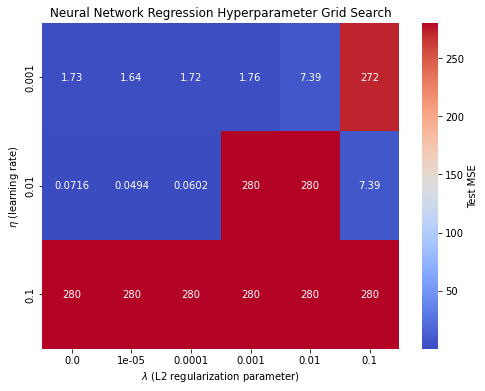

In [25]:
fig,ax = plt.subplots(figsize=(8,6))

sns.heatmap(nn_reg_grid, annot=True, cmap='coolwarm', fmt='.3g', cbar_kws={'label': 'Test MSE'})
ax.set_xticklabels(lmbdas.round(5))
ax.set_yticklabels(etas.round(5))
ax.set_ylabel("$\\eta$ (learning rate)")
ax.set_xlabel("$\\lambda$ (L2 regularization parameter)")
ax.set_title('Neural Network Regression Hyperparameter Grid Search')
fig.savefig('regression_nn_scratch_grid_search.jpg', dpi=1000, bbox_inches='tight')

### train this best model to 7500 epochs to reach lower error

In [26]:
npoints = 100
np.random.seed(1)
x = 3*np.random.rand(npoints,1)
y = 4 + 3*x + 2*x**2

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

train = list(zip(X_train[:,0], y_train[:,0]))
test = list(zip(X_test[:,0], y_test[:,0]))

activ_funcs = ['relu', 'relu']
net_relu = neural_network([1, 50, 1], activ_funcs, 'regression', lmbda=1e-5)

data_size = len(train)
n_epochs = 7500
eta = 0.01
test_mse_scratch_relu = net_relu.SGD(train, test, n_epochs, data_size, eta)

Epoch 0: 254.6494598388672
Epoch 1: 209.47119140625
Epoch 2: 133.62454223632812
Epoch 3: 43.59424591064453
Epoch 4: 3.6892261505126953
Epoch 5: 3.399965286254883
Epoch 6: 3.063518762588501
Epoch 7: 3.0290346145629883
Epoch 8: 2.9506490230560303
Epoch 9: 2.885368824005127
Epoch 10: 2.822803020477295
Epoch 11: 2.76442551612854
Epoch 12: 2.7096924781799316
Epoch 13: 2.658154249191284
Epoch 14: 2.609743118286133
Epoch 15: 2.5643863677978516
Epoch 16: 2.521803379058838
Epoch 17: 2.481815814971924
Epoch 18: 2.4442567825317383
Epoch 19: 2.4089765548706055
Epoch 20: 2.375760316848755
Epoch 21: 2.343963623046875
Epoch 22: 2.314422130584717
Epoch 23: 2.286591053009033
Epoch 24: 2.2604026794433594
Epoch 25: 2.235447645187378
Epoch 26: 2.21217679977417
Epoch 27: 2.1902003288269043
Epoch 28: 2.169484853744507
Epoch 29: 2.149958848953247
Epoch 30: 2.1315369606018066
Epoch 31: 2.1140713691711426
Epoch 32: 2.0972814559936523
Epoch 33: 2.081599473953247
Epoch 34: 2.0667672157287598
Epoch 35: 2.05277204

Epoch 296: 0.8059126138687134
Epoch 297: 0.8018757700920105
Epoch 298: 0.7978895902633667
Epoch 299: 0.7938910126686096
Epoch 300: 0.7899173498153687
Epoch 301: 0.785962700843811
Epoch 302: 0.782018780708313
Epoch 303: 0.7780860066413879
Epoch 304: 0.7741778492927551
Epoch 305: 0.7702747583389282
Epoch 306: 0.7663888335227966
Epoch 307: 0.7625222206115723
Epoch 308: 0.7586652040481567
Epoch 309: 0.754819929599762
Epoch 310: 0.7510055899620056
Epoch 311: 0.7474256157875061
Epoch 312: 0.7433596849441528
Epoch 313: 0.7401208877563477
Epoch 314: 0.7358077168464661
Epoch 315: 0.7324429750442505
Epoch 316: 0.72862708568573
Epoch 317: 0.7249624729156494
Epoch 318: 0.721276044845581
Epoch 319: 0.7176080346107483
Epoch 320: 0.7137340307235718
Epoch 321: 0.7105751037597656
Epoch 322: 0.7071157097816467
Epoch 323: 0.7039770483970642
Epoch 324: 0.6999412775039673
Epoch 325: 0.6970042586326599
Epoch 326: 0.6929579973220825
Epoch 327: 0.6900492906570435
Epoch 328: 0.6863382458686829
Epoch 329: 0.682

Epoch 588: 0.20126469433307648
Epoch 589: 0.2004089653491974
Epoch 590: 0.19955959916114807
Epoch 591: 0.1987169086933136
Epoch 592: 0.1978815346956253
Epoch 593: 0.19705016911029816
Epoch 594: 0.19622914493083954
Epoch 595: 0.19541093707084656
Epoch 596: 0.1946021020412445
Epoch 597: 0.19379815459251404
Epoch 598: 0.1930014193058014
Epoch 599: 0.1922110617160797
Epoch 600: 0.1914258897304535
Epoch 601: 0.1906489133834839
Epoch 602: 0.1898771971464157
Epoch 603: 0.1891123205423355
Epoch 604: 0.18835310637950897
Epoch 605: 0.18760065734386444
Epoch 606: 0.18685415387153625
Epoch 607: 0.18611449003219604
Epoch 608: 0.18537963926792145
Epoch 609: 0.18465299904346466
Epoch 610: 0.18393181264400482
Epoch 611: 0.18321581184864044
Epoch 612: 0.18250663578510284
Epoch 613: 0.18180380761623383
Epoch 614: 0.18110711872577667
Epoch 615: 0.18041516840457916
Epoch 616: 0.17973029613494873
Epoch 617: 0.17855419218540192
Epoch 618: 0.17798063158988953
Epoch 619: 0.1771869957447052
Epoch 620: 0.176487

Epoch 879: 0.0928439050912857
Epoch 880: 0.09281161427497864
Epoch 881: 0.0927802175283432
Epoch 882: 0.09274918586015701
Epoch 883: 0.09271981567144394
Epoch 884: 0.09269080311059952
Epoch 885: 0.09266303479671478
Epoch 886: 0.09263564646244049
Epoch 887: 0.09260953962802887
Epoch 888: 0.09258393943309784
Epoch 889: 0.09255905449390411
Epoch 890: 0.09253572672605515
Epoch 891: 0.09251277148723602
Epoch 892: 0.09249049425125122
Epoch 893: 0.09246911108493805
Epoch 894: 0.09244855493307114
Epoch 895: 0.09242867678403854
Epoch 896: 0.09240979701280594
Epoch 897: 0.09239159524440765
Epoch 898: 0.09237400442361832
Epoch 899: 0.092357337474823
Epoch 900: 0.0923413410782814
Epoch 901: 0.09232642501592636
Epoch 902: 0.09231166541576385
Epoch 903: 0.09229634702205658
Epoch 904: 0.09228188544511795
Epoch 905: 0.09226766973733902
Epoch 906: 0.09225477278232574
Epoch 907: 0.09224186837673187
Epoch 908: 0.09222979098558426
Epoch 909: 0.09221836179494858
Epoch 910: 0.09220822155475616
Epoch 911: 0.

Epoch 1144: 0.09179351478815079
Epoch 1145: 0.09179629385471344
Epoch 1146: 0.09179968386888504
Epoch 1147: 0.0918034240603447
Epoch 1148: 0.09180848300457001
Epoch 1149: 0.09181404858827591
Epoch 1150: 0.0918201208114624
Epoch 1151: 0.09182684868574142
Epoch 1152: 0.09183410555124283
Epoch 1153: 0.09184179455041885
Epoch 1154: 0.09185007959604263
Epoch 1155: 0.09185868501663208
Epoch 1156: 0.09186898171901703
Epoch 1157: 0.09187953174114227
Epoch 1158: 0.09189058840274811
Epoch 1159: 0.09190185368061066
Epoch 1160: 0.09191478788852692
Epoch 1161: 0.09192896634340286
Epoch 1162: 0.09194370359182358
Epoch 1163: 0.09195928275585175
Epoch 1164: 0.09197525680065155
Epoch 1165: 0.09199114888906479
Epoch 1166: 0.0920078307390213
Epoch 1167: 0.09202460199594498
Epoch 1168: 0.09204234182834625
Epoch 1169: 0.09205962717533112
Epoch 1170: 0.09207760542631149
Epoch 1171: 0.0920955091714859
Epoch 1172: 0.09211410582065582
Epoch 1173: 0.09213238954544067
Epoch 1174: 0.09215155988931656
Epoch 1175: 

Epoch 1413: 0.05282701179385185
Epoch 1414: 0.05252423882484436
Epoch 1415: 0.052228283137083054
Epoch 1416: 0.051938772201538086
Epoch 1417: 0.05165579915046692
Epoch 1418: 0.05137886852025986
Epoch 1419: 0.051107823848724365
Epoch 1420: 0.05084272101521492
Epoch 1421: 0.05058317258954048
Epoch 1422: 0.05032931640744209
Epoch 1423: 0.05008091777563095
Epoch 1424: 0.04983765631914139
Epoch 1425: 0.049599386751651764
Epoch 1426: 0.0493662990629673
Epoch 1427: 0.04913809895515442
Epoch 1428: 0.04891466349363327
Epoch 1429: 0.04869585856795311
Epoch 1430: 0.04848157614469528
Epoch 1431: 0.04827176034450531
Epoch 1432: 0.04806619882583618
Epoch 1433: 0.04786491394042969
Epoch 1434: 0.04766765236854553
Epoch 1435: 0.04747433215379715
Epoch 1436: 0.04728338122367859
Epoch 1437: 0.04709518700838089
Epoch 1438: 0.04691080003976822
Epoch 1439: 0.04673021286725998
Epoch 1440: 0.04655333608388901
Epoch 1441: 0.04637986794114113
Epoch 1442: 0.04621005058288574
Epoch 1443: 0.04604308307170868
Epoch

Epoch 1676: 0.03209449723362923
Epoch 1677: 0.03201659768819809
Epoch 1678: 0.031902920454740524
Epoch 1679: 0.03180985897779465
Epoch 1680: 0.03170838952064514
Epoch 1681: 0.031613126397132874
Epoch 1682: 0.031516674906015396
Epoch 1683: 0.031423069536685944
Epoch 1684: 0.031329862773418427
Epoch 1685: 0.031238457188010216
Epoch 1686: 0.031147703528404236
Epoch 1687: 0.03105875477194786
Epoch 1688: 0.030970430001616478
Epoch 1689: 0.03088345006108284
Epoch 1690: 0.030797675251960754
Epoch 1691: 0.03076815977692604
Epoch 1692: 0.03067472204566002
Epoch 1693: 0.030524108558893204
Epoch 1694: 0.03040802851319313
Epoch 1695: 0.030278289690613747
Epoch 1696: 0.03015991672873497
Epoch 1697: 0.030039500445127487
Epoch 1698: 0.02992430329322815
Epoch 1699: 0.029810121282935143
Epoch 1700: 0.029698902741074562
Epoch 1701: 0.029589775949716568
Epoch 1702: 0.029482897371053696
Epoch 1703: 0.02937786653637886
Epoch 1704: 0.029275059700012207
Epoch 1705: 0.029174158349633217
Epoch 1706: 0.02907474

Epoch 1944: 0.015564888715744019
Epoch 1945: 0.015539336018264294
Epoch 1946: 0.015514194965362549
Epoch 1947: 0.015488843433558941
Epoch 1948: 0.015463868156075478
Epoch 1949: 0.015438978560268879
Epoch 1950: 0.015414653345942497
Epoch 1951: 0.015390406362712383
Epoch 1952: 0.01536627858877182
Epoch 1953: 0.01534239947795868
Epoch 1954: 0.015318569727241993
Epoch 1955: 0.015294726006686687
Epoch 1956: 0.015271008014678955
Epoch 1957: 0.015247529372572899
Epoch 1958: 0.01522399764508009
Epoch 1959: 0.015200808644294739
Epoch 1960: 0.015177411958575249
Epoch 1961: 0.015154419466853142
Epoch 1962: 0.015131424181163311
Epoch 1963: 0.015108632855117321
Epoch 1964: 0.015085667371749878
Epoch 1965: 0.01506304182112217
Epoch 1966: 0.015040460042655468
Epoch 1967: 0.015017494559288025
Epoch 1968: 0.0149950310587883
Epoch 1969: 0.014972682110965252
Epoch 1970: 0.014950385317206383
Epoch 1971: 0.014928257092833519
Epoch 1972: 0.014906270429491997
Epoch 1973: 0.014884253032505512
Epoch 1974: 0.01

Epoch 2210: 0.011660253629088402
Epoch 2211: 0.011651763692498207
Epoch 2212: 0.01164298877120018
Epoch 2213: 0.011634585447609425
Epoch 2214: 0.011625981889665127
Epoch 2215: 0.011617667973041534
Epoch 2216: 0.011608955450356007
Epoch 2217: 0.011600932106375694
Epoch 2218: 0.011593369767069817
Epoch 2219: 0.011585617437958717
Epoch 2220: 0.011578149162232876
Epoch 2221: 0.011570325121283531
Epoch 2222: 0.011563032865524292
Epoch 2223: 0.011555301956832409
Epoch 2224: 0.011547866277396679
Epoch 2225: 0.011540270410478115
Epoch 2226: 0.011532883159816265
Epoch 2227: 0.011525450274348259
Epoch 2228: 0.011517975479364395
Epoch 2229: 0.011510561220347881
Epoch 2230: 0.01150327268987894
Epoch 2231: 0.011495823040604591
Epoch 2232: 0.011488496325910091
Epoch 2233: 0.01148095540702343
Epoch 2234: 0.011473733931779861
Epoch 2235: 0.011466434225440025
Epoch 2236: 0.01145961694419384
Epoch 2237: 0.011452936567366123
Epoch 2238: 0.011446593329310417
Epoch 2239: 0.011443661525845528
Epoch 2240: 0.

Epoch 2474: 0.010302269831299782
Epoch 2475: 0.010297821834683418
Epoch 2476: 0.010293200612068176
Epoch 2477: 0.010288997553288937
Epoch 2478: 0.01028442196547985
Epoch 2479: 0.01027999259531498
Epoch 2480: 0.010275638662278652
Epoch 2481: 0.010271282866597176
Epoch 2482: 0.0102669233456254
Epoch 2483: 0.010262509807944298
Epoch 2484: 0.010258248075842857
Epoch 2485: 0.010253708809614182
Epoch 2486: 0.010249500162899494
Epoch 2487: 0.010244956240057945
Epoch 2488: 0.010240839794278145
Epoch 2489: 0.010236398316919804
Epoch 2490: 0.010232123546302319
Epoch 2491: 0.010227708145976067
Epoch 2492: 0.010223506018519402
Epoch 2493: 0.01021905429661274
Epoch 2494: 0.010214941576123238
Epoch 2495: 0.010210433974862099
Epoch 2496: 0.010206314735114574
Epoch 2497: 0.010201877914369106
Epoch 2498: 0.01019770372658968
Epoch 2499: 0.010193480178713799
Epoch 2500: 0.01018910575658083
Epoch 2501: 0.01018491480499506
Epoch 2502: 0.01018056832253933
Epoch 2503: 0.010176366195082664
Epoch 2504: 0.01017

Epoch 2742: 0.009307118132710457
Epoch 2743: 0.009304666891694069
Epoch 2744: 0.009302301332354546
Epoch 2745: 0.009299829602241516
Epoch 2746: 0.009297618642449379
Epoch 2747: 0.009295360185205936
Epoch 2748: 0.009292944334447384
Epoch 2749: 0.009290719404816628
Epoch 2750: 0.009288409724831581
Epoch 2751: 0.009286350570619106
Epoch 2752: 0.009284043684601784
Epoch 2753: 0.009281927719712257
Epoch 2754: 0.009279871359467506
Epoch 2755: 0.009277612902224064
Epoch 2756: 0.009275689721107483
Epoch 2757: 0.009273375384509563
Epoch 2758: 0.009271296672523022
Epoch 2759: 0.009269260801374912
Epoch 2760: 0.009267045184969902
Epoch 2761: 0.009265071712434292
Epoch 2762: 0.00926278904080391
Epoch 2763: 0.00926080159842968
Epoch 2764: 0.00925878994166851
Epoch 2765: 0.0092566953971982
Epoch 2766: 0.009254618547856808
Epoch 2767: 0.009252647869288921
Epoch 2768: 0.009250456467270851
Epoch 2769: 0.009248635731637478
Epoch 2770: 0.009246418252587318
Epoch 2771: 0.00924438051879406
Epoch 2772: 0.00

Epoch 3004: 0.008627745322883129
Epoch 3005: 0.008625103160738945
Epoch 3006: 0.00862268079072237
Epoch 3007: 0.008619951084256172
Epoch 3008: 0.008617544546723366
Epoch 3009: 0.008614908903837204
Epoch 3010: 0.008612456731498241
Epoch 3011: 0.008609617128968239
Epoch 3012: 0.008607250638306141
Epoch 3013: 0.008604606613516808
Epoch 3014: 0.008602126501500607
Epoch 3015: 0.008599492721259594
Epoch 3016: 0.008596927858889103
Epoch 3017: 0.008594374172389507
Epoch 3018: 0.00859192106872797
Epoch 3019: 0.008589142933487892
Epoch 3020: 0.008586863055825233
Epoch 3021: 0.008584069088101387
Epoch 3022: 0.008581701666116714
Epoch 3023: 0.008578993380069733
Epoch 3024: 0.00857654307037592
Epoch 3025: 0.008573899045586586
Epoch 3026: 0.008571463637053967
Epoch 3027: 0.008568824268877506
Epoch 3028: 0.008566425181925297
Epoch 3029: 0.008563719689846039
Epoch 3030: 0.008561292663216591
Epoch 3031: 0.008558601140975952
Epoch 3032: 0.008556130342185497
Epoch 3033: 0.008553554303944111
Epoch 3034: 0

Epoch 3262: 0.008170017041265965
Epoch 3263: 0.008169530890882015
Epoch 3264: 0.008168818429112434
Epoch 3265: 0.008168297819793224
Epoch 3266: 0.008167699910700321
Epoch 3267: 0.008167109452188015
Epoch 3268: 0.008166613057255745
Epoch 3269: 0.008165916427969933
Epoch 3270: 0.008165317587554455
Epoch 3271: 0.008164742961525917
Epoch 3272: 0.008164236322045326
Epoch 3273: 0.008163558319211006
Epoch 3274: 0.00816296972334385
Epoch 3275: 0.008162543177604675
Epoch 3276: 0.008161931298673153
Epoch 3277: 0.008161297999322414
Epoch 3278: 0.008160782977938652
Epoch 3279: 0.008160283789038658
Epoch 3280: 0.008159758523106575
Epoch 3281: 0.008159237913787365
Epoch 3282: 0.008158612065017223
Epoch 3283: 0.008158206008374691
Epoch 3284: 0.008157532662153244
Epoch 3285: 0.008157039061188698
Epoch 3286: 0.008156562224030495
Epoch 3287: 0.008156051859259605
Epoch 3288: 0.00815566349774599
Epoch 3289: 0.008155182003974915
Epoch 3290: 0.00815470889210701
Epoch 3291: 0.008154181763529778
Epoch 3292: 0

Epoch 3524: 0.008095362223684788
Epoch 3525: 0.008095349185168743
Epoch 3526: 0.008095232769846916
Epoch 3527: 0.008095236495137215
Epoch 3528: 0.008095103316009045
Epoch 3529: 0.008095013909041882
Epoch 3530: 0.008094999007880688
Epoch 3531: 0.008094994351267815
Epoch 3532: 0.008094779215753078
Epoch 3533: 0.008094887249171734
Epoch 3534: 0.008094768971204758
Epoch 3535: 0.008094679564237595
Epoch 3536: 0.008094665594398975
Epoch 3537: 0.008094588294625282
Epoch 3538: 0.008094524964690208
Epoch 3539: 0.008094573393464088
Epoch 3540: 0.008094417862594128
Epoch 3541: 0.008094361051917076
Epoch 3542: 0.008094402961432934
Epoch 3543: 0.008094333112239838
Epoch 3544: 0.008094151504337788
Epoch 3545: 0.008094236254692078
Epoch 3546: 0.008094160817563534
Epoch 3547: 0.00809408538043499
Epoch 3548: 0.008094139397144318
Epoch 3549: 0.008094031363725662
Epoch 3550: 0.008093954995274544
Epoch 3551: 0.008094040676951408
Epoch 3552: 0.008093839511275291
Epoch 3553: 0.00809390377253294
Epoch 3554: 

Epoch 3787: 0.008047678507864475
Epoch 3788: 0.008039946667850018
Epoch 3789: 0.008046348579227924
Epoch 3790: 0.008042687550187111
Epoch 3791: 0.008039301261305809
Epoch 3792: 0.008041066117584705
Epoch 3793: 0.00803485605865717
Epoch 3794: 0.008038315922021866
Epoch 3795: 0.008031463250517845
Epoch 3796: 0.008035337552428246
Epoch 3797: 0.008028298616409302
Epoch 3798: 0.00803402066230774
Epoch 3799: 0.008031772449612617
Epoch 3800: 0.008027259260416031
Epoch 3801: 0.008030603639781475
Epoch 3802: 0.008023098111152649
Epoch 3803: 0.008028136566281319
Epoch 3804: 0.008019932545721531
Epoch 3805: 0.008025432005524635
Epoch 3806: 0.008017091080546379
Epoch 3807: 0.00802271906286478
Epoch 3808: 0.008014324121177197
Epoch 3809: 0.00802009180188179
Epoch 3810: 0.008011745288968086
Epoch 3811: 0.008017686195671558
Epoch 3812: 0.008009146898984909
Epoch 3813: 0.008015135303139687
Epoch 3814: 0.008006678894162178
Epoch 3815: 0.008014335297048092
Epoch 3816: 0.00801061000674963
Epoch 3817: 0.0

Epoch 4051: 0.00785919465124607
Epoch 4052: 0.007864335551857948
Epoch 4053: 0.007857685908675194
Epoch 4054: 0.007858466356992722
Epoch 4055: 0.007860899902880192
Epoch 4056: 0.00785466842353344
Epoch 4057: 0.00785759836435318
Epoch 4058: 0.007848267443478107
Epoch 4059: 0.007846806198358536
Epoch 4060: 0.007847175002098083
Epoch 4061: 0.007840500213205814
Epoch 4062: 0.007843331433832645
Epoch 4063: 0.00783381424844265
Epoch 4064: 0.00783229898661375
Epoch 4065: 0.007832572795450687
Epoch 4066: 0.007825731299817562
Epoch 4067: 0.007828553207218647
Epoch 4068: 0.007820511236786842
Epoch 4069: 0.007823824882507324
Epoch 4070: 0.007814029231667519
Epoch 4071: 0.007812770083546638
Epoch 4072: 0.007813241332769394
Epoch 4073: 0.007806810550391674
Epoch 4074: 0.007809802889823914
Epoch 4075: 0.007800658233463764
Epoch 4076: 0.007799264043569565
Epoch 4077: 0.007799901068210602
Epoch 4078: 0.007793407887220383
Epoch 4079: 0.007796590216457844
Epoch 4080: 0.007788618095219135
Epoch 4081: 0.0

Epoch 4318: 0.00736292963847518
Epoch 4319: 0.007362923119217157
Epoch 4320: 0.007360388524830341
Epoch 4321: 0.007359192706644535
Epoch 4322: 0.0073574259877204895
Epoch 4323: 0.007355923764407635
Epoch 4324: 0.007354401983320713
Epoch 4325: 0.00735281640663743
Epoch 4326: 0.007351399399340153
Epoch 4327: 0.0073499358259141445
Epoch 4328: 0.007348486687988043
Epoch 4329: 0.007347152568399906
Epoch 4330: 0.00734565407037735
Epoch 4331: 0.007344409823417664
Epoch 4332: 0.007342841476202011
Epoch 4333: 0.007341546472162008
Epoch 4334: 0.007340122014284134
Epoch 4335: 0.00733890850096941
Epoch 4336: 0.007337538059800863
Epoch 4337: 0.007336225360631943
Epoch 4338: 0.007334927562624216
Epoch 4339: 0.00733353802934289
Epoch 4340: 0.00733228912577033
Epoch 4341: 0.007329998072236776
Epoch 4342: 0.007328994572162628
Epoch 4343: 0.007327544502913952
Epoch 4344: 0.007326517254114151
Epoch 4345: 0.007325213402509689
Epoch 4346: 0.0073241181671619415
Epoch 4347: 0.007321682758629322
Epoch 4348: 0

Epoch 4583: 0.007134201470762491
Epoch 4584: 0.00712841609492898
Epoch 4585: 0.007130297366529703
Epoch 4586: 0.007128407713025808
Epoch 4587: 0.007126202341169119
Epoch 4588: 0.007131566293537617
Epoch 4589: 0.007127778138965368
Epoch 4590: 0.007127601653337479
Epoch 4591: 0.0071263983845710754
Epoch 4592: 0.007123742252588272
Epoch 4593: 0.007129445672035217
Epoch 4594: 0.007125518284738064
Epoch 4595: 0.007126475218683481
Epoch 4596: 0.0071214595809578896
Epoch 4597: 0.007128051482141018
Epoch 4598: 0.007123530842363834
Epoch 4599: 0.007124916650354862
Epoch 4600: 0.007123345043510199
Epoch 4601: 0.00711954478174448
Epoch 4602: 0.0071254633367061615
Epoch 4603: 0.007121393922716379
Epoch 4604: 0.0071224733255803585
Epoch 4605: 0.00711858132854104
Epoch 4606: 0.007124991621822119
Epoch 4607: 0.007119211368262768
Epoch 4608: 0.007120977155864239
Epoch 4609: 0.007116757333278656
Epoch 4610: 0.007123137358576059
Epoch 4611: 0.007118777837604284
Epoch 4612: 0.0071198767982423306
Epoch 46

Epoch 4846: 0.007041309028863907
Epoch 4847: 0.007032169960439205
Epoch 4848: 0.0070338174700737
Epoch 4849: 0.0070321992971003056
Epoch 4850: 0.007029912434518337
Epoch 4851: 0.007035291753709316
Epoch 4852: 0.007029234431684017
Epoch 4853: 0.007035115268081427
Epoch 4854: 0.007021605968475342
Epoch 4855: 0.007033010479062796
Epoch 4856: 0.00702619319781661
Epoch 4857: 0.007026442792266607
Epoch 4858: 0.007029276341199875
Epoch 4859: 0.007017428521066904
Epoch 4860: 0.007028060499578714
Epoch 4861: 0.007019504904747009
Epoch 4862: 0.00702826539054513
Epoch 4863: 0.00701905507594347
Epoch 4864: 0.007021058350801468
Epoch 4865: 0.0070192767307162285
Epoch 4866: 0.007017192896455526
Epoch 4867: 0.007022748701274395
Epoch 4868: 0.00701533118262887
Epoch 4869: 0.007016453891992569
Epoch 4870: 0.0070129455998539925
Epoch 4871: 0.007019233889877796
Epoch 4872: 0.007011552806943655
Epoch 4873: 0.007012850139290094
Epoch 4874: 0.007011622190475464
Epoch 4875: 0.007009369321167469
Epoch 4876: 0

Epoch 5108: 0.006839381065219641
Epoch 5109: 0.006827355828136206
Epoch 5110: 0.006838907953351736
Epoch 5111: 0.006829805672168732
Epoch 5112: 0.006830967962741852
Epoch 5113: 0.0068321749567985535
Epoch 5114: 0.006829909048974514
Epoch 5115: 0.006828381214290857
Epoch 5116: 0.006825490389019251
Epoch 5117: 0.0068324534222483635
Epoch 5118: 0.00682580703869462
Epoch 5119: 0.006825468502938747
Epoch 5120: 0.006829873658716679
Epoch 5121: 0.006819045636802912
Epoch 5122: 0.0068267895840108395
Epoch 5123: 0.006821229122579098
Epoch 5124: 0.006821631453931332
Epoch 5125: 0.0068177892826497555
Epoch 5126: 0.006825248245149851
Epoch 5127: 0.00681850453838706
Epoch 5128: 0.0068184612318873405
Epoch 5129: 0.006820493843406439
Epoch 5130: 0.0068177832290530205
Epoch 5131: 0.0068165636621415615
Epoch 5132: 0.006813523825258017
Epoch 5133: 0.006820667535066605
Epoch 5134: 0.0068139322102069855
Epoch 5135: 0.006813795305788517
Epoch 5136: 0.006818150635808706
Epoch 5137: 0.006807343568652868
Epoc

Epoch 5372: 0.0066472613252699375
Epoch 5373: 0.006641692481935024
Epoch 5374: 0.0066421665251255035
Epoch 5375: 0.006647015456110239
Epoch 5376: 0.0066373273730278015
Epoch 5377: 0.006645590998232365
Epoch 5378: 0.00663747126236558
Epoch 5379: 0.006639484316110611
Epoch 5380: 0.006641474552452564
Epoch 5381: 0.006636855658143759
Epoch 5382: 0.006638776510953903
Epoch 5383: 0.006636215839534998
Epoch 5384: 0.006635199300944805
Epoch 5385: 0.006638912949711084
Epoch 5386: 0.0066334218718111515
Epoch 5387: 0.00663367286324501
Epoch 5388: 0.0066386014223098755
Epoch 5389: 0.006627948023378849
Epoch 5390: 0.006631406955420971
Epoch 5391: 0.006632826291024685
Epoch 5392: 0.006629626266658306
Epoch 5393: 0.006634407676756382
Epoch 5394: 0.006628260016441345
Epoch 5395: 0.006631115917116404
Epoch 5396: 0.006628057453781366
Epoch 5397: 0.006626182235777378
Epoch 5398: 0.006624923087656498
Epoch 5399: 0.006628802511841059
Epoch 5400: 0.006623406894505024
Epoch 5401: 0.006623809691518545
Epoch 5

Epoch 5638: 0.006481551565229893
Epoch 5639: 0.006476918701082468
Epoch 5640: 0.006476846523582935
Epoch 5641: 0.006475459784269333
Epoch 5642: 0.006479925476014614
Epoch 5643: 0.006474894937127829
Epoch 5644: 0.006474917288869619
Epoch 5645: 0.006473274435847998
Epoch 5646: 0.006477965507656336
Epoch 5647: 0.006472844630479813
Epoch 5648: 0.0064729624427855015
Epoch 5649: 0.006470383144915104
Epoch 5650: 0.006470208056271076
Epoch 5651: 0.006474153138697147
Epoch 5652: 0.0064694806933403015
Epoch 5653: 0.006469408981502056
Epoch 5654: 0.006467949599027634
Epoch 5655: 0.006472545675933361
Epoch 5656: 0.006467306520789862
Epoch 5657: 0.006467640399932861
Epoch 5658: 0.006466002203524113
Epoch 5659: 0.00647061038762331
Epoch 5660: 0.006465462502092123
Epoch 5661: 0.006465689279139042
Epoch 5662: 0.0064629255793988705
Epoch 5663: 0.006463031284511089
Epoch 5664: 0.006466823164373636
Epoch 5665: 0.006462174002081156
Epoch 5666: 0.006462243851274252
Epoch 5667: 0.006459840573370457
Epoch 56

Epoch 5904: 0.006324265152215958
Epoch 5905: 0.006322918925434351
Epoch 5906: 0.006322200410068035
Epoch 5907: 0.0063218227587640285
Epoch 5908: 0.006326477974653244
Epoch 5909: 0.006322184111922979
Epoch 5910: 0.0063227140344679356
Epoch 5911: 0.006320717744529247
Epoch 5912: 0.006320230662822723
Epoch 5913: 0.006318724248558283
Epoch 5914: 0.006317984312772751
Epoch 5915: 0.006317882798612118
Epoch 5916: 0.006322572939097881
Epoch 5917: 0.006318115629255772
Epoch 5918: 0.006318810395896435
Epoch 5919: 0.006316536106169224
Epoch 5920: 0.006316120736300945
Epoch 5921: 0.006314908154308796
Epoch 5922: 0.006314003374427557
Epoch 5923: 0.0063129812479019165
Epoch 5924: 0.006312955170869827
Epoch 5925: 0.006317471154034138
Epoch 5926: 0.006313278339803219
Epoch 5927: 0.006313814781606197
Epoch 5928: 0.006311929784715176
Epoch 5929: 0.006311284843832254
Epoch 5930: 0.0063101379200816154
Epoch 5931: 0.006309120450168848
Epoch 5932: 0.006308234296739101
Epoch 5933: 0.006308188196271658
Epoch 

Epoch 6171: 0.006091094575822353
Epoch 6172: 0.006088886875659227
Epoch 6173: 0.00608682818710804
Epoch 6174: 0.0060847457498312
Epoch 6175: 0.0060826875269412994
Epoch 6176: 0.006080716382712126
Epoch 6177: 0.0060786111280322075
Epoch 6178: 0.006076606456190348
Epoch 6179: 0.006067480891942978
Epoch 6180: 0.006093233823776245
Epoch 6181: 0.006098799407482147
Epoch 6182: 0.006111592054367065
Epoch 6183: 0.006118605844676495
Epoch 6184: 0.006126352585852146
Epoch 6185: 0.00613193865865469
Epoch 6186: 0.006136910058557987
Epoch 6187: 0.0061407508328557014
Epoch 6188: 0.006144045852124691
Epoch 6189: 0.006146310828626156
Epoch 6190: 0.006148240994662046
Epoch 6191: 0.006149312946945429
Epoch 6192: 0.00615015858784318
Epoch 6193: 0.006150377448648214
Epoch 6194: 0.006150398403406143
Epoch 6195: 0.006150010973215103
Epoch 6196: 0.006149348337203264
Epoch 6197: 0.006148319225758314
Epoch 6198: 0.006147114094346762
Epoch 6199: 0.006145640276372433
Epoch 6200: 0.006144097540527582
Epoch 6201: 

Epoch 6438: 0.005777486599981785
Epoch 6439: 0.0057788388803601265
Epoch 6440: 0.005775408819317818
Epoch 6441: 0.005774274468421936
Epoch 6442: 0.005776543170213699
Epoch 6443: 0.005771726835519075
Epoch 6444: 0.005771148018538952
Epoch 6445: 0.0057732779532670975
Epoch 6446: 0.00576868187636137
Epoch 6447: 0.005769123323261738
Epoch 6448: 0.005769764538854361
Epoch 6449: 0.005766700021922588
Epoch 6450: 0.005765505135059357
Epoch 6451: 0.00576673774048686
Epoch 6452: 0.005763453897088766
Epoch 6453: 0.005761780776083469
Epoch 6454: 0.005760968662798405
Epoch 6455: 0.00576236704364419
Epoch 6456: 0.005758076440542936
Epoch 6457: 0.005758613348007202
Epoch 6458: 0.005759368184953928
Epoch 6459: 0.0057564424350857735
Epoch 6460: 0.005755306221544743
Epoch 6461: 0.005756695754826069
Epoch 6462: 0.00575351482257247
Epoch 6463: 0.005751823540776968
Epoch 6464: 0.005751105956733227
Epoch 6465: 0.005752617958933115
Epoch 6466: 0.005749464966356754
Epoch 6467: 0.005748528055846691
Epoch 6468:

Epoch 6703: 0.005565464962273836
Epoch 6704: 0.005565541796386242
Epoch 6705: 0.005564271938055754
Epoch 6706: 0.005564567632973194
Epoch 6707: 0.005563286133110523
Epoch 6708: 0.005563517566770315
Epoch 6709: 0.005562181584537029
Epoch 6710: 0.005561454221606255
Epoch 6711: 0.005561538506299257
Epoch 6712: 0.005560324061661959
Epoch 6713: 0.005560585297644138
Epoch 6714: 0.005559269804507494
Epoch 6715: 0.00555846793577075
Epoch 6716: 0.005558650009334087
Epoch 6717: 0.005557423923164606
Epoch 6718: 0.005557614378631115
Epoch 6719: 0.005556429736316204
Epoch 6720: 0.0055567240342497826
Epoch 6721: 0.005555407609790564
Epoch 6722: 0.005554683040827513
Epoch 6723: 0.0055547901429235935
Epoch 6724: 0.005553580354899168
Epoch 6725: 0.005553865805268288
Epoch 6726: 0.005552547983825207
Epoch 6727: 0.005552732851356268
Epoch 6728: 0.005551502108573914
Epoch 6729: 0.005550789646804333
Epoch 6730: 0.005550780333578587
Epoch 6731: 0.005549686960875988
Epoch 6732: 0.005549931433051825
Epoch 673

Epoch 6969: 0.005436193663626909
Epoch 6970: 0.005435163155198097
Epoch 6971: 0.005435571074485779
Epoch 6972: 0.005434483755379915
Epoch 6973: 0.0054347943514585495
Epoch 6974: 0.005433602724224329
Epoch 6975: 0.00543390354141593
Epoch 6976: 0.0054328260011971
Epoch 6977: 0.005433185957372189
Epoch 6978: 0.00543194729834795
Epoch 6979: 0.005431392230093479
Epoch 6980: 0.005431465804576874
Epoch 6981: 0.00543056707829237
Epoch 6982: 0.005430872086435556
Epoch 6983: 0.005429673939943314
Epoch 6984: 0.005430093966424465
Epoch 6985: 0.005428835283964872
Epoch 6986: 0.005429345183074474
Epoch 6987: 0.005428120493888855
Epoch 6988: 0.00542841199785471
Epoch 6989: 0.005427303723990917
Epoch 6990: 0.005426663905382156
Epoch 6991: 0.005426869262009859
Epoch 6992: 0.005425707437098026
Epoch 6993: 0.0054260725155472755
Epoch 6994: 0.005424988456070423
Epoch 6995: 0.005425301380455494
Epoch 6996: 0.005424161907285452
Epoch 6997: 0.005424559116363525
Epoch 6998: 0.005423298105597496
Epoch 6999: 0.

Epoch 7232: 0.005277669057250023
Epoch 7233: 0.005276120267808437
Epoch 7234: 0.00527367414906621
Epoch 7235: 0.005276042502373457
Epoch 7236: 0.005274781957268715
Epoch 7237: 0.00527228182181716
Epoch 7238: 0.005271769128739834
Epoch 7239: 0.005275187082588673
Epoch 7240: 0.005266290158033371
Epoch 7241: 0.005273188464343548
Epoch 7242: 0.0052698333747684956
Epoch 7243: 0.005268312059342861
Epoch 7244: 0.005270322319120169
Epoch 7245: 0.005270211957395077
Epoch 7246: 0.005266389809548855
Epoch 7247: 0.00526646850630641
Epoch 7248: 0.005269709508866072
Epoch 7249: 0.005261855665594339
Epoch 7250: 0.005267535336315632
Epoch 7251: 0.005264595150947571
Epoch 7252: 0.005263890605419874
Epoch 7253: 0.005265677813440561
Epoch 7254: 0.005264630075544119
Epoch 7255: 0.0052613504230976105
Epoch 7256: 0.00526196975260973
Epoch 7257: 0.005265203770250082
Epoch 7258: 0.005256404634565115
Epoch 7259: 0.005264398641884327
Epoch 7260: 0.005254311021417379
Epoch 7261: 0.005261785350739956
Epoch 7262: 

Epoch 7497: 0.005136575549840927
Epoch 7498: 0.005137178581207991
Epoch 7499: 0.00513816112652421


C:\Users\owehuf\AppData\Local\Temp\ipykernel_1020\3613085993.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axins.set_xticklabels(range(6950, 7250, 50));


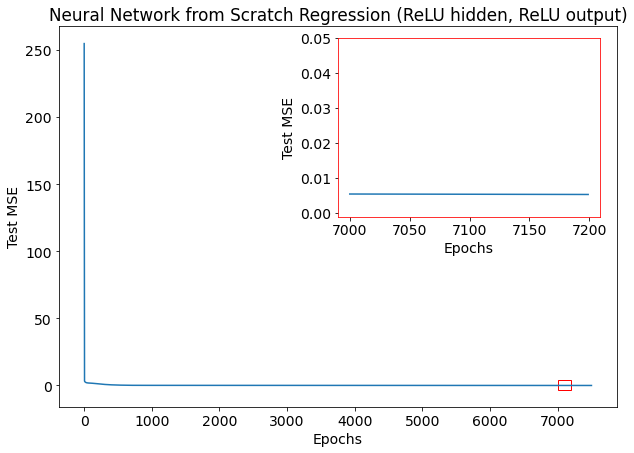

In [27]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(10,7))

ax.plot(test_mse_scratch_relu)
ax.set_ylabel('Test MSE')
ax.set_xlabel('Epochs')
rect = patches.Rectangle((7000, -3), 200, 7, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.set_title('Neural Network from Scratch Regression (ReLU hidden, ReLU output)')


axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47]);
axins.plot(test_mse_scratch_relu[7000:7200])
axins.set_xticklabels(range(6950, 7250, 50));
axins.set_ylabel('Test MSE')
axins.set_xlabel('Epochs')
axins.set_ylim(-0.001, 0.05)
plt.setp(axins.spines.values(), color='red');
fig.savefig('regression_nn_scratch_convergence.jpg', dpi=1000, bbox_inches='tight')

### Tensorflow (takes a few minutes to run)


In [28]:
set_seed(5)
model = Sequential([
Dense(50, activation='relu'),
Dense(1, activation='relu')
])
n_epochs = 7500
model.compile(loss=mse, optimizer=optimizers.SGD(learning_rate=eta), metrics=['mse'])

train_history = model.fit(X_train, y_train, epochs=n_epochs, validation_data=(X_test, y_test))



Epoch 1/7500
3/3 [==============================] - 0s 79ms/step - loss: 193.0242 - mse: 193.0242 - val_loss: 22.4143 - val_mse: 22.4143
Epoch 2/7500
3/3 [==============================] - 0s 12ms/step - loss: 11.8152 - mse: 11.8152 - val_loss: 2.9059 - val_mse: 2.9059
Epoch 3/7500
3/3 [==============================] - 0s 12ms/step - loss: 3.1288 - mse: 3.1288 - val_loss: 2.5830 - val_mse: 2.5830
Epoch 4/7500
3/3 [==============================] - 0s 12ms/step - loss: 2.8113 - mse: 2.8113 - val_loss: 2.1500 - val_mse: 2.1500
Epoch 5/7500
3/3 [==============================] - 0s 12ms/step - loss: 2.6680 - mse: 2.6680 - val_loss: 2.8606 - val_mse: 2.8606
Epoch 6/7500
3/3 [==============================] - 0s 11ms/step - loss: 2.4232 - mse: 2.4232 - val_loss: 3.2756 - val_mse: 3.2756
Epoch 7/7500
3/3 [==============================] - 0s 12ms/step - loss: 2.2872 - mse: 2.2872 - val_loss: 2.1591 - val_mse: 2.1591
Epoch 8/7500
3/3 [==============================] - 0s 11ms/step - loss: 2.

3/3 [==============================] - 0s 12ms/step - loss: 1.8461 - mse: 1.8461 - val_loss: 1.3422 - val_mse: 1.3422
Epoch 64/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.9658 - mse: 1.9658 - val_loss: 1.2659 - val_mse: 1.2659
Epoch 65/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.8296 - mse: 1.8296 - val_loss: 1.5119 - val_mse: 1.5119
Epoch 66/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.7899 - mse: 1.7899 - val_loss: 1.3300 - val_mse: 1.3300
Epoch 67/7500
3/3 [==============================] - 0s 11ms/step - loss: 1.7968 - mse: 1.7968 - val_loss: 1.2947 - val_mse: 1.2947
Epoch 68/7500
3/3 [==============================] - 0s 11ms/step - loss: 1.8476 - mse: 1.8476 - val_loss: 2.4540 - val_mse: 2.4540
Epoch 69/7500
3/3 [==============================] - 0s 12ms/step - loss: 2.0040 - mse: 2.0040 - val_loss: 2.8824 - val_mse: 2.8824
Epoch 70/7500
3/3 [==============================] - 0s 12ms/step - loss: 2.1483 - mse: 2.

Epoch 125/7500
3/3 [==============================] - 0s 11ms/step - loss: 1.3688 - mse: 1.3688 - val_loss: 1.2120 - val_mse: 1.2120
Epoch 126/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.4525 - mse: 1.4525 - val_loss: 1.4014 - val_mse: 1.4014
Epoch 127/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.3527 - mse: 1.3527 - val_loss: 1.2430 - val_mse: 1.2430
Epoch 128/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.4235 - mse: 1.4235 - val_loss: 1.0557 - val_mse: 1.0557
Epoch 129/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.3758 - mse: 1.3758 - val_loss: 1.2267 - val_mse: 1.2267
Epoch 130/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.6557 - mse: 1.6557 - val_loss: 1.4966 - val_mse: 1.4966
Epoch 131/7500
3/3 [==============================] - 0s 12ms/step - loss: 1.3533 - mse: 1.3533 - val_loss: 1.1410 - val_mse: 1.1410
Epoch 132/7500
3/3 [==============================] - 0s 12ms/step - 

3/3 [==============================] - 0s 12ms/step - loss: 0.9056 - mse: 0.9056 - val_loss: 0.8364 - val_mse: 0.8364
Epoch 187/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.8146 - mse: 0.8146 - val_loss: 0.9806 - val_mse: 0.9806
Epoch 188/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.8293 - mse: 0.8293 - val_loss: 0.7927 - val_mse: 0.7927
Epoch 189/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.7573 - mse: 0.7573 - val_loss: 0.8191 - val_mse: 0.8191
Epoch 190/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.7443 - mse: 0.7443 - val_loss: 0.7019 - val_mse: 0.7019
Epoch 191/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.7420 - mse: 0.7420 - val_loss: 0.5243 - val_mse: 0.5243
Epoch 192/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.8374 - mse: 0.8374 - val_loss: 0.5609 - val_mse: 0.5609
Epoch 193/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.7562 - 

Epoch 248/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.3621 - mse: 0.3621 - val_loss: 0.2463 - val_mse: 0.2463
Epoch 249/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.4002 - mse: 0.4002 - val_loss: 0.2449 - val_mse: 0.2449
Epoch 250/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.3613 - mse: 0.3613 - val_loss: 0.5270 - val_mse: 0.5270
Epoch 251/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.3549 - mse: 0.3549 - val_loss: 0.4355 - val_mse: 0.4355
Epoch 252/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.4006 - mse: 0.4006 - val_loss: 0.2382 - val_mse: 0.2382
Epoch 253/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.3383 - mse: 0.3383 - val_loss: 0.3107 - val_mse: 0.3107
Epoch 254/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.3275 - mse: 0.3275 - val_loss: 0.2594 - val_mse: 0.2594
Epoch 255/7500
3/3 [==============================] - 0s 12ms/step - 

3/3 [==============================] - 0s 11ms/step - loss: 0.2333 - mse: 0.2333 - val_loss: 0.1190 - val_mse: 0.1190
Epoch 310/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1713 - mse: 0.1713 - val_loss: 0.2934 - val_mse: 0.2934
Epoch 311/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1971 - mse: 0.1971 - val_loss: 0.3815 - val_mse: 0.3815
Epoch 312/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.2844 - mse: 0.2844 - val_loss: 0.1728 - val_mse: 0.1728
Epoch 313/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1845 - mse: 0.1845 - val_loss: 0.1224 - val_mse: 0.1224
Epoch 314/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.1981 - mse: 0.1981 - val_loss: 0.1570 - val_mse: 0.1570
Epoch 315/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.1813 - mse: 0.1813 - val_loss: 0.2404 - val_mse: 0.2404
Epoch 316/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.2082 - 

Epoch 371/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1155 - mse: 0.1155 - val_loss: 0.0898 - val_mse: 0.0898
Epoch 372/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1149 - mse: 0.1149 - val_loss: 0.1131 - val_mse: 0.1131
Epoch 373/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1173 - mse: 0.1173 - val_loss: 0.1272 - val_mse: 0.1272
Epoch 374/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1676 - mse: 0.1676 - val_loss: 0.0948 - val_mse: 0.0948
Epoch 375/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.1251 - mse: 0.1251 - val_loss: 0.0951 - val_mse: 0.0951
Epoch 376/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1130 - mse: 0.1130 - val_loss: 0.1103 - val_mse: 0.1103
Epoch 377/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1127 - mse: 0.1127 - val_loss: 0.1016 - val_mse: 0.1016
Epoch 378/7500
3/3 [==============================] - 0s 11ms/step - 

3/3 [==============================] - 0s 12ms/step - loss: 0.1157 - mse: 0.1157 - val_loss: 0.1184 - val_mse: 0.1184
Epoch 433/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1024 - mse: 0.1024 - val_loss: 0.1060 - val_mse: 0.1060
Epoch 434/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.1025 - mse: 0.1025 - val_loss: 0.1159 - val_mse: 0.1159
Epoch 435/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1058 - mse: 0.1058 - val_loss: 0.1083 - val_mse: 0.1083
Epoch 436/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.1048 - mse: 0.1048 - val_loss: 0.1529 - val_mse: 0.1529
Epoch 437/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.1242 - mse: 0.1242 - val_loss: 0.1030 - val_mse: 0.1030
Epoch 438/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1058 - mse: 0.1058 - val_loss: 0.1574 - val_mse: 0.1574
Epoch 439/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1283 - 

Epoch 494/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1951 - mse: 0.1951 - val_loss: 0.1229 - val_mse: 0.1229
Epoch 495/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1153 - mse: 0.1153 - val_loss: 0.1139 - val_mse: 0.1139
Epoch 496/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0980 - mse: 0.0980 - val_loss: 0.1008 - val_mse: 0.1008
Epoch 497/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0949 - mse: 0.0949 - val_loss: 0.1066 - val_mse: 0.1066
Epoch 498/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1005 - mse: 0.1005 - val_loss: 0.0992 - val_mse: 0.0992
Epoch 499/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0976 - mse: 0.0976 - val_loss: 0.1336 - val_mse: 0.1336
Epoch 500/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.1018 - mse: 0.1018 - val_loss: 0.1021 - val_mse: 0.1021
Epoch 501/7500
3/3 [==============================] - 0s 13ms/step - 

3/3 [==============================] - 0s 12ms/step - loss: 0.0836 - mse: 0.0836 - val_loss: 0.0906 - val_mse: 0.0906
Epoch 556/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0818 - mse: 0.0818 - val_loss: 0.0885 - val_mse: 0.0885
Epoch 557/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0835 - mse: 0.0835 - val_loss: 0.1137 - val_mse: 0.1137
Epoch 558/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0812 - mse: 0.0812 - val_loss: 0.0914 - val_mse: 0.0914
Epoch 559/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0832 - mse: 0.0832 - val_loss: 0.0915 - val_mse: 0.0915
Epoch 560/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0803 - mse: 0.0803 - val_loss: 0.1019 - val_mse: 0.1019
Epoch 561/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1159 - mse: 0.1159 - val_loss: 0.0863 - val_mse: 0.0863
Epoch 562/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.1018 - 

Epoch 617/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0750 - mse: 0.0750 - val_loss: 0.0556 - val_mse: 0.0556
Epoch 618/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0834 - mse: 0.0834 - val_loss: 0.0954 - val_mse: 0.0954
Epoch 619/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0799 - mse: 0.0799 - val_loss: 0.0547 - val_mse: 0.0547
Epoch 620/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0663 - mse: 0.0663 - val_loss: 0.0564 - val_mse: 0.0564
Epoch 621/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0741 - mse: 0.0741 - val_loss: 0.0598 - val_mse: 0.0598
Epoch 622/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0651 - mse: 0.0651 - val_loss: 0.0721 - val_mse: 0.0721
Epoch 623/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0720 - mse: 0.0720 - val_loss: 0.0527 - val_mse: 0.0527
Epoch 624/7500
3/3 [==============================] - 0s 12ms/step - 

3/3 [==============================] - 0s 13ms/step - loss: 0.0665 - mse: 0.0665 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 679/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0646 - mse: 0.0646 - val_loss: 0.0615 - val_mse: 0.0615
Epoch 680/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0629 - mse: 0.0629 - val_loss: 0.0520 - val_mse: 0.0520
Epoch 681/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0674 - mse: 0.0674 - val_loss: 0.0578 - val_mse: 0.0578
Epoch 682/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0705 - mse: 0.0705 - val_loss: 0.0516 - val_mse: 0.0516
Epoch 683/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0626 - mse: 0.0626 - val_loss: 0.0510 - val_mse: 0.0510
Epoch 684/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0646 - mse: 0.0646 - val_loss: 0.0620 - val_mse: 0.0620
Epoch 685/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0681 - 

Epoch 740/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0606 - mse: 0.0606 - val_loss: 0.0526 - val_mse: 0.0526
Epoch 741/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0621 - mse: 0.0621 - val_loss: 0.0605 - val_mse: 0.0605
Epoch 742/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0743 - mse: 0.0743 - val_loss: 0.0694 - val_mse: 0.0694
Epoch 743/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0658 - mse: 0.0658 - val_loss: 0.0706 - val_mse: 0.0706
Epoch 744/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0649 - mse: 0.0649 - val_loss: 0.0518 - val_mse: 0.0518
Epoch 745/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0638 - mse: 0.0638 - val_loss: 0.0704 - val_mse: 0.0704
Epoch 746/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0783 - mse: 0.0783 - val_loss: 0.0668 - val_mse: 0.0668
Epoch 747/7500
3/3 [==============================] - 0s 13ms/step - 

3/3 [==============================] - 0s 11ms/step - loss: 0.0632 - mse: 0.0632 - val_loss: 0.0507 - val_mse: 0.0507
Epoch 802/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0591 - mse: 0.0591 - val_loss: 0.0536 - val_mse: 0.0536
Epoch 803/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0596 - mse: 0.0596 - val_loss: 0.0553 - val_mse: 0.0553
Epoch 804/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0619 - mse: 0.0619 - val_loss: 0.0541 - val_mse: 0.0541
Epoch 805/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0633 - mse: 0.0633 - val_loss: 0.0686 - val_mse: 0.0686
Epoch 806/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0669 - mse: 0.0669 - val_loss: 0.0614 - val_mse: 0.0614
Epoch 807/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0628 - mse: 0.0628 - val_loss: 0.0524 - val_mse: 0.0524
Epoch 808/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0593 - 

Epoch 863/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0592 - mse: 0.0592 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 864/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0593 - mse: 0.0593 - val_loss: 0.0513 - val_mse: 0.0513
Epoch 865/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0594 - mse: 0.0594 - val_loss: 0.0518 - val_mse: 0.0518
Epoch 866/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0602 - mse: 0.0602 - val_loss: 0.0526 - val_mse: 0.0526
Epoch 867/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0636 - mse: 0.0636 - val_loss: 0.0558 - val_mse: 0.0558
Epoch 868/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0599 - mse: 0.0599 - val_loss: 0.0730 - val_mse: 0.0730
Epoch 869/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0669 - mse: 0.0669 - val_loss: 0.0505 - val_mse: 0.0505
Epoch 870/7500
3/3 [==============================] - 0s 12ms/step - 

3/3 [==============================] - 0s 12ms/step - loss: 0.0673 - mse: 0.0673 - val_loss: 0.0511 - val_mse: 0.0511
Epoch 925/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0493 - val_mse: 0.0493
Epoch 926/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0575 - mse: 0.0575 - val_loss: 0.0499 - val_mse: 0.0499
Epoch 927/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0584 - mse: 0.0584 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 928/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0630 - mse: 0.0630 - val_loss: 0.0497 - val_mse: 0.0497
Epoch 929/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 930/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0574 - mse: 0.0574 - val_loss: 0.0505 - val_mse: 0.0505
Epoch 931/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0576 - 

Epoch 986/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0750 - mse: 0.0750 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 987/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0614 - mse: 0.0614 - val_loss: 0.0529 - val_mse: 0.0529
Epoch 988/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0522 - val_mse: 0.0522
Epoch 989/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0577 - mse: 0.0577 - val_loss: 0.0504 - val_mse: 0.0504
Epoch 990/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0591 - mse: 0.0591 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 991/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 992/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0618 - mse: 0.0618 - val_loss: 0.0516 - val_mse: 0.0516
Epoch 993/7500
3/3 [==============================] - 0s 12ms/step - 

3/3 [==============================] - 0s 12ms/step - loss: 0.0620 - mse: 0.0620 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 1048/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0575 - mse: 0.0575 - val_loss: 0.0532 - val_mse: 0.0532
Epoch 1049/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 1050/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0595 - mse: 0.0595 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 1051/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0578 - mse: 0.0578 - val_loss: 0.0497 - val_mse: 0.0497
Epoch 1052/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0596 - mse: 0.0596 - val_loss: 0.0560 - val_mse: 0.0560
Epoch 1053/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0580 - mse: 0.0580 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 1054/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0607 - mse: 0.0607 - val_loss: 0.0698 - val_mse: 0.0698
Epoch 1109/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0594 - mse: 0.0594 - val_loss: 0.0493 - val_mse: 0.0493
Epoch 1110/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0558 - mse: 0.0558 - val_loss: 0.0498 - val_mse: 0.0498
Epoch 1111/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0611 - mse: 0.0611 - val_loss: 0.0491 - val_mse: 0.0491
Epoch 1112/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0592 - mse: 0.0592 - val_loss: 0.0493 - val_mse: 0.0493
Epoch 1113/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0577 - val_mse: 0.0577
Epoch 1114/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0672 - mse: 0.0672 - val_loss: 0.0493 - val_mse: 0.0493
Epoch 1115/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0592 - mse: 0.0592 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1170/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0570 - mse: 0.0570 - val_loss: 0.0543 - val_mse: 0.0543
Epoch 1171/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0577 - mse: 0.0577 - val_loss: 0.0526 - val_mse: 0.0526
Epoch 1172/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0617 - mse: 0.0617 - val_loss: 0.0557 - val_mse: 0.0557
Epoch 1173/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0606 - mse: 0.0606 - val_loss: 0.0509 - val_mse: 0.0509
Epoch 1174/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0539 - val_mse: 0.0539
Epoch 1175/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0611 - mse: 0.0611 - val_loss: 0.0599 - val_mse: 0.0599
Epoch 1176/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0617 - mse: 0.0617 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1231/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0558 - mse: 0.0558 - val_loss: 0.0501 - val_mse: 0.0501
Epoch 1232/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0569 - mse: 0.0569 - val_loss: 0.0549 - val_mse: 0.0549
Epoch 1233/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0640 - mse: 0.0640 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 1234/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0561 - mse: 0.0561 - val_loss: 0.0518 - val_mse: 0.0518
Epoch 1235/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0634 - mse: 0.0634 - val_loss: 0.0469 - val_mse: 0.0469
Epoch 1236/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0600 - mse: 0.0600 - val_loss: 0.0525 - val_mse: 0.0525
Epoch 1237/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0642 - mse: 0.0642 - val_loss: 0.0455 - val_mse: 0.0455
Epoch 1292/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0556 - mse: 0.0556 - val_loss: 0.0457 - val_mse: 0.0457
Epoch 1293/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0554 - mse: 0.0554 - val_loss: 0.0466 - val_mse: 0.0466
Epoch 1294/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0563 - mse: 0.0563 - val_loss: 0.0444 - val_mse: 0.0444
Epoch 1295/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0551 - mse: 0.0551 - val_loss: 0.0501 - val_mse: 0.0501
Epoch 1296/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0567 - mse: 0.0567 - val_loss: 0.0468 - val_mse: 0.0468
Epoch 1297/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0559 - mse: 0.0559 - val_loss: 0.0460 - val_mse: 0.0460
Epoch 1298/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0615 - mse: 0.0615 - val_loss: 0.0529 - val_mse: 0.0529
Epoch 1353/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0602 - mse: 0.0602 - val_loss: 0.0462 - val_mse: 0.0462
Epoch 1354/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0570 - mse: 0.0570 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1355/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0560 - mse: 0.0560 - val_loss: 0.0464 - val_mse: 0.0464
Epoch 1356/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0563 - mse: 0.0563 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 1357/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0560 - mse: 0.0560 - val_loss: 0.0560 - val_mse: 0.0560
Epoch 1358/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0621 - mse: 0.0621 - val_loss: 0.0465 - val_mse: 0.0465
Epoch 1359/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0560 - mse: 0.0560 - val_loss: 0.0510 - val_mse: 0.0510
Epoch 1414/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0712 - mse: 0.0712 - val_loss: 0.0477 - val_mse: 0.0477
Epoch 1415/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0596 - mse: 0.0596 - val_loss: 0.0519 - val_mse: 0.0519
Epoch 1416/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0594 - mse: 0.0594 - val_loss: 0.0463 - val_mse: 0.0463
Epoch 1417/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0558 - mse: 0.0558 - val_loss: 0.0465 - val_mse: 0.0465
Epoch 1418/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0547 - mse: 0.0547 - val_loss: 0.0472 - val_mse: 0.0472
Epoch 1419/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0493 - val_mse: 0.0493
Epoch 1420/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0583 - val_mse: 0.0583
Epoch 1475/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0453 - val_mse: 0.0453
Epoch 1476/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0547 - mse: 0.0547 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 1477/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0604 - mse: 0.0604 - val_loss: 0.0568 - val_mse: 0.0568
Epoch 1478/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0723 - mse: 0.0723 - val_loss: 0.0520 - val_mse: 0.0520
Epoch 1479/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0559 - mse: 0.0559 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 1480/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0600 - mse: 0.0600 - val_loss: 0.0451 - val_mse: 0.0451
Epoch 1481/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0574 - mse: 0.0574 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1536/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0536 - mse: 0.0536 - val_loss: 0.0525 - val_mse: 0.0525
Epoch 1537/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0665 - mse: 0.0665 - val_loss: 0.0608 - val_mse: 0.0608
Epoch 1538/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0571 - mse: 0.0571 - val_loss: 0.0555 - val_mse: 0.0555
Epoch 1539/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0464 - val_mse: 0.0464
Epoch 1540/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0557 - mse: 0.0557 - val_loss: 0.0465 - val_mse: 0.0465
Epoch 1541/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0549 - mse: 0.0549 - val_loss: 0.0595 - val_mse: 0.0595
Epoch 1542/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0547 - mse: 0.0547 - val_loss: 0.0458 - val_mse: 0.0458
Epoch 1597/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0782 - val_mse: 0.0782
Epoch 1598/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0788 - mse: 0.0788 - val_loss: 0.0438 - val_mse: 0.0438
Epoch 1599/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0574 - mse: 0.0574 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 1600/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0549 - mse: 0.0549 - val_loss: 0.0461 - val_mse: 0.0461
Epoch 1601/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 1602/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0549 - mse: 0.0549 - val_loss: 0.0459 - val_mse: 0.0459
Epoch 1603/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0590 - mse: 0.0590 - val_loss: 0.0457 - val_mse: 0.0457
Epoch 1658/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0498 - val_mse: 0.0498
Epoch 1659/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0665 - mse: 0.0665 - val_loss: 0.0553 - val_mse: 0.0553
Epoch 1660/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0536 - mse: 0.0536 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 1661/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0466 - val_mse: 0.0466
Epoch 1662/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 1663/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0567 - mse: 0.0567 - val_loss: 0.0470 - val_mse: 0.0470
Epoch 1664/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0537 - mse: 0.0537 - val_loss: 0.0449 - val_mse: 0.0449
Epoch 1719/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 1720/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0439 - val_mse: 0.0439
Epoch 1721/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0447 - val_mse: 0.0447
Epoch 1722/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0557 - mse: 0.0557 - val_loss: 0.0453 - val_mse: 0.0453
Epoch 1723/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0533 - mse: 0.0533 - val_loss: 0.0526 - val_mse: 0.0526
Epoch 1724/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0549 - mse: 0.0549 - val_loss: 0.0522 - val_mse: 0.0522
Epoch 1725/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0454 - val_mse: 0.0454
Epoch 1780/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0530 - mse: 0.0530 - val_loss: 0.0652 - val_mse: 0.0652
Epoch 1781/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0598 - mse: 0.0598 - val_loss: 0.0442 - val_mse: 0.0442
Epoch 1782/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0560 - mse: 0.0560 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 1783/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0564 - mse: 0.0564 - val_loss: 0.0474 - val_mse: 0.0474
Epoch 1784/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0541 - mse: 0.0541 - val_loss: 0.0590 - val_mse: 0.0590
Epoch 1785/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0456 - val_mse: 0.0456
Epoch 1786/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 1841/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0554 - mse: 0.0554 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 1842/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0443 - val_mse: 0.0443
Epoch 1843/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0536 - mse: 0.0536 - val_loss: 0.0447 - val_mse: 0.0447
Epoch 1844/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0463 - val_mse: 0.0463
Epoch 1845/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0439 - val_mse: 0.0439
Epoch 1846/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0446 - val_mse: 0.0446
Epoch 1847/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 1902/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.0453 - val_mse: 0.0453
Epoch 1903/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0531 - mse: 0.0531 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 1904/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0541 - mse: 0.0541 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1905/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0452 - val_mse: 0.0452
Epoch 1906/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0448 - val_mse: 0.0448
Epoch 1907/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0453 - val_mse: 0.0453
Epoch 1908/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 1963/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0432 - val_mse: 0.0432
Epoch 1964/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0437 - val_mse: 0.0437
Epoch 1965/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0529 - mse: 0.0529 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 1966/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0532 - mse: 0.0532 - val_loss: 0.0444 - val_mse: 0.0444
Epoch 1967/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0537 - mse: 0.0537 - val_loss: 0.0512 - val_mse: 0.0512
Epoch 1968/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0536 - mse: 0.0536 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 1969/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0533 - mse: 0.0533 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 2024/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0549 - mse: 0.0549 - val_loss: 0.0426 - val_mse: 0.0426
Epoch 2025/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0522 - mse: 0.0522 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 2026/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0532 - mse: 0.0532 - val_loss: 0.0460 - val_mse: 0.0460
Epoch 2027/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0533 - mse: 0.0533 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 2028/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.0452 - val_mse: 0.0452
Epoch 2029/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0466 - val_mse: 0.0466
Epoch 2030/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0650 - mse: 0.0650 - val_loss: 0.0432 - val_mse: 0.0432
Epoch 2085/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0461 - val_mse: 0.0461
Epoch 2086/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0522 - mse: 0.0522 - val_loss: 0.0427 - val_mse: 0.0427
Epoch 2087/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0518 - mse: 0.0518 - val_loss: 0.0450 - val_mse: 0.0450
Epoch 2088/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0616 - val_mse: 0.0616
Epoch 2089/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0541 - mse: 0.0541 - val_loss: 0.0503 - val_mse: 0.0503
Epoch 2090/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0543 - mse: 0.0543 - val_loss: 0.0430 - val_mse: 0.0430
Epoch 2091/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0463 - val_mse: 0.0463
Epoch 2146/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0534 - mse: 0.0534 - val_loss: 0.0546 - val_mse: 0.0546
Epoch 2147/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0584 - mse: 0.0584 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 2148/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0521 - mse: 0.0521 - val_loss: 0.0444 - val_mse: 0.0444
Epoch 2149/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0626 - mse: 0.0626 - val_loss: 0.0443 - val_mse: 0.0443
Epoch 2150/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.0426 - val_mse: 0.0426
Epoch 2151/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0412 - val_mse: 0.0412
Epoch 2152/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0437 - val_mse: 0.0437
Epoch 2207/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0522 - mse: 0.0522 - val_loss: 0.0444 - val_mse: 0.0444
Epoch 2208/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0534 - mse: 0.0534 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 2209/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0478 - val_mse: 0.0478
Epoch 2210/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0474 - val_mse: 0.0474
Epoch 2211/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0514 - mse: 0.0514 - val_loss: 0.0429 - val_mse: 0.0429
Epoch 2212/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0534 - mse: 0.0534 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 2213/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0514 - mse: 0.0514 - val_loss: 0.0418 - val_mse: 0.0418
Epoch 2268/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0534 - mse: 0.0534 - val_loss: 0.0618 - val_mse: 0.0618
Epoch 2269/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0600 - mse: 0.0600 - val_loss: 0.0422 - val_mse: 0.0422
Epoch 2270/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0432 - val_mse: 0.0432
Epoch 2271/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0541 - mse: 0.0541 - val_loss: 0.0663 - val_mse: 0.0663
Epoch 2272/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0682 - mse: 0.0682 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 2273/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0524 - mse: 0.0524 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 2274/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0516 - mse: 0.0516 - val_loss: 0.0436 - val_mse: 0.0436
Epoch 2329/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0507 - mse: 0.0507 - val_loss: 0.0404 - val_mse: 0.0404
Epoch 2330/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0530 - mse: 0.0530 - val_loss: 0.0401 - val_mse: 0.0401
Epoch 2331/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0515 - mse: 0.0515 - val_loss: 0.0413 - val_mse: 0.0413
Epoch 2332/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0520 - mse: 0.0520 - val_loss: 0.0425 - val_mse: 0.0425
Epoch 2333/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0515 - mse: 0.0515 - val_loss: 0.0407 - val_mse: 0.0407
Epoch 2334/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0508 - mse: 0.0508 - val_loss: 0.0459 - val_mse: 0.0459
Epoch 2335/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0522 - mse: 0.0522 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 2390/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 2391/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0546 - mse: 0.0546 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 2392/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0514 - mse: 0.0514 - val_loss: 0.0438 - val_mse: 0.0438
Epoch 2393/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0607 - mse: 0.0607 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 2394/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0536 - mse: 0.0536 - val_loss: 0.0541 - val_mse: 0.0541
Epoch 2395/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0533 - mse: 0.0533 - val_loss: 0.0467 - val_mse: 0.0467
Epoch 2396/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0403 - val_mse: 0.0403
Epoch 2451/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0524 - mse: 0.0524 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 2452/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0537 - mse: 0.0537 - val_loss: 0.0446 - val_mse: 0.0446
Epoch 2453/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0520 - mse: 0.0520 - val_loss: 0.0442 - val_mse: 0.0442
Epoch 2454/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0524 - mse: 0.0524 - val_loss: 0.0554 - val_mse: 0.0554
Epoch 2455/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0562 - mse: 0.0562 - val_loss: 0.0406 - val_mse: 0.0406
Epoch 2456/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0502 - mse: 0.0502 - val_loss: 0.0404 - val_mse: 0.0404
Epoch 2457/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 2512/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0503 - mse: 0.0503 - val_loss: 0.0624 - val_mse: 0.0624
Epoch 2513/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0618 - mse: 0.0618 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 2514/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0507 - mse: 0.0507 - val_loss: 0.0416 - val_mse: 0.0416
Epoch 2515/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0506 - mse: 0.0506 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 2516/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0553 - mse: 0.0553 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 2517/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0426 - val_mse: 0.0426
Epoch 2518/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0401 - val_mse: 0.0401
Epoch 2573/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0497 - mse: 0.0497 - val_loss: 0.0454 - val_mse: 0.0454
Epoch 2574/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0410 - val_mse: 0.0410
Epoch 2575/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 2576/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0408 - val_mse: 0.0408
Epoch 2577/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0407 - val_mse: 0.0407
Epoch 2578/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0506 - mse: 0.0506 - val_loss: 0.0430 - val_mse: 0.0430
Epoch 2579/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0532 - mse: 0.0532 - val_loss: 0.0401 - val_mse: 0.0401
Epoch 2634/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0498 - mse: 0.0498 - val_loss: 0.0392 - val_mse: 0.0392
Epoch 2635/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0388 - val_mse: 0.0388
Epoch 2636/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0508 - mse: 0.0508 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 2637/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0532 - mse: 0.0532 - val_loss: 0.0538 - val_mse: 0.0538
Epoch 2638/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0593 - mse: 0.0593 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 2639/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0405 - val_mse: 0.0405
Epoch 2640/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0557 - val_mse: 0.0557
Epoch 2695/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0530 - mse: 0.0530 - val_loss: 0.0391 - val_mse: 0.0391
Epoch 2696/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0506 - mse: 0.0506 - val_loss: 0.0503 - val_mse: 0.0503
Epoch 2697/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0392 - val_mse: 0.0392
Epoch 2698/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0521 - mse: 0.0521 - val_loss: 0.0454 - val_mse: 0.0454
Epoch 2699/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0516 - mse: 0.0516 - val_loss: 0.0389 - val_mse: 0.0389
Epoch 2700/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 2701/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0485 - mse: 0.0485 - val_loss: 0.0424 - val_mse: 0.0424
Epoch 2756/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0510 - mse: 0.0510 - val_loss: 0.0408 - val_mse: 0.0408
Epoch 2757/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0396 - val_mse: 0.0396
Epoch 2758/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0485 - mse: 0.0485 - val_loss: 0.0397 - val_mse: 0.0397
Epoch 2759/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0483 - mse: 0.0483 - val_loss: 0.0402 - val_mse: 0.0402
Epoch 2760/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0485 - mse: 0.0485 - val_loss: 0.0413 - val_mse: 0.0413
Epoch 2761/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0482 - mse: 0.0482 - val_loss: 0.0391 - val_mse: 0.0391
Epoch 2762/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0397 - val_mse: 0.0397
Epoch 2817/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0482 - mse: 0.0482 - val_loss: 0.0398 - val_mse: 0.0398
Epoch 2818/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0497 - mse: 0.0497 - val_loss: 0.0426 - val_mse: 0.0426
Epoch 2819/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0553 - mse: 0.0553 - val_loss: 0.0390 - val_mse: 0.0390
Epoch 2820/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0485 - mse: 0.0485 - val_loss: 0.0390 - val_mse: 0.0390
Epoch 2821/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 2822/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 2823/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 2878/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0388 - val_mse: 0.0388
Epoch 2879/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0386 - val_mse: 0.0386
Epoch 2880/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0509 - mse: 0.0509 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 2881/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0390 - val_mse: 0.0390
Epoch 2882/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0550 - val_mse: 0.0550
Epoch 2883/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0506 - mse: 0.0506 - val_loss: 0.0397 - val_mse: 0.0397
Epoch 2884/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0481 - mse: 0.0481 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 2939/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0486 - mse: 0.0486 - val_loss: 0.0464 - val_mse: 0.0464
Epoch 2940/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0498 - mse: 0.0498 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 2941/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0561 - mse: 0.0561 - val_loss: 0.0461 - val_mse: 0.0461
Epoch 2942/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0483 - mse: 0.0483 - val_loss: 0.0386 - val_mse: 0.0386
Epoch 2943/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0488 - mse: 0.0488 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 2944/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0507 - mse: 0.0507 - val_loss: 0.0407 - val_mse: 0.0407
Epoch 2945/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0488 - mse: 0.0488 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 3000/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0435 - val_mse: 0.0435
Epoch 3001/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0406 - val_mse: 0.0406
Epoch 3002/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0482 - mse: 0.0482 - val_loss: 0.0384 - val_mse: 0.0384
Epoch 3003/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0478 - mse: 0.0478 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 3004/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0481 - mse: 0.0481 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 3005/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0472 - mse: 0.0472 - val_loss: 0.0457 - val_mse: 0.0457
Epoch 3006/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0511 - mse: 0.0511 - val_loss: 0.0378 - val_mse: 0.0378
Epoch 3061/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0437 - val_mse: 0.0437
Epoch 3062/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0532 - mse: 0.0532 - val_loss: 0.0377 - val_mse: 0.0377
Epoch 3063/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0475 - mse: 0.0475 - val_loss: 0.0387 - val_mse: 0.0387
Epoch 3064/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0472 - mse: 0.0472 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 3065/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0478 - mse: 0.0478 - val_loss: 0.0384 - val_mse: 0.0384
Epoch 3066/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0558 - val_mse: 0.0558
Epoch 3067/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0467 - mse: 0.0467 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 3122/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0509 - mse: 0.0509 - val_loss: 0.0430 - val_mse: 0.0430
Epoch 3123/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0487 - mse: 0.0487 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 3124/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0459 - mse: 0.0459 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 3125/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0459 - mse: 0.0459 - val_loss: 0.0378 - val_mse: 0.0378
Epoch 3126/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0462 - mse: 0.0462 - val_loss: 0.0390 - val_mse: 0.0390
Epoch 3127/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0498 - mse: 0.0498 - val_loss: 0.0641 - val_mse: 0.0641
Epoch 3128/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0455 - val_mse: 0.0455
Epoch 3183/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0413 - val_mse: 0.0413
Epoch 3184/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0372 - val_mse: 0.0372
Epoch 3185/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0501 - val_mse: 0.0501
Epoch 3186/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0600 - mse: 0.0600 - val_loss: 0.0372 - val_mse: 0.0372
Epoch 3187/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0459 - mse: 0.0459 - val_loss: 0.0446 - val_mse: 0.0446
Epoch 3188/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0509 - mse: 0.0509 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 3189/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0504 - mse: 0.0504 - val_loss: 0.0372 - val_mse: 0.0372
Epoch 3244/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 3245/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 3246/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0365 - val_mse: 0.0365
Epoch 3247/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 3248/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 3249/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0551 - val_mse: 0.0551
Epoch 3250/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0444 - val_mse: 0.0444
Epoch 3305/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0464 - mse: 0.0464 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 3306/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0450 - mse: 0.0450 - val_loss: 0.0401 - val_mse: 0.0401
Epoch 3307/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0462 - mse: 0.0462 - val_loss: 0.0370 - val_mse: 0.0370
Epoch 3308/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 3309/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0360 - val_mse: 0.0360
Epoch 3310/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0482 - mse: 0.0482 - val_loss: 0.0535 - val_mse: 0.0535
Epoch 3311/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0360 - val_mse: 0.0360
Epoch 3366/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 3367/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 3368/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0367 - val_mse: 0.0367
Epoch 3369/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0477 - mse: 0.0477 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 3370/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 3371/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 3372/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0436 - mse: 0.0436 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 3427/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 3428/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0433 - mse: 0.0433 - val_loss: 0.0413 - val_mse: 0.0413
Epoch 3429/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3430/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0444 - mse: 0.0444 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3431/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0474 - mse: 0.0474 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 3432/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0436 - mse: 0.0436 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3433/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0444 - mse: 0.0444 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 3488/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0444 - mse: 0.0444 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 3489/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0518 - mse: 0.0518 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 3490/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0464 - mse: 0.0464 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 3491/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0388 - val_mse: 0.0388
Epoch 3492/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0377 - val_mse: 0.0377
Epoch 3493/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 3494/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 3549/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0433 - mse: 0.0433 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 3550/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0425 - mse: 0.0425 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3551/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0433 - mse: 0.0433 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 3552/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0421 - mse: 0.0421 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 3553/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 3554/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 3555/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 3610/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0431 - mse: 0.0431 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 3611/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0422 - mse: 0.0422 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 3612/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3613/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 3614/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0430 - mse: 0.0430 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 3615/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 3616/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0421 - mse: 0.0421 - val_loss: 0.0365 - val_mse: 0.0365
Epoch 3671/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0405 - val_mse: 0.0405
Epoch 3672/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0426 - mse: 0.0426 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 3673/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0418 - mse: 0.0418 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 3674/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0420 - mse: 0.0420 - val_loss: 0.0335 - val_mse: 0.0335
Epoch 3675/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0420 - mse: 0.0420 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 3676/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0417 - mse: 0.0417 - val_loss: 0.0395 - val_mse: 0.0395
Epoch 3677/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0421 - mse: 0.0421 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 3732/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 3733/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0408 - mse: 0.0408 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 3734/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0406 - mse: 0.0406 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 3735/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0407 - mse: 0.0407 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 3736/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0406 - mse: 0.0406 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 3737/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 3738/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0413 - mse: 0.0413 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 3793/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0409 - mse: 0.0409 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 3794/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0471 - val_mse: 0.0471
Epoch 3795/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 3796/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0421 - mse: 0.0421 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 3797/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0409 - mse: 0.0409 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 3798/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0419 - mse: 0.0419 - val_loss: 0.0392 - val_mse: 0.0392
Epoch 3799/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0439 - mse: 0.0439 - val_loss: 0.0374 - val_mse: 0.0374
Epoch 3854/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 3855/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 3856/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 3857/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0394 - mse: 0.0394 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 3858/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0408 - mse: 0.0408 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 3859/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0414 - mse: 0.0414 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 3860/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0420 - mse: 0.0420 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 3915/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0392 - mse: 0.0392 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 3916/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0393 - mse: 0.0393 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 3917/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0411 - mse: 0.0411 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 3918/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0393 - mse: 0.0393 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 3919/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0405 - mse: 0.0405 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 3920/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0392 - mse: 0.0392 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 3921/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 3976/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0401 - mse: 0.0401 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 3977/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0415 - mse: 0.0415 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 3978/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0397 - mse: 0.0397 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 3979/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 3980/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0393 - mse: 0.0393 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 3981/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 3982/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0383 - mse: 0.0383 - val_loss: 0.0408 - val_mse: 0.0408
Epoch 4037/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 4038/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 4039/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0392 - mse: 0.0392 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 4040/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 4041/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0392 - mse: 0.0392 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 4042/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 4043/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 4098/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0402 - mse: 0.0402 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 4099/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 4100/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0394 - mse: 0.0394 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 4101/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 4102/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0370 - mse: 0.0370 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 4103/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 4104/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 4159/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 4160/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0416 - mse: 0.0416 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 4161/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 4162/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0385 - mse: 0.0385 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 4163/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0369 - mse: 0.0369 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 4164/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0383 - mse: 0.0383 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 4165/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0375 - val_mse: 0.0375
Epoch 4220/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0401 - mse: 0.0401 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 4221/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0370 - mse: 0.0370 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 4222/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0382 - mse: 0.0382 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 4223/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 4224/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 4225/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0362 - mse: 0.0362 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 4226/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 4281/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 4282/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 4283/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 4284/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0396 - mse: 0.0396 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 4285/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 4286/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0401 - mse: 0.0401 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 4287/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 4342/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 4343/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 4344/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 4345/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 4346/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 4347/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 4348/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 4403/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 4404/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 4405/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 4406/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 4407/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 4408/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 4409/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 4464/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 4465/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 4466/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 4467/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0349 - mse: 0.0349 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 4468/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 4469/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 4470/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 4525/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 4526/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 4527/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0387 - val_mse: 0.0387
Epoch 4528/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 4529/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 4530/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 4531/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0310 - mse: 0.0310 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 4586/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 4587/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0372 - val_mse: 0.0372
Epoch 4588/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 4589/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0287 - val_mse: 0.0287
Epoch 4590/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 4591/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 4592/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 4647/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 4648/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 4649/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0273 - val_mse: 0.0273
Epoch 4650/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0302 - mse: 0.0302 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 4651/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 4652/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 4653/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 4708/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 4709/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 4710/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 4711/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 4712/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 4713/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 4714/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 4769/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0276 - val_mse: 0.0276
Epoch 4770/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0290 - val_mse: 0.0290
Epoch 4771/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 4772/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 4773/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 4774/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 4775/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 4830/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 4831/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0254 - val_mse: 0.0254
Epoch 4832/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0252 - val_mse: 0.0252
Epoch 4833/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 4834/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0269 - mse: 0.0269 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 4835/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 4836/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 4891/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 4892/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 4893/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 4894/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 4895/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0310 - mse: 0.0310 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 4896/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 4897/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 4952/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 4953/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 4954/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 4955/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 4956/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 4957/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 4958/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 5013/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 5014/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 5015/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 5016/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 5017/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 5018/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 5019/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 5074/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 5075/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 5076/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0250 - val_mse: 0.0250
Epoch 5077/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0254 - val_mse: 0.0254
Epoch 5078/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 5079/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 5080/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0252 - val_mse: 0.0252
Epoch 5135/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 5136/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0244 - val_mse: 0.0244
Epoch 5137/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 5138/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.0238 - val_mse: 0.0238
Epoch 5139/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0224 - mse: 0.0224 - val_loss: 0.0247 - val_mse: 0.0247
Epoch 5140/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0224 - mse: 0.0224 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 5141/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 5196/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 5197/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 5198/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 5199/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 5200/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 5201/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 5202/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 5257/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 5258/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 5259/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0228 - mse: 0.0228 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 5260/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 5261/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 5262/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 5263/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 5318/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 5319/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0206 - mse: 0.0206 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 5320/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 5321/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 5322/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 5323/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 5324/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 5379/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0191 - mse: 0.0191 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 5380/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 5381/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 5382/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 5383/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 5384/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0203 - mse: 0.0203 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 5385/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0198 - mse: 0.0198 - val_loss: 0.0226 - val_mse: 0.0226
Epoch 5440/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 5441/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 5442/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 5443/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 5444/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 5445/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0254 - val_mse: 0.0254
Epoch 5446/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 5501/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 5502/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 5503/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 5504/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 5505/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 5506/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 5507/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0200 - val_mse: 0.0200
Epoch 5562/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0202 - val_mse: 0.0202
Epoch 5563/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 5564/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 5565/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 5566/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 5567/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 5568/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 5623/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 5624/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 5625/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 5626/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 5627/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 5628/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 5629/7500
3/3 [==============================] - 0s 16ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 5684/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 5685/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 5686/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 5687/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 5688/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 5689/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 5690/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 20ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 5745/7500
3/3 [==============================] - 0s 18ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 5746/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 5747/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 5748/7500
3/3 [==============================] - 0s 17ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 5749/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 5750/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 5751/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 5806/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 5807/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 5808/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 5809/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 5810/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0205 - val_mse: 0.0205
Epoch 5811/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 5812/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 5867/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 5868/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0155 - mse: 0.0155 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 5869/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0202 - val_mse: 0.0202
Epoch 5870/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0205 - val_mse: 0.0205
Epoch 5871/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 5872/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0186 - val_mse: 0.0186
Epoch 5873/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 5928/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 5929/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 5930/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 5931/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 5932/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 5933/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 5934/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 5989/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 5990/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 5991/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 5992/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 5993/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0190 - val_mse: 0.0190
Epoch 5994/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0195 - val_mse: 0.0195
Epoch 5995/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 6050/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 6051/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 6052/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 6053/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 6054/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 6055/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 6056/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 6111/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 6112/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 6113/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 6114/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 6115/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 6116/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 6117/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 6172/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 6173/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 6174/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 6175/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 6176/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 6177/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 6178/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 6233/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 6234/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0095 - mse: 0.0095 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 6235/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 6236/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 6237/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 6238/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 6239/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 6294/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 6295/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 6296/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 6297/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 6298/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 6299/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 6300/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 6355/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 6356/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 6357/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 6358/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 6359/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 6360/7500
3/3 [==============================] - 0s 14ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 6361/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 14ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 6416/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 6417/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 6418/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 6419/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 6420/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 6421/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 6422/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 6477/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 6478/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 6479/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 6480/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0149 - val_mse: 0.0149
Epoch 6481/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 6482/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 6483/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 6538/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 6539/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 6540/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 6541/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 6542/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 6543/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 6544/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 6599/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 6600/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 6601/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 6602/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 6603/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 6604/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 6605/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 11ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 6660/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 6661/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 6662/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 6663/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 6664/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 6665/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 6666/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 6721/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 6722/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 6723/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 6724/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 6725/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 6726/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 6727/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 6782/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 6783/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 6784/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 6785/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 6786/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 6787/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 6788/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 6843/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 6844/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 6845/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 6846/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 6847/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 6848/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 6849/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 6904/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 6905/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 6906/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 6907/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 6908/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 6909/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 6910/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 6965/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 6966/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 6967/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 6968/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 6969/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 6970/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 6971/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 7026/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7027/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 7028/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 7029/7500
3/3 [==============================] - 0s 15ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7030/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 7031/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 7032/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 7087/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 7088/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7089/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7090/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 7091/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 7092/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 7093/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7148/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 7149/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 7150/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 7151/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 7152/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 7153/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 7154/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 7209/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 7210/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 7211/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 7212/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 7213/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 7214/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 7215/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 7270/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 7271/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 7272/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 7273/7500
3/3 [==============================] - 0s 11ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 7274/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 7275/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 7276/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 7331/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 7332/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 7333/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 7334/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 7335/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 7336/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 7337/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 13ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 7392/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 7393/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 7394/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 7395/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 7396/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 7397/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 7398/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

3/3 [==============================] - 0s 12ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 7453/7500
3/3 [==============================] - 0s 13ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 7454/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 7455/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 7456/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 7457/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 7458/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 7459/7500
3/3 [==============================] - 0s 12ms/step - loss: 0.

C:\Users\owehuf\AppData\Local\Temp\ipykernel_1020\1825202288.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axins.set_xticklabels(range(6950, 7250, 50));


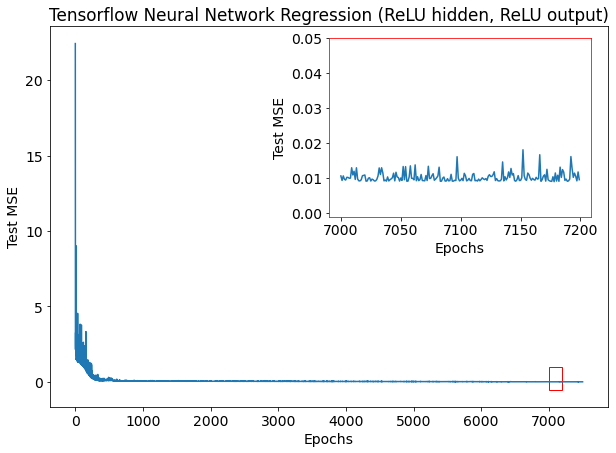

In [49]:
test_loss = train_history.history['val_loss']

plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(10,7))

ax.plot(test_loss)
ax.set_ylabel('Test MSE')
ax.set_xlabel('Epochs')
rect = patches.Rectangle((7000, -0.5), 200, 1.5, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.set_title('Tensorflow Neural Network Regression (ReLU hidden, ReLU output)')


axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47]);
axins.plot(test_loss[7000:7200])
axins.set_xticklabels(range(6950, 7250, 50));
axins.set_ylabel('Test MSE')
axins.set_xlabel('Epochs')
axins.set_ylim(-0.001, 0.05)
plt.setp(axins.spines.values(), color='red');
fig.savefig('regression_nn_tensorflow.jpg', dpi=1000, bbox_inches='tight')

############################################################################################################################

# Classification

#############################################################################################################################

### From Scratch

In [108]:
# load and standard scale the wisconsin breast cancer data

breast_cancer = load_breast_cancer()

X, y = breast_cancer.data, breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler() 
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [109]:
# put data in tuple format to enable use in our network

train_data = []
for i in range(X_train_scaled.shape[0]):
    x_arr = X_train_scaled[i,:]
    x_arr = np.reshape(x_arr, (30,1))
    y = y_train[i]
    
    if y == 0:
        y_arr = np.array([1.0, 0.0])
    else:
        y_arr = np.array([0.0, 1.0])

    train_data.append(tuple((x_arr, y_arr)))

test_data = []
for i in range(X_test_scaled.shape[0]):
    x_arr = X_test_scaled[i,:]
    x_arr = np.reshape(x_arr, (30,1))
    y_arr = y_test[i]

    test_data.append(tuple((x_arr, y_arr)))

### relu hidden layer test

In [113]:
activ_funcs = ['relu', 'sigmoid']
net_class = neural_network([30, 5, 2], activ_funcs, 'classification', lmbda=0.0)

data_size = len(train_data)
n_epochs = 200
eta = 0.1

np.random.seed(1)
test_acc_relu = net_class.SGD(train_data, test_data, n_epochs, data_size, eta)

Epoch 0: 0.4649122807017544
Epoch 1: 0.5350877192982456
Epoch 2: 0.6403508771929824
Epoch 3: 0.7543859649122807
Epoch 4: 0.8157894736842105
Epoch 5: 0.8333333333333334
Epoch 6: 0.8508771929824561
Epoch 7: 0.8333333333333334
Epoch 8: 0.8245614035087719
Epoch 9: 0.8245614035087719
Epoch 10: 0.8333333333333334
Epoch 11: 0.8333333333333334
Epoch 12: 0.8421052631578947
Epoch 13: 0.8508771929824561
Epoch 14: 0.8508771929824561
Epoch 15: 0.8508771929824561
Epoch 16: 0.8421052631578947
Epoch 17: 0.8421052631578947
Epoch 18: 0.868421052631579
Epoch 19: 0.8771929824561403
Epoch 20: 0.8859649122807017
Epoch 21: 0.8859649122807017
Epoch 22: 0.8947368421052632
Epoch 23: 0.9035087719298246
Epoch 24: 0.9035087719298246
Epoch 25: 0.9122807017543859
Epoch 26: 0.9122807017543859
Epoch 27: 0.9210526315789473
Epoch 28: 0.9210526315789473
Epoch 29: 0.9210526315789473
Epoch 30: 0.9210526315789473
Epoch 31: 0.9210526315789473
Epoch 32: 0.9210526315789473
Epoch 33: 0.9210526315789473
Epoch 34: 0.9210526315789

In [114]:
print(max(test_acc_relu))

0.9385964912280702


### sigmoid hidden layer test

In [115]:
activ_funcs = ['sigmoid', 'sigmoid']
net_class = neural_network([30, 5, 2], activ_funcs, 'classification', lmbda=0.0)

data_size = len(train_data)
n_epochs = 200
eta = 0.1

np.random.seed(1)
test_acc_sigmoid = net_class.SGD(train_data, test_data, n_epochs, data_size, eta)

Epoch 0: 0.41228070175438597
Epoch 1: 0.39473684210526316
Epoch 2: 0.6140350877192983
Epoch 3: 0.6578947368421053
Epoch 4: 0.6052631578947368
Epoch 5: 0.5964912280701754
Epoch 6: 0.5877192982456141
Epoch 7: 0.5877192982456141
Epoch 8: 0.5877192982456141
Epoch 9: 0.5877192982456141
Epoch 10: 0.5877192982456141
Epoch 11: 0.5877192982456141
Epoch 12: 0.5877192982456141
Epoch 13: 0.5877192982456141
Epoch 14: 0.5877192982456141
Epoch 15: 0.5877192982456141
Epoch 16: 0.5877192982456141
Epoch 17: 0.5877192982456141
Epoch 18: 0.5877192982456141
Epoch 19: 0.5877192982456141
Epoch 20: 0.5877192982456141
Epoch 21: 0.5877192982456141
Epoch 22: 0.5877192982456141
Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.5877192982456141
Epoch 28: 0.5877192982456141
Epoch 29: 0.5877192982456141
Epoch 30: 0.5877192982456141
Epoch 31: 0.5877192982456141
Epoch 32: 0.5877192982456141
Epoch 33: 0.5877192982456141
Epoch 34: 0.5877192982

In [116]:
print(max(test_acc_sigmoid))

0.9473684210526315


### leakyrelu hidden layer test

In [117]:
activ_funcs = ['leaky_relu', 'sigmoid']
net_class = neural_network([30, 5, 2], activ_funcs, 'classification', lmbda=0.0)

data_size = len(train_data)
n_epochs = 200
eta = 0.1

np.random.seed(1)
test_acc_leaky = net_class.SGD(train_data, test_data, n_epochs, data_size, eta)

Epoch 0: 0.5350877192982456
Epoch 1: 0.7280701754385965
Epoch 2: 0.8508771929824561
Epoch 3: 0.8596491228070176
Epoch 4: 0.868421052631579
Epoch 5: 0.8771929824561403
Epoch 6: 0.8771929824561403
Epoch 7: 0.8771929824561403
Epoch 8: 0.8771929824561403
Epoch 9: 0.8771929824561403
Epoch 10: 0.8771929824561403
Epoch 11: 0.8771929824561403
Epoch 12: 0.8771929824561403
Epoch 13: 0.8947368421052632
Epoch 14: 0.8947368421052632
Epoch 15: 0.8947368421052632
Epoch 16: 0.9035087719298246
Epoch 17: 0.8947368421052632
Epoch 18: 0.8947368421052632
Epoch 19: 0.8947368421052632
Epoch 20: 0.8947368421052632
Epoch 21: 0.8947368421052632
Epoch 22: 0.9035087719298246
Epoch 23: 0.9035087719298246
Epoch 24: 0.9035087719298246
Epoch 25: 0.9122807017543859
Epoch 26: 0.9122807017543859
Epoch 27: 0.9122807017543859
Epoch 28: 0.9122807017543859
Epoch 29: 0.9122807017543859
Epoch 30: 0.9122807017543859
Epoch 31: 0.9122807017543859
Epoch 32: 0.9122807017543859
Epoch 33: 0.9122807017543859
Epoch 34: 0.9122807017543

In [121]:
print(max(test_acc_leaky))

0.9210526315789473


### additional hidden layer test (sigmoid sigmoid )

In [88]:
activ_funcs = ['sigmoid', 'sigmoid', 'sigmoid']
net_class = neural_network([30, 5, 5, 2], activ_funcs, 'classification', lmbda=0.0)

data_size = len(train_data)
n_epochs = 200
eta = 0.1

np.random.seed(1)
test_acc_sigmoid = net_class.SGD(train_data, test_data, n_epochs, data_size, eta)

Epoch 0: 0.41228070175438597
Epoch 1: 0.41228070175438597
Epoch 2: 0.41228070175438597
Epoch 3: 0.41228070175438597
Epoch 4: 0.41228070175438597
Epoch 5: 0.41228070175438597
Epoch 6: 0.41228070175438597
Epoch 7: 0.41228070175438597
Epoch 8: 0.5877192982456141
Epoch 9: 0.5877192982456141
Epoch 10: 0.5877192982456141
Epoch 11: 0.5877192982456141
Epoch 12: 0.5877192982456141
Epoch 13: 0.5877192982456141
Epoch 14: 0.5877192982456141
Epoch 15: 0.5877192982456141
Epoch 16: 0.5877192982456141
Epoch 17: 0.5877192982456141
Epoch 18: 0.5877192982456141
Epoch 19: 0.5877192982456141
Epoch 20: 0.5877192982456141
Epoch 21: 0.5877192982456141
Epoch 22: 0.5877192982456141
Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.5877192982456141
Epoch 28: 0.5877192982456141
Epoch 29: 0.5877192982456141
Epoch 30: 0.5877192982456141
Epoch 31: 0.5877192982456141
Epoch 32: 0.5877192982456141
Epoch 33: 0.5877192982456141
Epoch 34: 0.5877

In [118]:
print(max(test_acc_leaky))

0.9210526315789473


### more nodes test (20 instead of 5)

In [119]:
activ_funcs = ['sigmoid', 'sigmoid']
net_class = neural_network([30, 20, 2], activ_funcs, 'classification', lmbda=0.0)

data_size = len(train_data)
n_epochs = 200
eta = 0.1

np.random.seed(1)
test_acc_sigmoid_20 = net_class.SGD(train_data, test_data, n_epochs, data_size, eta)

Epoch 0: 0.5789473684210527
Epoch 1: 0.5877192982456141
Epoch 2: 0.5877192982456141
Epoch 3: 0.5877192982456141
Epoch 4: 0.5877192982456141
Epoch 5: 0.5877192982456141
Epoch 6: 0.5877192982456141
Epoch 7: 0.5877192982456141
Epoch 8: 0.5877192982456141
Epoch 9: 0.5877192982456141
Epoch 10: 0.5877192982456141
Epoch 11: 0.5877192982456141
Epoch 12: 0.5877192982456141
Epoch 13: 0.5877192982456141
Epoch 14: 0.5877192982456141
Epoch 15: 0.5877192982456141
Epoch 16: 0.5877192982456141
Epoch 17: 0.5877192982456141
Epoch 18: 0.5877192982456141
Epoch 19: 0.5877192982456141
Epoch 20: 0.5877192982456141
Epoch 21: 0.5877192982456141
Epoch 22: 0.5877192982456141
Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.5877192982456141
Epoch 28: 0.5877192982456141
Epoch 29: 0.5877192982456141
Epoch 30: 0.5877192982456141
Epoch 31: 0.5877192982456141
Epoch 32: 0.5877192982456141
Epoch 33: 0.5964912280701754
Epoch 34: 0.596491228070

In [120]:
print(max(test_acc_sigmoid_20))

0.956140350877193


### sigmoid seems to do the best, and we will use 20 nodes in the hidden layer. Now we do a grid search over eta and lambda (this takes a couple of minutes to run)

In [94]:
etas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
lmbdas = np.array([0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

nn_class_grid = np.zeros((len(etas), len(lmbdas)))
activ_funcs = ['sigmoid', 'sigmoid']                        
for eta,i in zip(etas, range(len(etas))):
    for lmbd,j in zip(lmbdas, range(len(lmbdas))):
        
        net_class = neural_network([30, 20, 2], activ_funcs, 'classification', lmbda=lmbd)
        test_accuracies = net_class.SGD(train_data, test_data, n_epochs, mini_batch_size=data_size, eta=eta)
                        
        final_acc = test_accuracies[-1]
        nn_class_grid[i,j] = final_acc
        
    print(i)

Epoch 0: 0.41228070175438597
Epoch 1: 0.41228070175438597
Epoch 2: 0.41228070175438597
Epoch 3: 0.41228070175438597
Epoch 4: 0.41228070175438597
Epoch 5: 0.41228070175438597
Epoch 6: 0.41228070175438597
Epoch 7: 0.41228070175438597
Epoch 8: 0.41228070175438597
Epoch 9: 0.41228070175438597
Epoch 10: 0.41228070175438597
Epoch 11: 0.41228070175438597
Epoch 12: 0.41228070175438597
Epoch 13: 0.41228070175438597
Epoch 14: 0.41228070175438597
Epoch 15: 0.41228070175438597
Epoch 16: 0.41228070175438597
Epoch 17: 0.41228070175438597
Epoch 18: 0.41228070175438597
Epoch 19: 0.41228070175438597
Epoch 20: 0.41228070175438597
Epoch 21: 0.41228070175438597
Epoch 22: 0.41228070175438597
Epoch 23: 0.41228070175438597
Epoch 24: 0.41228070175438597
Epoch 25: 0.41228070175438597
Epoch 26: 0.41228070175438597
Epoch 27: 0.41228070175438597
Epoch 28: 0.41228070175438597
Epoch 29: 0.41228070175438597
Epoch 30: 0.41228070175438597
Epoch 31: 0.41228070175438597
Epoch 32: 0.41228070175438597
Epoch 33: 0.41228070

Epoch 74: 0.5877192982456141
Epoch 75: 0.5877192982456141
Epoch 76: 0.5877192982456141
Epoch 77: 0.5877192982456141
Epoch 78: 0.5877192982456141
Epoch 79: 0.5877192982456141
Epoch 80: 0.5877192982456141
Epoch 81: 0.5877192982456141
Epoch 82: 0.5877192982456141
Epoch 83: 0.5877192982456141
Epoch 84: 0.5877192982456141
Epoch 85: 0.5877192982456141
Epoch 86: 0.5877192982456141
Epoch 87: 0.5877192982456141
Epoch 88: 0.5877192982456141
Epoch 89: 0.5877192982456141
Epoch 90: 0.5877192982456141
Epoch 91: 0.5877192982456141
Epoch 92: 0.5877192982456141
Epoch 93: 0.5877192982456141
Epoch 94: 0.5877192982456141
Epoch 95: 0.5877192982456141
Epoch 96: 0.5877192982456141
Epoch 97: 0.5877192982456141
Epoch 98: 0.5877192982456141
Epoch 99: 0.5877192982456141
Epoch 100: 0.5877192982456141
Epoch 101: 0.5877192982456141
Epoch 102: 0.5877192982456141
Epoch 103: 0.5877192982456141
Epoch 104: 0.5877192982456141
Epoch 105: 0.5877192982456141
Epoch 106: 0.5877192982456141
Epoch 107: 0.5877192982456141
Epoch 

Epoch 149: 0.41228070175438597
Epoch 150: 0.41228070175438597
Epoch 151: 0.41228070175438597
Epoch 152: 0.41228070175438597
Epoch 153: 0.41228070175438597
Epoch 154: 0.41228070175438597
Epoch 155: 0.41228070175438597
Epoch 156: 0.41228070175438597
Epoch 157: 0.41228070175438597
Epoch 158: 0.41228070175438597
Epoch 159: 0.41228070175438597
Epoch 160: 0.41228070175438597
Epoch 161: 0.41228070175438597
Epoch 162: 0.41228070175438597
Epoch 163: 0.41228070175438597
Epoch 164: 0.41228070175438597
Epoch 165: 0.41228070175438597
Epoch 166: 0.41228070175438597
Epoch 167: 0.41228070175438597
Epoch 168: 0.41228070175438597
Epoch 169: 0.41228070175438597
Epoch 170: 0.41228070175438597
Epoch 171: 0.41228070175438597
Epoch 172: 0.41228070175438597
Epoch 173: 0.41228070175438597
Epoch 174: 0.41228070175438597
Epoch 175: 0.41228070175438597
Epoch 176: 0.41228070175438597
Epoch 177: 0.41228070175438597
Epoch 178: 0.41228070175438597
Epoch 179: 0.41228070175438597
Epoch 180: 0.41228070175438597
Epoch 18

Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.5877192982456141
Epoch 28: 0.5877192982456141
Epoch 29: 0.5877192982456141
Epoch 30: 0.5877192982456141
Epoch 31: 0.5877192982456141
Epoch 32: 0.5877192982456141
Epoch 33: 0.5877192982456141
Epoch 34: 0.5877192982456141
Epoch 35: 0.5877192982456141
Epoch 36: 0.5877192982456141
Epoch 37: 0.5877192982456141
Epoch 38: 0.5877192982456141
Epoch 39: 0.5877192982456141
Epoch 40: 0.5877192982456141
Epoch 41: 0.5877192982456141
Epoch 42: 0.5877192982456141
Epoch 43: 0.5877192982456141
Epoch 44: 0.5877192982456141
Epoch 45: 0.5877192982456141
Epoch 46: 0.5877192982456141
Epoch 47: 0.5877192982456141
Epoch 48: 0.5877192982456141
Epoch 49: 0.5877192982456141
Epoch 50: 0.5877192982456141
Epoch 51: 0.5877192982456141
Epoch 52: 0.5877192982456141
Epoch 53: 0.5877192982456141
Epoch 54: 0.5877192982456141
Epoch 55: 0.5877192982456141
Epoch 56: 0.5877192982456141
Epoch 57: 0.58

Epoch 103: 0.5877192982456141
Epoch 104: 0.5877192982456141
Epoch 105: 0.5877192982456141
Epoch 106: 0.5877192982456141
Epoch 107: 0.5877192982456141
Epoch 108: 0.5877192982456141
Epoch 109: 0.5877192982456141
Epoch 110: 0.5877192982456141
Epoch 111: 0.5877192982456141
Epoch 112: 0.5877192982456141
Epoch 113: 0.5877192982456141
Epoch 114: 0.5877192982456141
Epoch 115: 0.5877192982456141
Epoch 116: 0.5877192982456141
Epoch 117: 0.5877192982456141
Epoch 118: 0.5877192982456141
Epoch 119: 0.5877192982456141
Epoch 120: 0.5877192982456141
Epoch 121: 0.5877192982456141
Epoch 122: 0.5877192982456141
Epoch 123: 0.5877192982456141
Epoch 124: 0.5877192982456141
Epoch 125: 0.5877192982456141
Epoch 126: 0.5877192982456141
Epoch 127: 0.5877192982456141
Epoch 128: 0.5877192982456141
Epoch 129: 0.5877192982456141
Epoch 130: 0.5877192982456141
Epoch 131: 0.5877192982456141
Epoch 132: 0.5877192982456141
Epoch 133: 0.5877192982456141
Epoch 134: 0.5877192982456141
Epoch 135: 0.5877192982456141
Epoch 136:

Epoch 182: 0.5877192982456141
Epoch 183: 0.5877192982456141
Epoch 184: 0.5877192982456141
Epoch 185: 0.5877192982456141
Epoch 186: 0.5877192982456141
Epoch 187: 0.5877192982456141
Epoch 188: 0.5877192982456141
Epoch 189: 0.5877192982456141
Epoch 190: 0.5877192982456141
Epoch 191: 0.5877192982456141
Epoch 192: 0.5877192982456141
Epoch 193: 0.5877192982456141
Epoch 194: 0.5877192982456141
Epoch 195: 0.5877192982456141
Epoch 196: 0.5877192982456141
Epoch 197: 0.5877192982456141
Epoch 198: 0.5877192982456141
Epoch 199: 0.5877192982456141
0
Epoch 0: 0.2719298245614035
Epoch 1: 0.2719298245614035
Epoch 2: 0.2719298245614035
Epoch 3: 0.2719298245614035
Epoch 4: 0.2719298245614035
Epoch 5: 0.2719298245614035
Epoch 6: 0.2719298245614035
Epoch 7: 0.2719298245614035
Epoch 8: 0.2719298245614035
Epoch 9: 0.2719298245614035
Epoch 10: 0.2719298245614035
Epoch 11: 0.2719298245614035
Epoch 12: 0.2719298245614035
Epoch 13: 0.2719298245614035
Epoch 14: 0.2719298245614035
Epoch 15: 0.2719298245614035
Epoc

Epoch 62: 0.42105263157894735
Epoch 63: 0.42105263157894735
Epoch 64: 0.42105263157894735
Epoch 65: 0.42105263157894735
Epoch 66: 0.42105263157894735
Epoch 67: 0.42105263157894735
Epoch 68: 0.42105263157894735
Epoch 69: 0.42105263157894735
Epoch 70: 0.42105263157894735
Epoch 71: 0.42105263157894735
Epoch 72: 0.42105263157894735
Epoch 73: 0.42105263157894735
Epoch 74: 0.42105263157894735
Epoch 75: 0.42105263157894735
Epoch 76: 0.42105263157894735
Epoch 77: 0.42105263157894735
Epoch 78: 0.42105263157894735
Epoch 79: 0.42105263157894735
Epoch 80: 0.42105263157894735
Epoch 81: 0.42105263157894735
Epoch 82: 0.42105263157894735
Epoch 83: 0.42105263157894735
Epoch 84: 0.42105263157894735
Epoch 85: 0.42105263157894735
Epoch 86: 0.42105263157894735
Epoch 87: 0.42105263157894735
Epoch 88: 0.42105263157894735
Epoch 89: 0.42105263157894735
Epoch 90: 0.42105263157894735
Epoch 91: 0.42105263157894735
Epoch 92: 0.42105263157894735
Epoch 93: 0.42105263157894735
Epoch 94: 0.4298245614035088
Epoch 95: 0

Epoch 138: 0.39473684210526316
Epoch 139: 0.39473684210526316
Epoch 140: 0.39473684210526316
Epoch 141: 0.39473684210526316
Epoch 142: 0.39473684210526316
Epoch 143: 0.39473684210526316
Epoch 144: 0.39473684210526316
Epoch 145: 0.39473684210526316
Epoch 146: 0.39473684210526316
Epoch 147: 0.39473684210526316
Epoch 148: 0.39473684210526316
Epoch 149: 0.39473684210526316
Epoch 150: 0.39473684210526316
Epoch 151: 0.39473684210526316
Epoch 152: 0.39473684210526316
Epoch 153: 0.39473684210526316
Epoch 154: 0.39473684210526316
Epoch 155: 0.39473684210526316
Epoch 156: 0.39473684210526316
Epoch 157: 0.38596491228070173
Epoch 158: 0.38596491228070173
Epoch 159: 0.38596491228070173
Epoch 160: 0.38596491228070173
Epoch 161: 0.38596491228070173
Epoch 162: 0.38596491228070173
Epoch 163: 0.38596491228070173
Epoch 164: 0.38596491228070173
Epoch 165: 0.38596491228070173
Epoch 166: 0.38596491228070173
Epoch 167: 0.38596491228070173
Epoch 168: 0.38596491228070173
Epoch 169: 0.38596491228070173
Epoch 17

Epoch 11: 0.38596491228070173
Epoch 12: 0.37719298245614036
Epoch 13: 0.37719298245614036
Epoch 14: 0.3684210526315789
Epoch 15: 0.38596491228070173
Epoch 16: 0.38596491228070173
Epoch 17: 0.38596491228070173
Epoch 18: 0.38596491228070173
Epoch 19: 0.38596491228070173
Epoch 20: 0.38596491228070173
Epoch 21: 0.38596491228070173
Epoch 22: 0.39473684210526316
Epoch 23: 0.39473684210526316
Epoch 24: 0.39473684210526316
Epoch 25: 0.39473684210526316
Epoch 26: 0.39473684210526316
Epoch 27: 0.39473684210526316
Epoch 28: 0.40350877192982454
Epoch 29: 0.40350877192982454
Epoch 30: 0.40350877192982454
Epoch 31: 0.40350877192982454
Epoch 32: 0.39473684210526316
Epoch 33: 0.39473684210526316
Epoch 34: 0.39473684210526316
Epoch 35: 0.39473684210526316
Epoch 36: 0.39473684210526316
Epoch 37: 0.39473684210526316
Epoch 38: 0.39473684210526316
Epoch 39: 0.39473684210526316
Epoch 40: 0.39473684210526316
Epoch 41: 0.39473684210526316
Epoch 42: 0.39473684210526316
Epoch 43: 0.38596491228070173
Epoch 44: 0

Epoch 84: 0.5877192982456141
Epoch 85: 0.5877192982456141
Epoch 86: 0.5877192982456141
Epoch 87: 0.5877192982456141
Epoch 88: 0.5877192982456141
Epoch 89: 0.5877192982456141
Epoch 90: 0.5877192982456141
Epoch 91: 0.5877192982456141
Epoch 92: 0.5877192982456141
Epoch 93: 0.5877192982456141
Epoch 94: 0.5877192982456141
Epoch 95: 0.5877192982456141
Epoch 96: 0.5877192982456141
Epoch 97: 0.5877192982456141
Epoch 98: 0.5877192982456141
Epoch 99: 0.5877192982456141
Epoch 100: 0.5877192982456141
Epoch 101: 0.5877192982456141
Epoch 102: 0.5877192982456141
Epoch 103: 0.5877192982456141
Epoch 104: 0.5877192982456141
Epoch 105: 0.5877192982456141
Epoch 106: 0.5877192982456141
Epoch 107: 0.5877192982456141
Epoch 108: 0.5877192982456141
Epoch 109: 0.5877192982456141
Epoch 110: 0.5877192982456141
Epoch 111: 0.5877192982456141
Epoch 112: 0.5877192982456141
Epoch 113: 0.5877192982456141
Epoch 114: 0.5877192982456141
Epoch 115: 0.5877192982456141
Epoch 116: 0.5877192982456141
Epoch 117: 0.5877192982456

Epoch 165: 0.5877192982456141
Epoch 166: 0.5877192982456141
Epoch 167: 0.5877192982456141
Epoch 168: 0.5877192982456141
Epoch 169: 0.5877192982456141
Epoch 170: 0.5877192982456141
Epoch 171: 0.5877192982456141
Epoch 172: 0.5877192982456141
Epoch 173: 0.5877192982456141
Epoch 174: 0.5877192982456141
Epoch 175: 0.5877192982456141
Epoch 176: 0.5877192982456141
Epoch 177: 0.5877192982456141
Epoch 178: 0.5877192982456141
Epoch 179: 0.5877192982456141
Epoch 180: 0.5877192982456141
Epoch 181: 0.5877192982456141
Epoch 182: 0.5877192982456141
Epoch 183: 0.5877192982456141
Epoch 184: 0.5877192982456141
Epoch 185: 0.5877192982456141
Epoch 186: 0.5877192982456141
Epoch 187: 0.5877192982456141
Epoch 188: 0.5877192982456141
Epoch 189: 0.5877192982456141
Epoch 190: 0.5877192982456141
Epoch 191: 0.5877192982456141
Epoch 192: 0.5877192982456141
Epoch 193: 0.5877192982456141
Epoch 194: 0.5877192982456141
Epoch 195: 0.5877192982456141
Epoch 196: 0.5877192982456141
Epoch 197: 0.5877192982456141
Epoch 198:

Epoch 36: 0.41228070175438597
Epoch 37: 0.41228070175438597
Epoch 38: 0.41228070175438597
Epoch 39: 0.41228070175438597
Epoch 40: 0.41228070175438597
Epoch 41: 0.41228070175438597
Epoch 42: 0.41228070175438597
Epoch 43: 0.41228070175438597
Epoch 44: 0.41228070175438597
Epoch 45: 0.41228070175438597
Epoch 46: 0.41228070175438597
Epoch 47: 0.41228070175438597
Epoch 48: 0.41228070175438597
Epoch 49: 0.41228070175438597
Epoch 50: 0.41228070175438597
Epoch 51: 0.41228070175438597
Epoch 52: 0.41228070175438597
Epoch 53: 0.41228070175438597
Epoch 54: 0.41228070175438597
Epoch 55: 0.41228070175438597
Epoch 56: 0.41228070175438597
Epoch 57: 0.41228070175438597
Epoch 58: 0.41228070175438597
Epoch 59: 0.41228070175438597
Epoch 60: 0.41228070175438597
Epoch 61: 0.41228070175438597
Epoch 62: 0.41228070175438597
Epoch 63: 0.41228070175438597
Epoch 64: 0.41228070175438597
Epoch 65: 0.41228070175438597
Epoch 66: 0.41228070175438597
Epoch 67: 0.41228070175438597
Epoch 68: 0.41228070175438597
Epoch 69: 

Epoch 115: 0.41228070175438597
Epoch 116: 0.41228070175438597
Epoch 117: 0.41228070175438597
Epoch 118: 0.41228070175438597
Epoch 119: 0.41228070175438597
Epoch 120: 0.41228070175438597
Epoch 121: 0.41228070175438597
Epoch 122: 0.41228070175438597
Epoch 123: 0.41228070175438597
Epoch 124: 0.41228070175438597
Epoch 125: 0.41228070175438597
Epoch 126: 0.41228070175438597
Epoch 127: 0.41228070175438597
Epoch 128: 0.41228070175438597
Epoch 129: 0.41228070175438597
Epoch 130: 0.41228070175438597
Epoch 131: 0.41228070175438597
Epoch 132: 0.41228070175438597
Epoch 133: 0.41228070175438597
Epoch 134: 0.41228070175438597
Epoch 135: 0.41228070175438597
Epoch 136: 0.41228070175438597
Epoch 137: 0.41228070175438597
Epoch 138: 0.41228070175438597
Epoch 139: 0.41228070175438597
Epoch 140: 0.41228070175438597
Epoch 141: 0.41228070175438597
Epoch 142: 0.41228070175438597
Epoch 143: 0.41228070175438597
Epoch 144: 0.41228070175438597
Epoch 145: 0.41228070175438597
Epoch 146: 0.41228070175438597
Epoch 14

Epoch 193: 0.5964912280701754
Epoch 194: 0.5964912280701754
Epoch 195: 0.5964912280701754
Epoch 196: 0.5964912280701754
Epoch 197: 0.5964912280701754
Epoch 198: 0.5964912280701754
Epoch 199: 0.5964912280701754
Epoch 0: 0.5877192982456141
Epoch 1: 0.5877192982456141
Epoch 2: 0.5877192982456141
Epoch 3: 0.5877192982456141
Epoch 4: 0.5877192982456141
Epoch 5: 0.5877192982456141
Epoch 6: 0.5877192982456141
Epoch 7: 0.5877192982456141
Epoch 8: 0.5877192982456141
Epoch 9: 0.5877192982456141
Epoch 10: 0.5877192982456141
Epoch 11: 0.5877192982456141
Epoch 12: 0.5877192982456141
Epoch 13: 0.5877192982456141
Epoch 14: 0.5877192982456141
Epoch 15: 0.5877192982456141
Epoch 16: 0.5877192982456141
Epoch 17: 0.5877192982456141
Epoch 18: 0.5877192982456141
Epoch 19: 0.5877192982456141
Epoch 20: 0.5877192982456141
Epoch 21: 0.5877192982456141
Epoch 22: 0.5877192982456141
Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.58771

Epoch 77: 0.5877192982456141
Epoch 78: 0.5877192982456141
Epoch 79: 0.5877192982456141
Epoch 80: 0.5877192982456141
Epoch 81: 0.5877192982456141
Epoch 82: 0.5877192982456141
Epoch 83: 0.5877192982456141
Epoch 84: 0.5877192982456141
Epoch 85: 0.5877192982456141
Epoch 86: 0.5877192982456141
Epoch 87: 0.5877192982456141
Epoch 88: 0.5877192982456141
Epoch 89: 0.5877192982456141
Epoch 90: 0.5877192982456141
Epoch 91: 0.5877192982456141
Epoch 92: 0.5877192982456141
Epoch 93: 0.5877192982456141
Epoch 94: 0.5877192982456141
Epoch 95: 0.5877192982456141
Epoch 96: 0.5877192982456141
Epoch 97: 0.5877192982456141
Epoch 98: 0.5877192982456141
Epoch 99: 0.5877192982456141
Epoch 100: 0.5877192982456141
Epoch 101: 0.5877192982456141
Epoch 102: 0.5877192982456141
Epoch 103: 0.5877192982456141
Epoch 104: 0.5877192982456141
Epoch 105: 0.5877192982456141
Epoch 106: 0.5877192982456141
Epoch 107: 0.5877192982456141
Epoch 108: 0.5877192982456141
Epoch 109: 0.5877192982456141
Epoch 110: 0.5877192982456141
Epo

Epoch 159: 0.5877192982456141
Epoch 160: 0.5877192982456141
Epoch 161: 0.5877192982456141
Epoch 162: 0.5877192982456141
Epoch 163: 0.5877192982456141
Epoch 164: 0.5877192982456141
Epoch 165: 0.5877192982456141
Epoch 166: 0.5877192982456141
Epoch 167: 0.5877192982456141
Epoch 168: 0.5877192982456141
Epoch 169: 0.5877192982456141
Epoch 170: 0.5877192982456141
Epoch 171: 0.5877192982456141
Epoch 172: 0.5877192982456141
Epoch 173: 0.5877192982456141
Epoch 174: 0.5877192982456141
Epoch 175: 0.5877192982456141
Epoch 176: 0.5877192982456141
Epoch 177: 0.5877192982456141
Epoch 178: 0.5877192982456141
Epoch 179: 0.5877192982456141
Epoch 180: 0.5877192982456141
Epoch 181: 0.5877192982456141
Epoch 182: 0.5877192982456141
Epoch 183: 0.5877192982456141
Epoch 184: 0.5877192982456141
Epoch 185: 0.5877192982456141
Epoch 186: 0.5877192982456141
Epoch 187: 0.5877192982456141
Epoch 188: 0.5877192982456141
Epoch 189: 0.5877192982456141
Epoch 190: 0.5877192982456141
Epoch 191: 0.5877192982456141
Epoch 192:

Epoch 39: 0.7192982456140351
Epoch 40: 0.7192982456140351
Epoch 41: 0.7192982456140351
Epoch 42: 0.7105263157894737
Epoch 43: 0.7105263157894737
Epoch 44: 0.7105263157894737
Epoch 45: 0.7105263157894737
Epoch 46: 0.7017543859649122
Epoch 47: 0.7017543859649122
Epoch 48: 0.7017543859649122
Epoch 49: 0.7017543859649122
Epoch 50: 0.6929824561403509
Epoch 51: 0.6929824561403509
Epoch 52: 0.6842105263157895
Epoch 53: 0.6842105263157895
Epoch 54: 0.6754385964912281
Epoch 55: 0.6754385964912281
Epoch 56: 0.6754385964912281
Epoch 57: 0.6754385964912281
Epoch 58: 0.6754385964912281
Epoch 59: 0.6754385964912281
Epoch 60: 0.6666666666666666
Epoch 61: 0.6578947368421053
Epoch 62: 0.6491228070175439
Epoch 63: 0.6491228070175439
Epoch 64: 0.6491228070175439
Epoch 65: 0.6491228070175439
Epoch 66: 0.6403508771929824
Epoch 67: 0.6403508771929824
Epoch 68: 0.631578947368421
Epoch 69: 0.631578947368421
Epoch 70: 0.631578947368421
Epoch 71: 0.631578947368421
Epoch 72: 0.631578947368421
Epoch 73: 0.6315789

Epoch 119: 0.5877192982456141
Epoch 120: 0.5877192982456141
Epoch 121: 0.5877192982456141
Epoch 122: 0.5877192982456141
Epoch 123: 0.5877192982456141
Epoch 124: 0.5877192982456141
Epoch 125: 0.5877192982456141
Epoch 126: 0.5877192982456141
Epoch 127: 0.5877192982456141
Epoch 128: 0.5877192982456141
Epoch 129: 0.5877192982456141
Epoch 130: 0.5877192982456141
Epoch 131: 0.5877192982456141
Epoch 132: 0.5877192982456141
Epoch 133: 0.5877192982456141
Epoch 134: 0.5877192982456141
Epoch 135: 0.5877192982456141
Epoch 136: 0.5877192982456141
Epoch 137: 0.5877192982456141
Epoch 138: 0.5877192982456141
Epoch 139: 0.5877192982456141
Epoch 140: 0.5877192982456141
Epoch 141: 0.5877192982456141
Epoch 142: 0.5877192982456141
Epoch 143: 0.5877192982456141
Epoch 144: 0.5877192982456141
Epoch 145: 0.5877192982456141
Epoch 146: 0.5877192982456141
Epoch 147: 0.5877192982456141
Epoch 148: 0.5877192982456141
Epoch 149: 0.5877192982456141
Epoch 150: 0.5877192982456141
Epoch 151: 0.5877192982456141
Epoch 152:

Epoch 199: 0.5877192982456141
Epoch 0: 0.5877192982456141
Epoch 1: 0.5877192982456141
Epoch 2: 0.5877192982456141
Epoch 3: 0.5877192982456141
Epoch 4: 0.5877192982456141
Epoch 5: 0.5877192982456141
Epoch 6: 0.5877192982456141
Epoch 7: 0.5877192982456141
Epoch 8: 0.5877192982456141
Epoch 9: 0.5877192982456141
Epoch 10: 0.5877192982456141
Epoch 11: 0.5877192982456141
Epoch 12: 0.5877192982456141
Epoch 13: 0.5877192982456141
Epoch 14: 0.5877192982456141
Epoch 15: 0.5877192982456141
Epoch 16: 0.5877192982456141
Epoch 17: 0.5877192982456141
Epoch 18: 0.5877192982456141
Epoch 19: 0.5877192982456141
Epoch 20: 0.5877192982456141
Epoch 21: 0.5877192982456141
Epoch 22: 0.5877192982456141
Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.5877192982456141
Epoch 28: 0.5877192982456141
Epoch 29: 0.5877192982456141
Epoch 30: 0.5877192982456141
Epoch 31: 0.5877192982456141
Epoch 32: 0.5877192982456141
Epoch 33: 0.58771929824

Epoch 83: 0.5877192982456141
Epoch 84: 0.5877192982456141
Epoch 85: 0.5877192982456141
Epoch 86: 0.5877192982456141
Epoch 87: 0.5877192982456141
Epoch 88: 0.5877192982456141
Epoch 89: 0.5877192982456141
Epoch 90: 0.5877192982456141
Epoch 91: 0.5877192982456141
Epoch 92: 0.5877192982456141
Epoch 93: 0.5877192982456141
Epoch 94: 0.5877192982456141
Epoch 95: 0.5877192982456141
Epoch 96: 0.5877192982456141
Epoch 97: 0.5877192982456141
Epoch 98: 0.5877192982456141
Epoch 99: 0.5877192982456141
Epoch 100: 0.5877192982456141
Epoch 101: 0.5877192982456141
Epoch 102: 0.5877192982456141
Epoch 103: 0.5877192982456141
Epoch 104: 0.5877192982456141
Epoch 105: 0.5877192982456141
Epoch 106: 0.5877192982456141
Epoch 107: 0.5877192982456141
Epoch 108: 0.5877192982456141
Epoch 109: 0.5877192982456141
Epoch 110: 0.5877192982456141
Epoch 111: 0.5877192982456141
Epoch 112: 0.5877192982456141
Epoch 113: 0.5877192982456141
Epoch 114: 0.5877192982456141
Epoch 115: 0.5877192982456141
Epoch 116: 0.58771929824561

Epoch 162: 0.5877192982456141
Epoch 163: 0.5877192982456141
Epoch 164: 0.5877192982456141
Epoch 165: 0.5877192982456141
Epoch 166: 0.5877192982456141
Epoch 167: 0.5877192982456141
Epoch 168: 0.5877192982456141
Epoch 169: 0.5877192982456141
Epoch 170: 0.5877192982456141
Epoch 171: 0.5877192982456141
Epoch 172: 0.5877192982456141
Epoch 173: 0.5877192982456141
Epoch 174: 0.5877192982456141
Epoch 175: 0.5877192982456141
Epoch 176: 0.5877192982456141
Epoch 177: 0.5877192982456141
Epoch 178: 0.5877192982456141
Epoch 179: 0.5877192982456141
Epoch 180: 0.5877192982456141
Epoch 181: 0.5877192982456141
Epoch 182: 0.5877192982456141
Epoch 183: 0.5877192982456141
Epoch 184: 0.5877192982456141
Epoch 185: 0.5877192982456141
Epoch 186: 0.5877192982456141
Epoch 187: 0.5877192982456141
Epoch 188: 0.5877192982456141
Epoch 189: 0.5877192982456141
Epoch 190: 0.5877192982456141
Epoch 191: 0.5877192982456141
Epoch 192: 0.5877192982456141
Epoch 193: 0.5877192982456141
Epoch 194: 0.5877192982456141
Epoch 195:

Epoch 41: 0.6052631578947368
Epoch 42: 0.6052631578947368
Epoch 43: 0.6052631578947368
Epoch 44: 0.6140350877192983
Epoch 45: 0.6140350877192983
Epoch 46: 0.6140350877192983
Epoch 47: 0.6140350877192983
Epoch 48: 0.6140350877192983
Epoch 49: 0.631578947368421
Epoch 50: 0.631578947368421
Epoch 51: 0.631578947368421
Epoch 52: 0.6403508771929824
Epoch 53: 0.6491228070175439
Epoch 54: 0.6491228070175439
Epoch 55: 0.6491228070175439
Epoch 56: 0.6666666666666666
Epoch 57: 0.6842105263157895
Epoch 58: 0.6929824561403509
Epoch 59: 0.6929824561403509
Epoch 60: 0.6929824561403509
Epoch 61: 0.6929824561403509
Epoch 62: 0.7017543859649122
Epoch 63: 0.7368421052631579
Epoch 64: 0.7368421052631579
Epoch 65: 0.7368421052631579
Epoch 66: 0.7368421052631579
Epoch 67: 0.7368421052631579
Epoch 68: 0.7456140350877193
Epoch 69: 0.7543859649122807
Epoch 70: 0.7543859649122807
Epoch 71: 0.7543859649122807
Epoch 72: 0.7631578947368421
Epoch 73: 0.7719298245614035
Epoch 74: 0.7807017543859649
Epoch 75: 0.78947

Epoch 129: 0.956140350877193
Epoch 130: 0.956140350877193
Epoch 131: 0.956140350877193
Epoch 132: 0.956140350877193
Epoch 133: 0.956140350877193
Epoch 134: 0.956140350877193
Epoch 135: 0.956140350877193
Epoch 136: 0.956140350877193
Epoch 137: 0.956140350877193
Epoch 138: 0.956140350877193
Epoch 139: 0.956140350877193
Epoch 140: 0.956140350877193
Epoch 141: 0.956140350877193
Epoch 142: 0.956140350877193
Epoch 143: 0.956140350877193
Epoch 144: 0.956140350877193
Epoch 145: 0.956140350877193
Epoch 146: 0.956140350877193
Epoch 147: 0.956140350877193
Epoch 148: 0.956140350877193
Epoch 149: 0.956140350877193
Epoch 150: 0.956140350877193
Epoch 151: 0.956140350877193
Epoch 152: 0.956140350877193
Epoch 153: 0.956140350877193
Epoch 154: 0.956140350877193
Epoch 155: 0.956140350877193
Epoch 156: 0.956140350877193
Epoch 157: 0.956140350877193
Epoch 158: 0.956140350877193
Epoch 159: 0.956140350877193
Epoch 160: 0.956140350877193
Epoch 161: 0.956140350877193
Epoch 162: 0.956140350877193
Epoch 163: 0.9

Epoch 11: 0.5877192982456141
Epoch 12: 0.5877192982456141
Epoch 13: 0.5877192982456141
Epoch 14: 0.5877192982456141
Epoch 15: 0.5877192982456141
Epoch 16: 0.5877192982456141
Epoch 17: 0.5877192982456141
Epoch 18: 0.5877192982456141
Epoch 19: 0.5877192982456141
Epoch 20: 0.5877192982456141
Epoch 21: 0.5877192982456141
Epoch 22: 0.5877192982456141
Epoch 23: 0.5877192982456141
Epoch 24: 0.5877192982456141
Epoch 25: 0.5877192982456141
Epoch 26: 0.5877192982456141
Epoch 27: 0.5877192982456141
Epoch 28: 0.5877192982456141
Epoch 29: 0.5877192982456141
Epoch 30: 0.5877192982456141
Epoch 31: 0.5877192982456141
Epoch 32: 0.5877192982456141
Epoch 33: 0.5877192982456141
Epoch 34: 0.5877192982456141
Epoch 35: 0.5877192982456141
Epoch 36: 0.5877192982456141
Epoch 37: 0.5877192982456141
Epoch 38: 0.5877192982456141
Epoch 39: 0.5877192982456141
Epoch 40: 0.5877192982456141
Epoch 41: 0.5877192982456141
Epoch 42: 0.5877192982456141
Epoch 43: 0.5877192982456141
Epoch 44: 0.5877192982456141
Epoch 45: 0.58

Epoch 100: 0.5877192982456141
Epoch 101: 0.5877192982456141
Epoch 102: 0.5877192982456141
Epoch 103: 0.5877192982456141
Epoch 104: 0.5877192982456141
Epoch 105: 0.5877192982456141
Epoch 106: 0.5877192982456141
Epoch 107: 0.5877192982456141
Epoch 108: 0.5877192982456141
Epoch 109: 0.5877192982456141
Epoch 110: 0.5877192982456141
Epoch 111: 0.5877192982456141
Epoch 112: 0.5877192982456141
Epoch 113: 0.5877192982456141
Epoch 114: 0.5877192982456141
Epoch 115: 0.5877192982456141
Epoch 116: 0.5877192982456141
Epoch 117: 0.5877192982456141
Epoch 118: 0.5877192982456141
Epoch 119: 0.5877192982456141
Epoch 120: 0.5877192982456141
Epoch 121: 0.5877192982456141
Epoch 122: 0.5877192982456141
Epoch 123: 0.5877192982456141
Epoch 124: 0.5877192982456141
Epoch 125: 0.5877192982456141
Epoch 126: 0.5877192982456141
Epoch 127: 0.5877192982456141
Epoch 128: 0.5877192982456141
Epoch 129: 0.5877192982456141
Epoch 130: 0.5877192982456141
Epoch 131: 0.5877192982456141
Epoch 132: 0.5877192982456141
Epoch 133:

Epoch 182: 0.5877192982456141
Epoch 183: 0.5877192982456141
Epoch 184: 0.5877192982456141
Epoch 185: 0.5877192982456141
Epoch 186: 0.5877192982456141
Epoch 187: 0.5877192982456141
Epoch 188: 0.5877192982456141
Epoch 189: 0.5877192982456141
Epoch 190: 0.5877192982456141
Epoch 191: 0.5877192982456141
Epoch 192: 0.5877192982456141
Epoch 193: 0.5877192982456141
Epoch 194: 0.5877192982456141
Epoch 195: 0.5877192982456141
Epoch 196: 0.5877192982456141
Epoch 197: 0.5877192982456141
Epoch 198: 0.5877192982456141
Epoch 199: 0.5877192982456141
4
Epoch 0: 0.5877192982456141
Epoch 1: 0.5877192982456141
Epoch 2: 0.5877192982456141
Epoch 3: 0.5877192982456141
Epoch 4: 0.5877192982456141
Epoch 5: 0.5877192982456141
Epoch 6: 0.5964912280701754
Epoch 7: 0.6140350877192983
Epoch 8: 0.6754385964912281
Epoch 9: 0.7192982456140351
Epoch 10: 0.7894736842105263
Epoch 11: 0.8157894736842105
Epoch 12: 0.868421052631579
Epoch 13: 0.9035087719298246
Epoch 14: 0.9210526315789473
Epoch 15: 0.9473684210526315
Epoch

Epoch 68: 0.9736842105263158
Epoch 69: 0.9736842105263158
Epoch 70: 0.9736842105263158
Epoch 71: 0.9736842105263158
Epoch 72: 0.9736842105263158
Epoch 73: 0.9736842105263158
Epoch 74: 0.9736842105263158
Epoch 75: 0.9736842105263158
Epoch 76: 0.9736842105263158
Epoch 77: 0.9736842105263158
Epoch 78: 0.9736842105263158
Epoch 79: 0.9736842105263158
Epoch 80: 0.9736842105263158
Epoch 81: 0.9736842105263158
Epoch 82: 0.9736842105263158
Epoch 83: 0.9736842105263158
Epoch 84: 0.9736842105263158
Epoch 85: 0.9736842105263158
Epoch 86: 0.9736842105263158
Epoch 87: 0.9736842105263158
Epoch 88: 0.9736842105263158
Epoch 89: 0.9736842105263158
Epoch 90: 0.9649122807017544
Epoch 91: 0.9649122807017544
Epoch 92: 0.9649122807017544
Epoch 93: 0.9649122807017544
Epoch 94: 0.9649122807017544
Epoch 95: 0.9649122807017544
Epoch 96: 0.9649122807017544
Epoch 97: 0.9649122807017544
Epoch 98: 0.9649122807017544
Epoch 99: 0.9649122807017544
Epoch 100: 0.9649122807017544
Epoch 101: 0.9649122807017544
Epoch 102: 0

Epoch 154: 0.9649122807017544
Epoch 155: 0.9649122807017544
Epoch 156: 0.9649122807017544
Epoch 157: 0.9649122807017544
Epoch 158: 0.9649122807017544
Epoch 159: 0.9649122807017544
Epoch 160: 0.9649122807017544
Epoch 161: 0.9649122807017544
Epoch 162: 0.9649122807017544
Epoch 163: 0.9649122807017544
Epoch 164: 0.9649122807017544
Epoch 165: 0.9649122807017544
Epoch 166: 0.9649122807017544
Epoch 167: 0.9649122807017544
Epoch 168: 0.9649122807017544
Epoch 169: 0.9649122807017544
Epoch 170: 0.9649122807017544
Epoch 171: 0.9649122807017544
Epoch 172: 0.9649122807017544
Epoch 173: 0.9649122807017544
Epoch 174: 0.9649122807017544
Epoch 175: 0.9649122807017544
Epoch 176: 0.9649122807017544
Epoch 177: 0.9649122807017544
Epoch 178: 0.9649122807017544
Epoch 179: 0.9649122807017544
Epoch 180: 0.9649122807017544
Epoch 181: 0.9649122807017544
Epoch 182: 0.9649122807017544
Epoch 183: 0.9649122807017544
Epoch 184: 0.9649122807017544
Epoch 185: 0.9649122807017544
Epoch 186: 0.9649122807017544
Epoch 187:

Epoch 41: 0.9473684210526315
Epoch 42: 0.9473684210526315
Epoch 43: 0.956140350877193
Epoch 44: 0.956140350877193
Epoch 45: 0.956140350877193
Epoch 46: 0.956140350877193
Epoch 47: 0.956140350877193
Epoch 48: 0.956140350877193
Epoch 49: 0.956140350877193
Epoch 50: 0.956140350877193
Epoch 51: 0.956140350877193
Epoch 52: 0.956140350877193
Epoch 53: 0.956140350877193
Epoch 54: 0.956140350877193
Epoch 55: 0.956140350877193
Epoch 56: 0.956140350877193
Epoch 57: 0.956140350877193
Epoch 58: 0.956140350877193
Epoch 59: 0.956140350877193
Epoch 60: 0.956140350877193
Epoch 61: 0.956140350877193
Epoch 62: 0.956140350877193
Epoch 63: 0.956140350877193
Epoch 64: 0.956140350877193
Epoch 65: 0.956140350877193
Epoch 66: 0.956140350877193
Epoch 67: 0.956140350877193
Epoch 68: 0.956140350877193
Epoch 69: 0.956140350877193
Epoch 70: 0.956140350877193
Epoch 71: 0.956140350877193
Epoch 72: 0.956140350877193
Epoch 73: 0.956140350877193
Epoch 74: 0.956140350877193
Epoch 75: 0.956140350877193
Epoch 76: 0.956140

Epoch 132: 0.9298245614035088
Epoch 133: 0.9298245614035088
Epoch 134: 0.9298245614035088
Epoch 135: 0.9298245614035088
Epoch 136: 0.9298245614035088
Epoch 137: 0.9298245614035088
Epoch 138: 0.9298245614035088
Epoch 139: 0.9298245614035088
Epoch 140: 0.9298245614035088
Epoch 141: 0.9298245614035088
Epoch 142: 0.9298245614035088
Epoch 143: 0.9298245614035088
Epoch 144: 0.9298245614035088
Epoch 145: 0.9298245614035088
Epoch 146: 0.9298245614035088
Epoch 147: 0.9298245614035088
Epoch 148: 0.9298245614035088
Epoch 149: 0.9298245614035088
Epoch 150: 0.9298245614035088
Epoch 151: 0.9298245614035088
Epoch 152: 0.9298245614035088
Epoch 153: 0.9298245614035088
Epoch 154: 0.9298245614035088
Epoch 155: 0.9298245614035088
Epoch 156: 0.9298245614035088
Epoch 157: 0.9298245614035088
Epoch 158: 0.9298245614035088
Epoch 159: 0.9298245614035088
Epoch 160: 0.9298245614035088
Epoch 161: 0.9298245614035088
Epoch 162: 0.9298245614035088
Epoch 163: 0.9298245614035088
Epoch 164: 0.9298245614035088
Epoch 165:

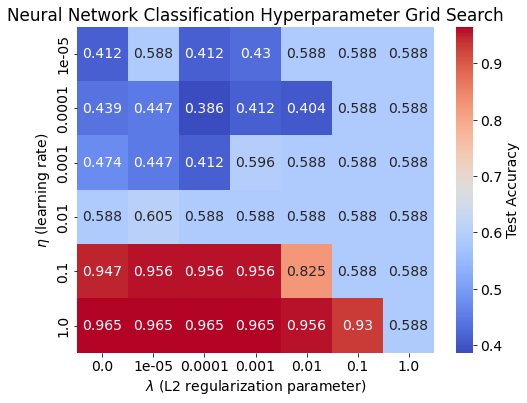

In [104]:
fig,ax = plt.subplots(figsize=(8,6))

sns.heatmap(nn_class_grid, annot=True, cmap='coolwarm', fmt='.3g', cbar_kws={'label': 'Test Accuracy'})
ax.set_xticklabels(lmbdas.round(5))
ax.set_yticklabels(etas.round(5))
ax.set_ylabel("$\\eta$ (learning rate)")
ax.set_xlabel("$\\lambda$ (L2 regularization parameter)")
ax.set_title('Neural Network Classification Hyperparameter Grid Search')
fig.savefig('classification_nn_grid.jpg', dpi=1000, bbox_inches='tight')

In [149]:
activ_funcs = ['sigmoid', 'sigmoid']
net_class = neural_network([30, 20, 2], activ_funcs, 'classification', lmbda=0.0)

data_size = len(train_data)
n_epochs = 200
eta = 1

test_acc_sigmoid = net_class.SGD(train_data, test_data, n_epochs, data_size, eta)

Epoch 0: 0.5877192982456141
Epoch 1: 0.5877192982456141
Epoch 2: 0.6052631578947368
Epoch 3: 0.631578947368421
Epoch 4: 0.6754385964912281
Epoch 5: 0.7631578947368421
Epoch 6: 0.7982456140350878
Epoch 7: 0.8333333333333334
Epoch 8: 0.8947368421052632
Epoch 9: 0.9210526315789473
Epoch 10: 0.956140350877193
Epoch 11: 0.956140350877193
Epoch 12: 0.956140350877193
Epoch 13: 0.956140350877193
Epoch 14: 0.9473684210526315
Epoch 15: 0.9473684210526315
Epoch 16: 0.9473684210526315
Epoch 17: 0.9473684210526315
Epoch 18: 0.9473684210526315
Epoch 19: 0.9473684210526315
Epoch 20: 0.9473684210526315
Epoch 21: 0.9473684210526315
Epoch 22: 0.9473684210526315
Epoch 23: 0.9473684210526315
Epoch 24: 0.9473684210526315
Epoch 25: 0.956140350877193
Epoch 26: 0.956140350877193
Epoch 27: 0.9649122807017544
Epoch 28: 0.956140350877193
Epoch 29: 0.9649122807017544
Epoch 30: 0.9649122807017544
Epoch 31: 0.9649122807017544
Epoch 32: 0.9649122807017544
Epoch 33: 0.9649122807017544
Epoch 34: 0.9649122807017544
Epo

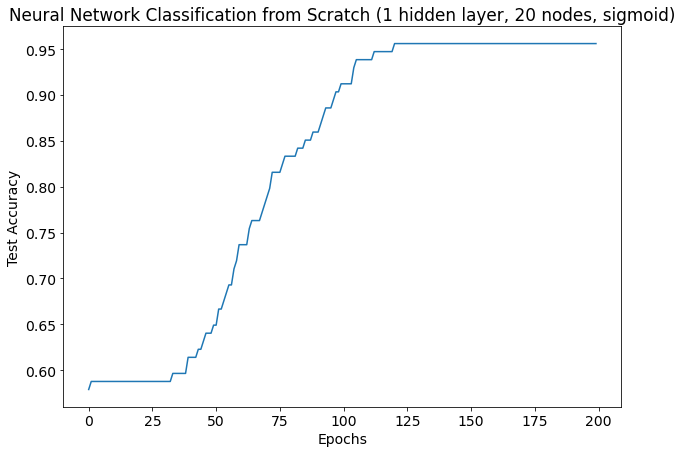

In [105]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(10,7))

ax.plot(test_acc_sigmoid)
ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Epochs')
ax.set_title('Neural Network Classification from Scratch (1 hidden layer, 20 nodes, sigmoid)')
fig.savefig('classification_nn_scratch.jpg', dpi=1000, bbox_inches='tight')

### Tensorflow

In [102]:
set_seed(1)
model = Sequential([
    Dense(units = 20, activation = 'sigmoid', input_dim=30),
    Dense(units = 2, activation = 'sigmoid')
])

model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['accuracy'])

train_history = model.fit(X_train_scaled,y_train, batch_size = 10, epochs = 200, validation_data=(X_test_scaled, y_test))

Epoch 1/200
46/46 [==============================] - 1s 4ms/step - loss: 0.2257 - accuracy: 0.6440 - val_loss: 0.2012 - val_accuracy: 0.6316
Epoch 2/200
46/46 [==============================] - 0s 2ms/step - loss: 0.1718 - accuracy: 0.8044 - val_loss: 0.1587 - val_accuracy: 0.8158
Epoch 3/200
46/46 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.8989 - val_loss: 0.1296 - val_accuracy: 0.8246
Epoch 4/200
46/46 [==============================] - 0s 2ms/step - loss: 0.1116 - accuracy: 0.8901 - val_loss: 0.1066 - val_accuracy: 0.8509
Epoch 5/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0923 - accuracy: 0.8835 - val_loss: 0.0899 - val_accuracy: 0.8509
Epoch 6/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0777 - accuracy: 0.8879 - val_loss: 0.0769 - val_accuracy: 0.8596
Epoch 7/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0659 - accuracy: 0.8901 - val_loss: 0.0663 - val_accuracy: 0.8684
Epoch 8/200
4

Epoch 59/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9648 - val_loss: 0.0230 - val_accuracy: 0.9298
Epoch 60/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.9648 - val_loss: 0.0229 - val_accuracy: 0.9298
Epoch 61/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9648 - val_loss: 0.0230 - val_accuracy: 0.9298
Epoch 62/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9670 - val_loss: 0.0229 - val_accuracy: 0.9298
Epoch 63/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9670 - val_loss: 0.0231 - val_accuracy: 0.9298
Epoch 64/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 0.9670 - val_loss: 0.0230 - val_accuracy: 0.9298
Epoch 65/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 0.9670 - val_loss: 0.0229 - val_accuracy: 0.9298
Epoch 

46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9890 - val_loss: 0.0271 - val_accuracy: 0.9561
Epoch 174/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9890 - val_loss: 0.0272 - val_accuracy: 0.9561
Epoch 175/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9890 - val_loss: 0.0270 - val_accuracy: 0.9561
Epoch 176/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9890 - val_loss: 0.0272 - val_accuracy: 0.9561
Epoch 177/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9890 - val_loss: 0.0271 - val_accuracy: 0.9561
Epoch 178/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9890 - val_loss: 0.0272 - val_accuracy: 0.9561
Epoch 179/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.9890 - val_loss: 0.0273 - val_accuracy: 0.9561
Epoch 180/200

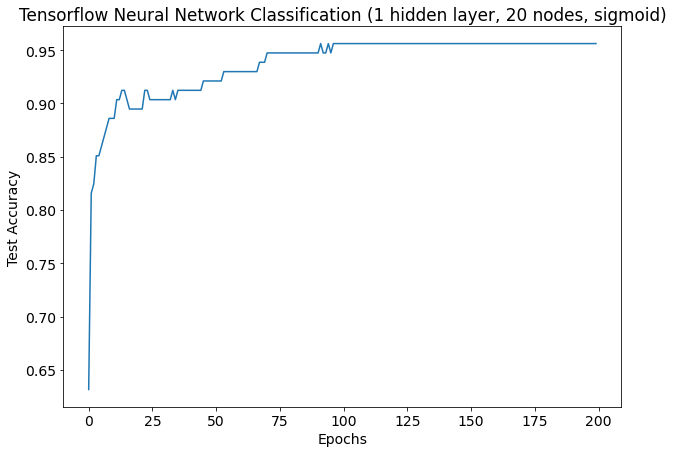

In [106]:
test_accuracy = train_history.history['val_accuracy']

plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(10,7))

ax.plot(test_accuracy)
ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Epochs')
ax.set_title('Tensorflow Neural Network Classification (1 hidden layer, 20 nodes, sigmoid)')
fig.savefig('classification_nn_tensorflow.jpg', dpi=1000, bbox_inches='tight')